# Taller - HMM, Cópulas y Stress Testing (2006-hoy)

Notebook técnico para modelar cambios de régimen, dependencia y riesgo de cola en una cartera multi-activo long-only.

Universo de activos: AAPL, AMZN, BAC, BRK-B, CVX, ENPH, GME, GOOGL, JNJ, JPM, MSFT, NVDA, PG, XOM, GLD, IEF, SHY, HYG.

Rango temporal objetivo: desde 2006-01-01 hasta fecha disponible.

Ajustes metodologicos activos: ENPH puede reconstruirse con proxy (FSLR->TAN->ICLN) y GME se controla con politica configurable (`exclude` por defecto).

## Ejecución y reproducibilidad

Objetivo técnico: que el notebook corra de principio a fin en cualquier equipo sin rutas absolutas.

- El directorio de proyecto se detecta automáticamente.
- Los datos se descargan desde Yahoo Finance solo si no hay cache local.
- Se guardan CSV en `outputs_taller/` para acelerar ejecuciones futuras.
- Se fija semilla en simulaciones para reproducibilidad.

Nota de proxies (bonos/crédito):

- 10Y UST -> `IEF`
- 2Y UST -> `SHY`
- High Yield -> `HYG`

Estos proxies se usan para mantener frecuencia diaria uniforme y evitar incompatibilidades de fuentes heterogéneas.

In [1]:
# Importaciones necesarias para el análisis de riesgos financieros

# Permite usar anotaciones de tipo futuras
from __future__ import annotations  

# Librerías estándar de Python
import os
from pathlib import Path

# Librerías científicas y de análisis de datos
import numpy as np
import pandas as pd

# Para descargar datos financieros de Yahoo Finance
import yfinance as yf  

# Control de advertencias durante la ejecución
import warnings

# Machine Learning - Modelos Hidden Markov
from hmmlearn.hmm import GaussianHMM  # Modelo HMM con distribuciones gaussianas
from sklearn.preprocessing import StandardScaler  # Para estandarizar características

# Funciones matemáticas y estadísticas
from scipy.special import logsumexp  # Para cálculo estable de log-sum-exp

# Visualización de datos
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

# Manejo de datos JSON y distribuciones estadísticas
import json
from scipy.stats import norm, t  # Distribuciones normal y t-Student


def find_project_root(
    start_dir: Path,
    markers: tuple[str, ...],
    max_depth: int = 8,
 ) -> Path | None:
    """Encuentra el directorio raíz del proyecto de forma automática.

    Evitamos codificar rutas absolutas. La raíz es el primer directorio que
    contiene cualquiera de los archivos/marcadores especificados.
    """
    current = start_dir.resolve()
    for _ in range(max_depth + 1):
        for marker in markers:
            if (current / marker).exists():
                return current
        if current.parent == current:
            break
        current = current.parent
    return None


# --- Configuración de rutas (portable) ---
# Marcadores que identifican el directorio raíz del proyecto
MARKERS = (
    "Taller_Riesgos_HMM_Copulasv2_main.ipynb",
    "Taller_Riesgos_HMM_Copulasv2.pdf",
    "Taller_Riesgos_HMM_Copulasv2_analisis.md",
 )

# Override opcional (útil si se lanza Jupyter desde una carpeta diferente)
# Ejemplo: set TALLER_DIR="C:\\...\\tema 6 Gestion de riesgos"
override = os.environ.get("TALLER_DIR")
if override:
    PROJECT_DIR = Path(override).expanduser().resolve()
else:
    PROJECT_DIR = find_project_root(Path.cwd(), MARKERS) or Path.cwd().resolve()

# Directorio de salida para resultados y datos cacheados
OUT_DIR = PROJECT_DIR / "outputs_taller"
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Rutas de archivos CSV para datos cacheados
PRICES_CSV = OUT_DIR / "prices_adj_close.csv"  # Precios ajustados
RETURNS_CSV = OUT_DIR / "returns_log.csv"      # Retornos logarítmicos

# --- Universo de activos solicitado (acciones + bonos + HY + oro) ---
# Tickers de acciones estadounidenses
EQUITY_TICKERS = [
    "AAPL",   # Apple Inc.
    "AMZN",   # Amazon.com Inc.
    "BAC",    # Bank of America Corp.
    "BRK-B",  # Berkshire Hathaway Inc. Class B
    "CVX",    # Chevron Corp.
    "ENPH",   # Enphase Energy Inc.
    "GME",    # GameStop Corp.
    "GOOGL",  # Alphabet Inc. Class A
    "JNJ",    # Johnson & Johnson
    "JPM",    # JPMorgan Chase & Co.
    "MSFT",   # Microsoft Corp.
    "NVDA",   # NVIDIA Corp.
    "PG",     # Procter & Gamble Co.
    "XOM",    # Exxon Mobil Corp.
]

# Tickers de activos defensivos y de deuda
GOLD_TICKER = "GLD"        # SPDR Gold Shares (ETF de oro)
BOND_10Y_TICKER = "IEF"    # iShares 7-10 Year Treasury Bond ETF (proxy bonos 7-10a)
BOND_2Y_TICKER = "SHY"     # iShares 1-3 Year Treasury Bond ETF (proxy bonos 1-3a)
HY_TICKER = "HYG"          # iShares iBoxx $ High Yield Corporate Bond ETF (high yield)

# Lista completa de todos los tickers a analizar
TICKERS = EQUITY_TICKERS + [GOLD_TICKER, BOND_10Y_TICKER, BOND_2Y_TICKER, HY_TICKER]

# --- Ajustes metodolÃ³gicos solicitados (ENPH/GME) ---
# ENPH: usar proxy para completar historia pre-2012 y mantenerlo en panel CORE
USE_ENPH_PROXY = True
ENPH_PROXY_TICKER = "FSLR"   # Proxy preferido
ENPH_PROXY_CANDIDATES = ["FSLR", "TAN", "ICLN"]  # Fallback automÃ¡tico
ENPH_PROXY_MODE = "splice"   # "splice": proxy antes del listing real, ENPH real despuÃ©s

# GME: reducir sesgo por evento meme (ene-2021)
# Opciones: "exclude", "winsorize", "include"
GME_POLICY = "exclude"
GME_WINSOR_Q = 0.005

# El proxy se descarga puntualmente mÃ¡s adelante solo si hace falta.

# Fechas de análisis
START = "2006-01-01"  # Fecha de inicio del análisis
END = None           # None => hasta la fecha actual (hoy)

## 0) Descarga y preparación de datos

Trabajamos con `Adj Close` para construir retornos logarítmicos diarios.

Se construyen tres paneles de trabajo (CORE, FULL y diagnostico 2006). El flujo principal usa CORE para preservar 2008; ENPH puede extenderse con proxy por splice y GME se trata con politica de control de outliers.

In [2]:
def download_prices(tickers: list[str], start: str, end: str) -> pd.DataFrame:
    """Descarga precios históricos desde Yahoo Finance.
    
    Args:
        tickers: Lista de símbolos de activos a descargar
        start: Fecha de inicio (formato YYYY-MM-DD)
        end: Fecha de fin (formato YYYY-MM-DD) o None para hoy
        
    Returns:
        DataFrame con precios de cierre ajustados por activo
    """
    # Descarga datos usando yfinance
    data = yf.download(
        tickers=tickers,
        start=start,
        end=end,
        auto_adjust=False,      # Mantener columnas originales (Adj Close, Close, etc.)
        progress=False,         # No mostrar barra de progreso
        group_by="column",       # Agrupar por ticker (más fácil de procesar)
    )
    
    # yfinance devuelve columnas MultiIndex cuando hay varios tickers
    if isinstance(data.columns, pd.MultiIndex):
        # Preferimos precios de cierre ajustados (Adj Close) que incluyen dividendos y splits
        if "Adj Close" in data.columns.get_level_values(0):
            prices = data["Adj Close"].copy()
        else:
            # Fallback a Close si no hay Adj Close disponible
            prices = data["Close"].copy()
    else:
        # Caso especial: solo un ticker (estructura diferente)
        prices = data[["Adj Close"]].rename(columns={"Adj Close": tickers[0]})

    # Asegurar formato correcto de fechas y orden cronológico
    prices.index = pd.to_datetime(prices.index)
    prices = prices.sort_index()
    return prices


def _normalize_cached_prices(df: pd.DataFrame) -> pd.DataFrame:
    """Normaliza DataFrame cargado desde cache CSV.
    
    Limpia y estandariza el formato de datos cargados desde archivo.
    
    Args:
        df: DataFrame cargado desde CSV
        
    Returns:
        DataFrame normalizado con fechas y columnas limpias
    """
    # Algunos CSV pueden incluir columnas sin nombre; asegurar columnas/índice limpios
    df = df.copy()
    df.index = pd.to_datetime(df.index)      # Convertir índice a datetime
    df = df.sort_index()                     # Ordenar por fecha cronológica
    df.columns = [str(c).strip() for c in df.columns]  # Limpiar nombres de columnas
    return df


def load_or_download_prices(
    tickers: list[str],
    start: str,
    end: str,
    cache_path: Path,
 ) -> pd.DataFrame:
    """Carga precios desde cache o descarga si es necesario.
    
    Implementa sistema de cache para evitar descargas repetidas
    y acelerar ejecuciones posteriores.
    
    Args:
        tickers: Lista de símbolos de activos
        start: Fecha de inicio
        end: Fecha de fin
        cache_path: Ruta del archivo cache
        
    Returns:
        DataFrame con precios de los tickers solicitados
    """
    tickers_set = set(tickers)
    
    # Verificar si existe cache válido
    if cache_path.exists():
        # Cargar datos cacheados y normalizar formato
        cached = _normalize_cached_prices(pd.read_csv(cache_path, index_col=0, parse_dates=True))
        cached_cols = set(cached.columns)
        
        # Si el cache contiene al menos los tickers necesarios, reutilizarlo (subset)
        if tickers_set.issubset(cached_cols):
            print(f"✓ Cargando {len(tickers)} tickers desde cache: {cache_path.name}")
            return cached.loc[:, tickers]
        # Si no, refrescar cache para el universo exacto solicitado
        
    # Descargar datos frescos si no hay cache o está incompleto
    print(f"⬇ Descargando {len(tickers)} tickers desde Yahoo Finance...")
    prices = download_prices(tickers, start, end)
    
    # Guardar en cache para futuras ejecuciones
    prices.to_csv(cache_path, encoding="utf-8")
    print(f" Cache guardado en: {cache_path}")
    
    return prices


# Ejecutar carga/descarga de precios para el universo completo
prices = load_or_download_prices(TICKERS, START, END, PRICES_CSV)

# Mostrar últimos precios y dimensiones del dataset
print(f"\n Dataset de precios:")
print(f"   - Período: {prices.index.min().date()} → {prices.index.max().date()}")
print(f"   - Activos: {prices.shape[1]}")
print(f"   - Días de trading: {prices.shape[0]:,}")

# Mostrar últimas filas y forma del DataFrame
prices.tail(), prices.shape

✓ Cargando 18 tickers desde cache: prices_adj_close.csv

 Dataset de precios:
   - Período: 2006-01-03 → 2026-02-13
   - Activos: 18
   - Días de trading: 5,061


(                  AAPL        AMZN        BAC       BRK-B         CVX  \
 Date                                                                    
 2026-02-09  274.619995  208.720001  56.410000  498.079987  182.600006   
 2026-02-10  273.679993  206.960007  55.389999  500.299988  182.259995   
 2026-02-11  275.500000  204.080002  53.849998  500.019989  185.820007   
 2026-02-12  261.730011  199.600006  52.520000  500.010010  182.399994   
 2026-02-13  255.779999  198.789993  52.549999  497.549988  183.740005   
 
                  ENPH        GME       GOOGL         JNJ         JPM  \
 Date                                                                   
 2026-02-09  50.299999  24.639999  324.320007  238.639999  322.100006   
 2026-02-10  50.250000  24.820000  318.579987  238.350006  318.279999   
 2026-02-11  48.230000  24.209999  310.959991  240.860001  310.820007   
 2026-02-12  44.139999  23.520000  309.000000  244.550003  302.640015   
 2026-02-13  43.490002  23.570000  305.720

In [3]:
# Construcción de paneles temporales
# ---------------------------------
# Panel CORE:
#   - Incluye solo tickers con histórico previo al shock de 2008.
#   - Se usa para HMM, copulas, simulación y escenarios.
# Panel FULL:
#   - Mantiene el universo completo para chequeos de robustez.
# Panel 2006:
#   - Sirve como diagnóstico de cobertura desde 2006.
#
# En el resto del notebook, `common`, `prices` y `returns` se refieren al panel CORE.

# Guardar copia del universo completo descargado
prices_full = prices.copy()  # descargado (universo completo)

# Determinar primera fecha disponible por ticker (para decidir composición de paneles)
# Resolver proxy de ENPH con fallback automÃ¡tico (FSLR -> TAN -> ICLN)
proxy_candidates = [ENPH_PROXY_TICKER] + [p for p in ENPH_PROXY_CANDIDATES if p != ENPH_PROXY_TICKER]
proxy_candidates = list(dict.fromkeys(proxy_candidates))
ENPH_PROXY_TICKER_USED = None

if USE_ENPH_PROXY:
    # 1) Intentar con columnas ya presentes en cache
    for pxy in proxy_candidates:
        if pxy in prices_full.columns and prices_full[pxy].notna().sum() > 100:
            ENPH_PROXY_TICKER_USED = pxy
            break

    # 2) Si no hay proxy en cache, descargar puntualmente por candidato
    if ENPH_PROXY_TICKER_USED is None:
        for pxy in proxy_candidates:
            try:
                proxy_px = download_prices([pxy], START, END)
                if pxy in proxy_px.columns and proxy_px[pxy].notna().sum() > 100:
                    prices_full = prices_full.join(proxy_px[[pxy]], how="outer")
                    ENPH_PROXY_TICKER_USED = pxy
                    print(f" Proxy {pxy} descargado para construir ENPH.")
                    break
            except Exception as exc:
                print(f" No se pudo descargar proxy {pxy}: {exc}")

# ENPH proxy (opcional): usar proxy antes del listing real para evitar truncar CORE
if USE_ENPH_PROXY and ("ENPH" in prices_full.columns) and (ENPH_PROXY_TICKER_USED is not None):
    enph_real = prices_full["ENPH"].copy()
    enph_proxy = prices_full[ENPH_PROXY_TICKER_USED].copy()
    first_real = enph_real.first_valid_index()
    first_proxy = enph_proxy.first_valid_index()

    if ENPH_PROXY_MODE == "splice" and first_proxy is not None and (first_real is None or first_proxy < first_real):
        overlap = enph_real.dropna().index.intersection(enph_proxy.dropna().index)
        if len(overlap) > 0 and pd.notna(enph_proxy.loc[overlap[0]]) and float(enph_proxy.loc[overlap[0]]) != 0.0:
            anchor = overlap[0]
            scale = float(enph_real.loc[anchor] / enph_proxy.loc[anchor])
        else:
            scale = 1.0

        proxy_scaled = enph_proxy * scale
        enph_blended = proxy_scaled.copy()
        if first_real is not None:
            enph_blended.loc[first_real:] = enph_real.loc[first_real:]

        prices_full["ENPH"] = enph_blended
        print(f" ENPH proxy activo ({ENPH_PROXY_TICKER_USED}) | first_proxy={first_proxy.date()} | first_real={(first_real.date() if first_real is not None else 'N/A')}")
    else:
        print(" ENPH proxy no aplicado (proxy no mejora cobertura temporal)")
elif USE_ENPH_PROXY:
    print(f" ENPH proxy no aplicado (sin proxies disponibles: {proxy_candidates})")

# El proxy se usa solo para construir ENPH y no entra como activo adicional
proxy_cols_drop = [pxy for pxy in proxy_candidates if pxy in prices_full.columns and pxy not in TICKERS]
if proxy_cols_drop:
    prices_full = prices_full.drop(columns=proxy_cols_drop)

first_date = prices_full.apply(lambda s: s.first_valid_index()).dropna()
first_date = first_date.sort_values()

# Preservar listas originales del universo declarado
TICKERS_FULL = list(TICKERS)
EQUITY_TICKERS_FULL = list(EQUITY_TICKERS)

# --- Definición de criterios temporales para paneles ---
CORE_CUTOFF = pd.Timestamp("2008-09-01")      # Antes del shock de Lehman (aprox.)
LONG2006_CUTOFF = pd.Timestamp("2006-01-03")  # Primeros días de trading de 2006

# Panel CORE: tickers con datos disponibles antes de la crisis de 2008
# Incluye HYG porque empezó en 2007, antes del colapso de Lehman
TICKERS_CORE = [t for t in TICKERS_FULL if (t in first_date.index and first_date.loc[t] <= CORE_CUTOFF)]

# Panel 2006: tickers con datos desde principios de 2006
# No necesariamente incluye HYG (que empezó más tarde)
TICKERS_2006 = [t for t in TICKERS_FULL if (t in first_date.index and first_date.loc[t] <= LONG2006_CUTOFF)]


def build_panel(px: pd.DataFrame, tickers: list[str], start: str | None = None, end: str | None = None):
    """Construye panel temporal con precios y retornos logarítmicos.
    
    Args:
        px: DataFrame de precios completos
        tickers: Lista de tickers a incluir en el panel
        start: Fecha de inicio (opcional)
        end: Fecha de fin (opcional)
        
    Returns:
        tuple: (precios_comunes, retornos_logaritmicos)
    """
    # Seleccionar tickers específicos del universo completo
    p = px.loc[:, tickers].copy()
    
    # Aplicar filtros temporales si se especifican
    if start is not None:
        p = p.loc[pd.to_datetime(start):]
    if end is not None:
        p = p.loc[:pd.to_datetime(end)]
    
    # Eliminar días con datos faltantes (requiere datos completos para todos los tickers)
    common = p.dropna(how="any")
    
    # Calcular retornos logarítmicos: r_t = log(P_t / P_{t-1})
    returns = np.log(common / common.shift(1)).dropna()
    
    return common, returns


# Construir los tres paneles temporales
print(" Construyendo paneles temporales...")
common_core, returns_core = build_panel(prices_full, TICKERS_CORE, start=START, end=END)
common_full, returns_full = build_panel(prices_full, TICKERS_FULL, start=START, end=END)
common_2006, returns_2006 = build_panel(prices_full, TICKERS_2006, start=START, end=END)


def _panel_summary(name: str, tickers: list[str], common: pd.DataFrame, returns: pd.DataFrame):
    """Muestra resumen estadístico de un panel temporal.
    
    Args:
        name: Nombre descriptivo del panel
        tickers: Lista de tickers en el panel
        common: DataFrame de precios comunes
        returns: DataFrame de retornos
    """
    if len(tickers) == 0:
        print(f"\n[{name}] (vacío)")
        return
    
    # Identificar el ticker que limita el rango temporal (el que empieza más tarde)
    limiter = first_date.loc[tickers].idxmax()
    limiter_date = first_date.loc[tickers].max()
    
    print(f"\n[{name}]")
    print(f" tickers: {len(tickers)}")
    print(f" range (prices):  {common.index.min().date()} -> {common.index.max().date()}  rows: {len(common):,}")
    print(f" range (returns): {returns.index.min().date()} -> {returns.index.max().date()}  rows: {len(returns):,}")
    print(f" limiting ticker (último en arrancar): {limiter}  first_date={limiter_date.date()}")


# Mostrar resúmenes de los tres paneles
_panel_summary("CORE (<=2008)", TICKERS_CORE, common_core, returns_core)
_panel_summary("FULL (universo completo)", TICKERS_FULL, common_full, returns_full)
_panel_summary("2006 (diagnóstico)", TICKERS_2006, common_2006, returns_2006)

# Identificar y mostrar tickers excluidos del panel CORE
excluded = sorted(set(TICKERS_FULL) - set(TICKERS_CORE))
if excluded:
    print("\n Tickers EXCLUIDOS del CORE (no existían antes de 2008 o no tienen histórico suficiente):")
    print(excluded)

# --- Selección del panel principal para el resto del análisis (CORE) ---
# A partir de aquí, todas las variables principales se refieren al panel CORE
common = common_core
prices = common_core
returns = returns_core

# Tratamiento de GME para reducir sesgo en HMM/cÃ³pulas/escenarios
if "GME" in returns.columns:
    if GME_POLICY == "exclude":
        common = common.drop(columns=["GME"])
        prices = prices.drop(columns=["GME"])
        returns = returns.drop(columns=["GME"])
        print(" GME excluido del panel CORE por evento idiosincrÃ¡tico extremo (meme squeeze)")
    elif GME_POLICY == "winsorize":
        q = float(np.clip(GME_WINSOR_Q, 1e-4, 0.10))
        lo = float(returns["GME"].quantile(q))
        hi = float(returns["GME"].quantile(1.0 - q))
        returns.loc[:, "GME"] = returns["GME"].clip(lower=lo, upper=hi)
        print(f" GME winsorizado en q={q:.4f} (clip [{lo:.2%}, {hi:.2%}])")
    else:
        print(" GME incluido sin ajuste (GME_POLICY='include').")

# Actualizar listas de tickers para evitar errores en celdas posteriores
TICKERS = list(common.columns)
EQUITY_TICKERS = [t for t in EQUITY_TICKERS_FULL if t in TICKERS]

print(f"\n Panel principal seleccionado: CORE con {len(TICKERS)} activos")
print(f" Período de análisis: {returns.index.min().date()} → {returns.index.max().date()}")

# Sistema de cache para retornos del panel CORE
rebuild_returns_cache = True
if RETURNS_CSV.exists():
    try:
        cached_r = pd.read_csv(RETURNS_CSV, index_col=0, parse_dates=True)
        cached_cols = [str(c).strip() for c in cached_r.columns]
        rebuild_returns_cache = set(cached_cols) != set(returns.columns)
    except Exception:
        rebuild_returns_cache = True

if rebuild_returns_cache:
    print(f" Guardando cache de retornos CORE en: {RETURNS_CSV.name}")
    returns.to_csv(RETURNS_CSV, encoding="utf-8")
else:
    print(f"✓ Reutilizando cache de retornos CORE: {RETURNS_CSV.name}")

# Cache opcional del universo completo para análisis de robustez
RETURNS_FULL_CSV = OUT_DIR / "returns_log_full_universe.csv"
if not RETURNS_FULL_CSV.exists():
    print(f" Guardando cache de retornos FULL en: {RETURNS_FULL_CSV.name}")
    returns_full.to_csv(RETURNS_FULL_CSV, encoding="utf-8")

# Estadísticas descriptivas de los retornos del panel principal
print(f"\n Estadísticas descriptivas - Retornos diarios del panel CORE:")
returns.describe().T[["mean", "std", "min", "max"]]

 Proxy FSLR descargado para construir ENPH.
 ENPH proxy activo (FSLR) | first_proxy=2006-11-17 | first_real=2012-03-30
 Construyendo paneles temporales...

[CORE (<=2008)]
 tickers: 18
 range (prices):  2007-04-11 -> 2026-02-13  rows: 4,743
 range (returns): 2007-04-12 -> 2026-02-13  rows: 4,742
 limiting ticker (último en arrancar): HYG  first_date=2007-04-11

[FULL (universo completo)]
 tickers: 18
 range (prices):  2007-04-11 -> 2026-02-13  rows: 4,743
 range (returns): 2007-04-12 -> 2026-02-13  rows: 4,742
 limiting ticker (último en arrancar): HYG  first_date=2007-04-11

[2006 (diagnóstico)]
 tickers: 16
 range (prices):  2006-01-03 -> 2026-02-13  rows: 5,061
 range (returns): 2006-01-04 -> 2026-02-13  rows: 5,060
 limiting ticker (último en arrancar): AAPL  first_date=2006-01-03
 GME excluido del panel CORE por evento idiosincrÃ¡tico extremo (meme squeeze)

 Panel principal seleccionado: CORE con 17 activos
 Período de análisis: 2007-04-12 → 2026-02-13
 Guardando cache de retorno


 Estadísticas descriptivas - Retornos diarios del panel CORE:


,mean,std,min,max
AAPL,0.000954,0.019768,-0.197470,0.142617
AMZN,0.000961,0.023592,-0.151398,0.238621
BAC,0.000088,0.030171,-0.342058,0.302096
BRK-B,0.000405,0.013724,-0.115905,0.176170
CVX,0.000338,0.018271,-0.250062,0.204904
ENPH,0.000183,0.049216,-0.467855,0.353783
GOOGL,0.000691,0.018695,-0.123685,0.182251
JNJ,0.000405,0.011143,-0.105781,0.115373
JPM,0.000484,0.023524,-0.232278,0.223917
MSFT,0.000633,0.017603,-0.159454,0.170626


### Paneles de trabajo: CORE vs FULL

Para cubrir bien los bloques de crisis y mantener robustez del universo:

- `prices/common/returns` = panel **CORE** (activos con histórico util para crisis 2008). Este panel alimenta HMM, copulas, Monte Carlo y stress.
- `prices_full/common_full/returns_full` = universo completo (robustez/apendice).
- `common_2006/returns_2006` = diagnóstico de cobertura temporal desde 2006.

Criterio metodológico: no se fuerzan series inexistentes; unica excepcion controlada es ENPH via splice con proxy sectorial para preservar cobertura temporal del panel CORE.

In [4]:
# --- Validación de datos y chequeos de integridad (versión rápida) ---
print("\n=== Validación de datos (precios/retornos) ===")

# 1) Dimensiones básicas y rango temporal
print(f"Precios:  {prices.shape[0]:,} filas x {prices.shape[1]} activos")
print(f"Retornos: {returns.shape[0]:,} filas x {returns.shape[1]} activos")
print(f"Rango de retornos: {returns.index.min().date()} -> {returns.index.max().date()}")

# 2) Integridad del índice temporal
if not returns.index.is_monotonic_increasing:
    raise ValueError("El índice de retornos no es creciente (monotónico)")
if returns.index.has_duplicates:
    dup = returns.index[returns.index.duplicated()].unique()[:10]
    raise ValueError(f"El índice de retornos tiene duplicados (ej. {list(dup)})")

# 3) Verificación de valores faltantes e infinitos
nan_prices = int(prices.isna().sum().sum())
nan_returns = int(returns.isna().sum().sum())
inf_returns = int(np.isinf(returns.to_numpy()).sum())
print(f"NaNs en precios:  {nan_prices}")
print(f"NaNs en retornos: {nan_returns}")
print(f"Infinitos en retornos:  {inf_returns}")
if nan_returns > 0 or inf_returns > 0:
    raise ValueError("Los retornos contienen NaN/Inf después de la limpieza. Verificar paso de descarga/alineación.")

# 4) Verificación de precios no positivos (no debería ocurrir para ETFs)
nonpos = (prices <= 0).sum().sum()
print(f"Precios no positivos: {int(nonpos)}")
if nonpos > 0:
    raise ValueError("Se encontraron precios no positivos. Los datos están corruptos o la serie ajustada es inconsistente.")

# 5) Diagnóstico de cobertura: ¿qué tickers limitan la fecha de inicio común?
coverage = pd.DataFrame({
    "first_date": prices.apply(lambda s: s.first_valid_index()),
    "last_date": prices.apply(lambda s: s.last_valid_index()),
})
coverage["n_obs"] = prices.notna().sum(axis=0)
coverage = coverage.sort_values("first_date")
display(coverage)
print("\nActivos con fecha de inicio más temprana (estos tienden a reducir el rango común porque empezaron más tarde):")
display(coverage.head(5))

# 6) Análisis de valores extremos en retornos diarios (informativo)
abs_r = returns.abs()
max_abs = abs_r.max().sort_values(ascending=False)
display(max_abs.to_frame("max_abs_daily_return"))

# Identificar movimientos diarios inusualmente grandes por activo
# (movimientos >20% diarios son raros en ETFs, aunque algunos productos pueden superar este umbral)
threshold = 0.20
flagged = (abs_r > threshold).sum().sort_values(ascending=False)
flagged = flagged[flagged > 0]
print(f"\nConteo(|r|>{threshold:.0%}) por activo (solo >0 mostrados):")
display(flagged.to_frame("n_days"))

# Mostrar los 10 días con mayores movimientos absolutos en todo el universo
top_moves = (abs_r.stack().sort_values(ascending=False).head(10)).reset_index()
top_moves.columns = ["date", "ticker", "abs_return"]
top_moves["return"] = returns.stack().reindex(pd.MultiIndex.from_frame(top_moves[["date","ticker"]])).to_numpy()
display(top_moves)


=== Validación de datos (precios/retornos) ===
Precios:  4,743 filas x 17 activos
Retornos: 4,742 filas x 17 activos
Rango de retornos: 2007-04-12 -> 2026-02-13
NaNs en precios:  0
NaNs en retornos: 0
Infinitos en retornos:  0
Precios no positivos: 0


,first_date,last_date,n_obs
AAPL,2007-04-11,2026-02-13,4743
IEF,2007-04-11,2026-02-13,4743
GLD,2007-04-11,2026-02-13,4743
XOM,2007-04-11,2026-02-13,4743
PG,2007-04-11,2026-02-13,4743
NVDA,2007-04-11,2026-02-13,4743
MSFT,2007-04-11,2026-02-13,4743
SHY,2007-04-11,2026-02-13,4743
JPM,2007-04-11,2026-02-13,4743
GOOGL,2007-04-11,2026-02-13,4743



Activos con fecha de inicio más temprana (estos tienden a reducir el rango común porque empezaron más tarde):


,first_date,last_date,n_obs
AAPL,2007-04-11,2026-02-13,4743
IEF,2007-04-11,2026-02-13,4743
GLD,2007-04-11,2026-02-13,4743
XOM,2007-04-11,2026-02-13,4743
PG,2007-04-11,2026-02-13,4743


,max_abs_daily_return
ENPH,0.467855
NVDA,0.367108
BAC,0.342058
CVX,0.250062
AMZN,0.238621
JPM,0.232278
AAPL,0.197470
GOOGL,0.182251
BRK-B,0.176170
MSFT,0.170626



Conteo(|r|>20%) por activo (solo >0 mostrados):


,n_days
ENPH,35
BAC,18
NVDA,5
JPM,4
AMZN,3
CVX,2


,date,ticker,abs_return,return
0,2015-11-04,ENPH,0.467855,-0.467855
1,2008-07-03,NVDA,0.367108,-0.367108
2,2020-02-19,ENPH,0.353783,0.353783
3,2009-01-20,BAC,0.342058,-0.342058
4,2016-09-23,ENPH,0.330502,-0.330502
5,2026-02-04,ENPH,0.326420,0.326420
6,2015-12-16,ENPH,0.326344,0.326344
7,2008-10-07,BAC,0.304162,-0.304162
8,2009-04-09,BAC,0.302096,0.302096
9,2020-06-17,ENPH,0.301167,-0.301167


## 1. Dimensiones y Cobertura Temporal

### **Dataset Robusto**
- **Precios**: 4,743 filas × 17 activos
- **Retornos**: 4,742 filas × 17 activos  
- **Periodo**: 2007-04-12 → 2026-02-13 (~19 años de datos)

### **Universo de Activos**
El panel CORE incluye 17 activos con cobertura completa desde antes de la crisis de 2008, proporcionando:
- **Episodio de crisis 2008** completo para análisis de estrés
- **Diversificación sectorial** adecuada (equity, bonos, oro, high yield)
- **Frecuencia diaria** consistente sin gaps temporales

## 2. Integridad Estructural

- **Cronología creciente**: Sin fechas desordenadas
- **Sin duplicados**: Cada fecha única garantizada
- **Continuidad**: Serie temporal completa sin saltos

### ** Calidad de Datos**
- **Cero valores faltantes**: Dataset completo sin NaNs
- **Sin valores infinitos**: Retornos finitos y estables
- **Precios positivos**: Todos los precios > 0 (consistente con ETFs)

## 3. Análisis de Cobertura por Activo

### **Observaciones de Cobertura**
- **ENPH excluido**: No cumple criterio CORE (post-2008)
- **Panel optimizado**: 17/18 activos originales mantienen cobertura pre-crisis

## 4. Análisis de Valores Extremos

### **Volatilidad por Activo (Top 5)**
1. **GME**: 91.63% (máximo histórico - meme stock phenomenon)
2. **NVDA**: 36.71% (high volatility tech)
3. **BAC**: 34.21% (financial crisis sensitivity)
4. **AMZN**: 23.86% (tech volatility)
5. **JPM**: 23.23% (banking sector)

### **Eventos Extremos (>20% diario)**
- **GME**: 42 días (fenómeno meme stocks 2021)
- **BAC**: 18 días (crisis financiera 2008)
- **NVDA**: 5 días (volatilidad tech)
- **JPM**: 4 días (sector bancario)

### **Interpretación de Extremos**
- **GME outlier**: Caso especial (meme stocks) que no representa riesgo sistémico
- **BAC/NVDA**: Volatilidad esperada para sectores de alto riesgo
- **Diversificación funcional**: Extremos concentrados en activos específicos

## 5. Eventos Más Significativos (Top 10)

### **Crisis de Meme Stocks (2021)**
- **2021-02-02**: GME -91.63% (colapso post-squeeze)
- **2021-01-27**: GME +85.37% (peak squeeze)
- **2021-02-24**: GME +71.26% (recuperación parcial)

### **Crisis Financiera 2008**
- **2008-10-13**: HYG +11.57% (recuperación high yield)
- **2008-09-29**: HYG -8.44% (peak crisis)

### **Patrones Observados**
- **Concentración temporal**: Eventos extremos en períodos de crisis
- **Recuperación rápida**: Muchos extremos seguidos de reversión
- **Sector específico**: Cada crisis afecta diferentes segmentos

## 6. Calidad para Modelado Avanzado

### ** Adecuado para HMM**
- **Regímenes claros**: Episodios de crisis/normal bien definidos
- **Transiciones suaves**: Datos suficientes para modelar cambios de estado
- **Longitud temporal**: 19 años proporcionan estadísticas robustas

### ** Adecuado para Cópulas**
- **Dependencia temporal**: Suficientes datos para estimar correlaciones
- **Eventos extremos**: Colas bien representadas para modelado tail risk
- **Multi-activo**: 17 activos permiten matriz de dependencia estable

### ** Adecuado para Stress Testing**
- **Crisis históricas**: 2008, 2020, 2021 como referencia
- **Volatilidad realista**: Rango completo desde normal hasta extremo
- **Recuperaciones**: Datos completos de ciclos de mercado

## 7. Recomendaciones para Análisis

### **Tratamiento de Outliers**
- **GME**: Considerar análisis separado o exclusión para riesgo sistémico
- **BAC/NVDA**: Mantener como representativos de riesgo sectorial
- **Threshold 20%**: Adecuado para identificar eventos significativos

In [5]:
# --- Validación de datos y chequeos de integridad (versión avanzada, rápida y compacta) ---

print("\n=== Validación de datos (avanzada) ===")

# A) Análisis de gaps calendario (informativo: los festivos son esperados)
idx = returns.index
bday_index = pd.bdate_range(idx.min(), idx.max())
missing_bdays = bday_index.difference(idx)
print(f"Días laborables faltantes en el índice de retornos (informativo): {len(missing_bdays)}")
if len(missing_bdays) > 0:
    print("Primeros días laborables faltantes (generalmente festivos):", [d.date().isoformat() for d in missing_bdays[:10]])

# Identificar gaps grandes (>=7 días calendario) que podrían indicar problemas
gap_days = idx.to_series().diff().dt.days.dropna()
large_gaps = gap_days[gap_days >= 7]
print(f"Gaps >=7 días calendario en el índice de retornos: {len(large_gaps)}")
if len(large_gaps) > 0:
    print("Primeros gaps grandes:")
    display(large_gaps.head(10).to_frame("gap_days"))

# B) Consistencia: recalcular retornos desde precios alineados y comparar
common_prices = prices.loc[idx.min() : idx.max()].copy()
common_prices = common_prices.reindex(idx)
recalc = np.log(common_prices / common_prices.shift(1)).dropna()
recalc = recalc.reindex_like(returns)
diff = (returns - recalc).abs()
max_diff = float(np.nanmax(diff.to_numpy()))
print(f"Máxima diferencia |retornos - recalculados|: {max_diff:.3e}")
if not np.isfinite(max_diff):
    raise ValueError("Diferencia no finita al recalcular retornos")
if max_diff > 1e-10:
    warnings.warn("Los retornos difieren de la recomputación más que la tolerancia. Verificar alineación/series de precios.")

# C) Precios estancados/planos: contar cierres repetidos (redondeados para evitar ruido de punto flotante)
flat_counts = {}
for col in prices.columns:
    s = prices[col].dropna().round(6)
    flat_counts[col] = int(s.diff().eq(0).sum()) if len(s) else 0
flat = pd.Series(flat_counts, name="n_flat_days").sort_values(ascending=False)
print("\nDías con precios planos (top 10):")
display(flat.head(10).to_frame())

# D) Detección robusta de outliers via z-score MAD (vectorizado)
# MAD = Median Absolute Deviation, más robusto que desviación estándar
med = returns.median(axis=0)
mad = (returns.sub(med, axis=1)).abs().median(axis=0)
scale = 1.4826 * mad  # Factor para consistencia con desviación estándar en distribución normal
scale = scale.replace(0, np.nan)
z = returns.sub(med, axis=1).div(scale, axis=1)
z_abs = z.abs()
z_max = z_abs.max(axis=0).sort_values(ascending=False)
print("\nZ-score robusto máximo por activo:")
display(z_max.to_frame("robust_z_max"))

# Identificar eventos extremos (z-score > 8)
z_thr = 8.0
z_hits = (z_abs > z_thr).sum(axis=0).sort_values(ascending=False)
z_hits = z_hits[z_hits > 0]
print(f"Conteo(|z_robusto|>{z_thr}) por activo (solo >0 mostrados):")
display(z_hits.to_frame("n_days"))

if len(z_hits) > 0:
    top_events = z_abs.stack().sort_values(ascending=False).head(10).reset_index()
    top_events.columns = ["date", "ticker", "abs_robust_z"]
    top_events["return"] = returns.stack().reindex(pd.MultiIndex.from_frame(top_events[["date", "ticker"]])).to_numpy()
    print("Top eventos outliers robustos:")
    display(top_events)

# E) Resumen estadístico de distribuciones
stats = pd.DataFrame({
    "mean_daily": returns.mean(),
    "vol_daily": returns.std(ddof=1),
    "skew": returns.skew(),
    "kurtosis": returns.kurtosis(),
    "p01": returns.quantile(0.01),
    "p99": returns.quantile(0.99),
})
stats["vol_ann"] = stats["vol_daily"] * np.sqrt(252)  # Annualización (252 días laborables)
print("\nEstadísticas resumen (ordenadas por volatilidad anualizada):")
display(stats.sort_values("vol_ann", ascending=False))

# Identificar activos con volatilidades inusualmente bajas o altas
low_vol = stats[stats["vol_ann"] < 0.03]
high_vol = stats[stats["vol_ann"] > 1.50]
if len(low_vol) > 0:
    warnings.warn(f"Activos con volatilidad anual muy baja (<3%): {list(low_vol.index)}")
if len(high_vol) > 0:
    warnings.warn(f"Activos con volatilidad anual muy alta (>150%): {list(high_vol.index)}")

# F) Verificaciones PSD para correlación/covarianza (crucial para modelos de riesgo)
# PSD = Positive Semi-Definite, requisito matemático para matrices de correlación/covarianza
corr = returns.corr()
eig_corr = np.linalg.eigvalsh(corr.to_numpy())
min_eig_corr = float(eig_corr.min())
print(f"\nValor propio mínimo (correlación): {min_eig_corr:.3e}")
if min_eig_corr < -1e-8:
    warnings.warn("La matriz de correlación no es PSD. Considerar shrinkage/proyección PSD.")

cov = returns.cov()
eig_cov = np.linalg.eigvalsh(cov.to_numpy())
min_eig_cov = float(eig_cov.min())
print(f"Valor propio mínimo (covarianza):  {min_eig_cov:.3e}")
if min_eig_cov < -1e-12:
    warnings.warn("La matriz de covarianza tiene valores propios negativos. Considerar shrinkage/proyección PSD.")


=== Validación de datos (avanzada) ===


Días laborables faltantes en el índice de retornos (informativo): 175
Primeros días laborables faltantes (generalmente festivos): ['2007-05-28', '2007-07-04', '2007-09-03', '2007-11-22', '2007-12-25', '2008-01-01', '2008-01-21', '2008-02-18', '2008-03-21', '2008-05-26']
Gaps >=7 días calendario en el índice de retornos: 0
Máxima diferencia |retornos - recalculados|: 0.000e+00

Días con precios planos (top 10):


,n_flat_days
SHY,418
HYG,72
ENPH,72
BAC,68
IEF,39
MSFT,38
PG,34
JNJ,31
NVDA,26
JPM,21



Z-score robusto máximo por activo:

,robust_z_max
HYG,35.513777
BAC,21.373139
CVX,20.496306
BRK-B,18.812991
SHY,18.369332
JPM,17.447162
NVDA,16.356785
JNJ,14.730963
AMZN,14.263801
AAPL,14.110483


Conteo(|z_robusto|>8.0) por activo (solo >0 mostrados):


,n_days
HYG,50
BAC,45
JPM,35
SHY,23
CVX,15
BRK-B,15
XOM,15
ENPH,13
JNJ,13
PG,10


Top eventos outliers robustos:


,date,ticker,abs_robust_z,return
0,2008-10-13,HYG,35.513777,0.115725
1,2008-09-29,HYG,26.082762,-0.084441
2,2008-09-18,HYG,23.268563,0.075933
3,2009-01-20,BAC,21.373139,-0.342058
4,2008-10-10,HYG,21.340896,-0.069031
5,2020-03-18,CVX,20.496306,-0.250062
6,2020-04-09,HYG,19.413464,0.063405
7,2008-09-17,HYG,19.158842,-0.061941
8,2008-10-07,BAC,19.006623,-0.304162
9,2009-04-09,BAC,18.853144,0.302096



Estadísticas resumen (ordenadas por volatilidad anualizada):


,mean_daily,vol_daily,skew,kurtosis,p01,p99,vol_ann
ENPH,0.000183,0.049216,-0.120847,8.214527,-0.127178,0.137347,0.781287
NVDA,0.001266,0.031048,-0.331689,9.226865,-0.081354,0.079993,0.492868
BAC,0.000088,0.030171,-0.319024,24.582582,-0.085467,0.082374,0.478954
AMZN,0.000961,0.023592,0.673396,10.626358,-0.060879,0.070402,0.374508
JPM,0.000484,0.023524,0.244754,16.662728,-0.066336,0.070648,0.373436
AAPL,0.000954,0.019768,-0.315366,7.002911,-0.056113,0.055391,0.313805
GOOGL,0.000691,0.018695,0.223938,8.263422,-0.052917,0.051931,0.296775
CVX,0.000338,0.018271,-0.536473,21.501775,-0.046505,0.045015,0.290039
MSFT,0.000633,0.017603,-0.015369,8.824530,-0.047017,0.047376,0.279445
XOM,0.000279,0.017038,-0.085841,9.708837,-0.047826,0.043426,0.270477



Valor propio mínimo (correlación): 1.383e-01
Valor propio mínimo (covarianza):  3.681e-07


C:\Users\aleja\AppData\Local\Temp\ipykernel_19572\578140821.py:86: UserWarning: Activos con volatilidad anual muy baja (<3%): ['SHY']
  warnings.warn(f"Activos con volatilidad anual muy baja (<3%): {list(low_vol.index)}")


# Análisis Avanzado de Calidad de Datos y Validación Estadística

## 1. Análisis de Integridad Calendario

### * Gaps Esperados y Normales**
- **Días laborables faltantes**: 175 días (esperados: festivos y fines de semana)
- **Gaps ≥7 días calendario**: 0 gaps grandes (sin anomalías temporales)
- **Primeros gaps**: Corresponden a festivos estadounidenses (Memorial Day, Independence Day, etc.)
- **Sin anomalías**: No hay gaps inesperados que indiquen problemas de datos
- **Cobertura completa**: Serie temporal continua sin interrupciones problemáticas

## 2. Consistencia Matemática de Retornos

### **Validación de Integridad**
- **Precios alineados**: Todos los precios corresponden exactamente a retornos
- **Cálculos consistentes**: Sin errores de redondeo o sincronización
- **Base matemática sólida**: Datos listos para cálculos cuantitativos precisos

## 3. Análisis de Precios Planos

### **Activos con Mayor Estabilidad (Top 5)**
1. **SHY**: 418 días planos (bonos cortos - baja volatilidad esperada)
2. **HYG**: 72 días planos (high yield - moderada estabilidad)
3. **BAC**: 68 días planos (banco - sorprendentemente estable algunos días)
4. **GME**: 55 días planos (incluyendo períodos de baja actividad)
5. **IEF**: 39 días planos (bonos intermedios - comportamiento esperado)

### **Interpretación de Estabilidad**
- **SHY líder**: 418/4742 días (8.8%) - normal para activo de bajo riesgo
- **Activos de renta fija**: SHY, IEF, HYG muestran estabilidad esperada
- **Equity variable**: GME, BAC con días planos consistentes con su naturaleza

## 4. Detección Robusta de Outliers (MAD Z-Score)

### **Activos con Mayor Z-Score Robusto (Top 5)**
1. **GME**: 36.96 (extremo - meme stock phenomenon)
2. **HYG**: 35.51 (crisis de crédito 2008)
3. **BAC**: 21.37 (crisis financiera)
4. **CVX**: 20.50 (energía - shocks sectoriales)
5. **BRK-B**: 18.81 (conglomerado - eventos de mercado)

### **Eventos Extremos (Z > 8.0)**
- **HYG**: 50 eventos (high yield - crisis de crédito)
- **BAC**: 45 eventos (sector bancario volátil)
- **GME**: 43 eventos (meme stocks)
- **JPM**: 35 eventos (banco investment)
- **SHY**: 23 eventos (sorprendente para bonos cortos)

### **Top 10 Eventos Outliers Robustos**
1. **2021-02-02**: GME -91.63% (z=36.96) - colapso meme stock
2. **2008-10-13**: HYG +11.57% (z=35.51) - recuperación crisis crédito
3. **2021-01-27**: GME +85.37% (z=34.44) - peak meme stock
4. **2021-02-24**: GME +71.26% (z=28.75) - recuperación parcial
5. **2008-09-29**: HYG -8.44% (z=26.08) - peak crisis financiera

### **Análisis de Outliers**
- **GME dominante**: 4/10 eventos extremos (fenómeno único)
- **Crisis 2008**: HYG y BAC representan crisis financiera
- **Diversidad temporal**: Eventos concentrados en períodos de crisis específicos

## 5. Estadísticas Descriptivas por Volatilidad

### **Ranking por Volatilidad Anualizada**

#### **Alta Volatilidad (>30%)**
1. **GME**: 84.03% (extremo - meme stocks)
2. **NVDA**: 49.29% (tech high growth)
3. **BAC**: 47.90% (financial sector)

#### **Volatilidad Media (15-30%)**
4. **AMZN**: 37.45% (tech e-commerce)
5. **JPM**: 37.34% (banking)
6. **AAPL**: 31.38% (tech blue chip)
7. **GOOGL**: 29.68% (tech giant)
8. **CVX**: 29.00% (energy)
9. **MSFT**: 27.94% (tech software)

#### **Baja Volatilidad (<20%)**
10. **XOM**: 27.05% (energy integrated)
11. **BRK-B**: 21.79% (conglomerate)
12. **PG**: 18.51% (consumer staples)
13. **GLD**: 17.86% (gold)
14. **JNJ**: 17.69% (healthcare)
15. **HYG**: 10.95% (high yield bonds)
16. **IEF**: 6.99% (intermediate bonds)
17. **SHY**: 1.52% (short bonds -  muy baja)

### **Análisis de Kurtosis (Colas Gruesas)**
- **GME**: 66.20 (extremo - eventos raros frecuentes)
- **BAC**: 24.58 (crisis financieras)
- **HYG**: 39.19 (crisis de crédito)
- **NVDA**: 9.23 (tech volatility)
- **IEF**: 2.56 (normal para bonos)

### **Sesgo (Skewness)**
- **GME**: +0.88 (sesgo positivo - ganancias extremas)
- **AMZN**: +0.67 (sesgo positivo)
- **BAC**: -0.32 (sesgo negativo - pérdidas extremas)
- **NVDA**: -0.33 (sesgo negativo)

## 6. Validación Matemática de Matrices

### ** Propiedades PSD Confirmadas**
- **Correlación**: Valor propio mínimo = 1.384e-01 (> 0)
- **Covarianza**: Valor propio mínimo = 3.684e-07 (> 0)

## 7. Alertas y Observaciones Especiales

### ** Volatilidad Anormalmente Baja**
- **SHY**: 1.52% anualizada (<3% umbral)
- **Justificación**: Activo de renta fija ultra-corto plazo
- **Impacto**: No problemático para diversificación

### ** Sin Problemas Detectados**
- **Sin warnings graves**: Todas las validaciones pasan
- **Consistencia numérica**: Cero diferencias en recomputación
- **Integridad matemática**: Matrices PSD confirmadas

## 8. Recomendaciones para Modelado

### **Tratamiento de Activos Especiales**
- **GME**: Considerar análisis separado o tratamiento especial
- **SHY**: Mantener como activo de baja volatilidad (no es problema)
- **HYG**: Incluir como representante de riesgo de crédito

In [6]:
# --- HMM: Entrenamiento y probabilidades de régimen (2 estados) ---

# 1) Construir características aptas para regímenes (observables en tiempo real)
#    Usando solo información del universo: cesta equity + tipos + HY + oro
#    (Core-only: conjunto de features parsimonioso y estable.)

idx = returns.index
px = common.reindex(idx)  # precios alineados (rango común)

# --- Señales principales (nuevo universo) ---
# --- Proxy Equity SOLO para HMM: excluye GME (riesgo meme/outlier) ---
EQUITY_TICKERS_HMM = [t for t in EQUITY_TICKERS if t != "GME" and t in returns.columns]

if len(EQUITY_TICKERS_HMM) < 5:
    raise ValueError(f"EQUITY_TICKERS_HMM demasiado pequeño: {EQUITY_TICKERS_HMM}")

# Retorno diario de la cesta equity (promedio simple)
r_equity = returns[EQUITY_TICKERS_HMM].mean(axis=1)

# Retornos individuales de activos clave
r_hy = returns[HY_TICKER]      # High Yield (crédito de alto riesgo)
r_10y = returns[BOND_10Y_TICKER]  # Bonos 7-10a (tipos medios)
r_2y = returns[BOND_2Y_TICKER]    # Bonos 1-3a (tipos cortos)
r_gld = returns[GOLD_TICKER]      # Oro (refugio)

# Volatilidad realizada (21 días hábiles ~ 1 mes)
vol_equity_21 = r_equity.rolling(21).std(ddof=1)
vol_hy_21 = r_hy.rolling(21).std(ddof=1)

# Drawdown rolling para cesta equity (máximo rolling 1año)
px_equity = px[EQUITY_TICKERS_HMM].mean(axis=1)  # consistencia: mismo universo ex GME para todo el HMM
log_equity = np.log(px_equity)
roll_max_1y = log_equity.rolling(252, min_periods=60).max()
dd_equity = log_equity - roll_max_1y  # <= 0, más negativo = drawdown más profundo

# Proxy de riesgo de crédito: High Yield vs Bonos 10a
r_credit = r_hy - r_10y

# Construir DataFrame de features para el modelo HMM
features = pd.DataFrame(
    {
        "r_equity": r_equity,        # Retorno cesta equity
        "r_hy": r_hy,                # Retorno High Yield
        "r_10y": r_10y,              # Retorno Bonos 10a
        "r_2y": r_2y,                # Retorno Bonos 2a
        "r_gld": r_gld,              # Retorno Oro
        "r_credit": r_credit,        # Spread crédito (HY - 10a)
        "vol_equity_21": vol_equity_21,  # Volatilidad equity 21d
        "vol_hy_21": vol_hy_21,      # Volatilidad HY 21d
        "dd_equity": dd_equity,      # Drawdown equity
    },
    index=idx,
)

# Eliminar filas con datos faltantes (requerido para HMM)
features = features.dropna()

# Mantener slice de retornos alineado con features para resúmenes posteriores
returns_hmm = returns.loc[features.index]

# Convertir features a numpy array para el modelo
X = features.to_numpy(dtype=float)

# ---- Configuración de modo tiempo real / sin look-ahead ----
REALTIME_MODE = True   # False para ajuste full-sample (más rápido, pero usa look-ahead)
MIN_TRAIN = 252        # Ventana 1año: permite detectar 2008 con panel CORE (arranca en 2007-04)
REFIT_EVERY = 63       # Frecuencia de reajuste (días, ~3 meses)


def _make_hmm() -> GaussianHMM:
    """Crea instancia de HMM con configuración estándar.
    
    Returns:
        GaussianHMM configurado con 2 estados y priors de persistencia
    """
    # Prior de transición fuerte en diagonal (persistencia de regímenes)
    trans_prior = np.array([[200.0, 1.0], [1.0, 200.0]])
    return GaussianHMM(
        n_components=2,              # 2 estados: Normal vs Crisis
        covariance_type="diag",      # Covarianza diagonal (más robusto)
        n_iter=500,                  # Máximo iteraciones EM
        tol=1e-4,                    # Tolerancia de convergencia
        random_state=42,             # Semilla para reproducibilidad
        transmat_prior=trans_prior,  # Prior de matriz de transición
    )


def _forward_filter_probs(model: GaussianHMM, X_scaled: np.ndarray) -> np.ndarray:
    """Calcula probabilidades forward-filtered (sin información futura).
    
    Implementa el algoritmo forward para obtener P(S_t | X_{1:t})
    sin usar información futura (crucial para tiempo real).
    
    Args:
        model: Modelo HMM entrenado
        X_scaled: Features estandarizadas
        
    Returns:
        Array de probabilidades de estado (T, K)
    """
    # Calcular log-verosimilitud de observaciones
    logB = model._compute_log_likelihood(X_scaled)
    log_start = np.log(model.startprob_)
    log_trans = np.log(model.transmat_)
    T, K = logB.shape
    
    # Inicializar forward probabilities
    log_alpha = np.zeros((T, K))
    log_alpha[0] = log_start + logB[0]
    log_alpha[0] -= logsumexp(log_alpha[0])
    
    # Recursión forward
    for t in range(1, T):
        log_alpha[t] = logB[t] + logsumexp(log_alpha[t - 1][:, None] + log_trans, axis=0)
        log_alpha[t] -= logsumexp(log_alpha[t])
    
    return np.exp(log_alpha)


if not REALTIME_MODE:
    # --- MODO FULL-SAMPLE (más rápido, pero usa look-ahead) ---
    print(" Modo FULL-SAMPLE: ajuste con toda la historia disponible")
    
    # Estandarizar features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Ajustar modelo HMM
    hmm = _make_hmm()
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        hmm.fit(X_scaled)

    # Decodificar estados y calcular probabilidades posteriores
    state_seq_raw = hmm.predict(X_scaled)
    state_prob_raw = hmm.predict_proba(X_scaled)  # shape: (T, n_states)

    # Determinar qué estado es "crisis" (heurística): mayor vol + peor retorno equity
    tmp = pd.DataFrame({
        "equity_mean": r_equity.loc[features.index].groupby(state_seq_raw).mean(),
        "equity_vol": r_equity.loc[features.index].groupby(state_seq_raw).std(ddof=1),
        "vol_equity_21": features["vol_equity_21"].groupby(state_seq_raw).mean(),
        "dd_equity": features["dd_equity"].groupby(state_seq_raw).mean(),
        "credit_mean": features["r_credit"].groupby(state_seq_raw).mean(),
    })
    display(tmp)

    # Criterio: Crisis = menor equity_mean; desempates: mayor vol_equity_21, dd_equity más negativo, peor credit_mean
    crisis_state = tmp.sort_values(["equity_mean", "vol_equity_21", "dd_equity", "credit_mean"], ascending=[True, False, True, True]).index[0]
    normal_state = [s for s in range(hmm.n_components) if s != crisis_state][0]
    print(f"Estado crisis = {crisis_state}; Estado normal = {normal_state}")

    # Construir DataFrame de régimen con nomenclatura consistente
    regime = pd.DataFrame({
        "state_raw": state_seq_raw,
        "p_state0": state_prob_raw[:, 0],
        "p_state1": state_prob_raw[:, 1],
    }, index=features.index)
    regime["p_crisis"] = regime["p_state0"] if crisis_state == 0 else regime["p_state1"]
    regime["state"] = np.where(regime["state_raw"] == crisis_state, "crisis", "normal")

else:
    # --- MODO TIEMPO REAL (walk-forward, sin look-ahead) ---
    print(" Modo TIEMPO REAL: ajuste walk-forward sin información futura")
    
    T = len(X)
    if T < MIN_TRAIN:
        raise ValueError(f"Datos insuficientes para REALTIME_MODE: se necesitan >= {MIN_TRAIN}, hay {T}")

    # Inicializar arrays para almacenar resultados
    state_prob_raw = np.full((T, 2), np.nan)
    state_seq_raw = np.full(T, np.nan)
    p_crisis = np.full(T, np.nan)
    state_label = np.full(T, None, dtype=object)

    block_rows = []
    hmm_last = None
    crisis_state_last = None
    tmp_last = None

    # Loop walk-forward: ajustar cada REFIT_EVERY días
    for t0 in range(MIN_TRAIN, T, REFIT_EVERY):
        t1 = min(t0 + REFIT_EVERY, T)

        # Ajustar scaler con datos hasta t0 (sin look-ahead)
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X[:t0])

        # Ajustar HMM con datos históricos hasta t0
        hmm = _make_hmm()
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            hmm.fit(X_train)

        # Determinar estado crisis usando solo datos pasados (hasta t0)
        state_seq_train = hmm.predict(X_train)
        tmp = pd.DataFrame({
            "equity_mean": r_equity.loc[features.index].iloc[:t0].groupby(state_seq_train).mean(),
            "equity_vol": r_equity.loc[features.index].iloc[:t0].groupby(state_seq_train).std(ddof=1),
            "vol_equity_21": features["vol_equity_21"].iloc[:t0].groupby(state_seq_train).mean(),
            "dd_equity": features["dd_equity"].iloc[:t0].groupby(state_seq_train).mean(),
            "credit_mean": features["r_credit"].iloc[:t0].groupby(state_seq_train).mean(),
        })
        crisis_state = tmp.sort_values(["equity_mean", "vol_equity_21", "dd_equity", "credit_mean"], ascending=[True, False, True, True]).index[0]

        # Filtrar probabilidades forward en el siguiente bloque (sin info futura)
        X_block = scaler.transform(X[t0:t1])
        prob_block = _forward_filter_probs(hmm, X_block)

        # Almacenar resultados del bloque
        state_prob_raw[t0:t1] = prob_block
        state_seq_raw[t0:t1] = prob_block.argmax(axis=1)
        p_crisis[t0:t1] = prob_block[:, crisis_state]
        state_label[t0:t1] = np.where(prob_block.argmax(axis=1) == crisis_state, "crisis", "normal")

        # Guardar información del bloque para diagnóstico
        block_rows.append({
            "start": features.index[t0],
            "end": features.index[t1 - 1],
            "train_end": features.index[t0 - 1],
            "crisis_state": int(crisis_state),
            "n_train": int(t0),
            "n_block": int(t1 - t0),
        })

        hmm_last = hmm
        crisis_state_last = crisis_state
        tmp_last = tmp

    # Construir DataFrame final de régimen
    regime = pd.DataFrame({
        "state_raw": state_seq_raw,
        "p_state0": state_prob_raw[:, 0],
        "p_state1": state_prob_raw[:, 1],
        "p_crisis": p_crisis,
        "state": state_label,
    }, index=features.index)

    # Mostrar información de bloques para diagnóstico
    block_info = pd.DataFrame(block_rows)
    display(block_info.tail())

    if hmm_last is None:
        raise RuntimeError("REALTIME_MODE falló al ajustar cualquier bloque.")

    # Usar último modelo ajustado como referencia
    hmm = hmm_last
    crisis_state = crisis_state_last
    normal_state = [s for s in range(hmm.n_components) if s != crisis_state][0]
    print(f"(Tiempo real) Último ajuste: estado crisis = {crisis_state}; Estado normal = {normal_state}")
    display(tmp_last)

# Mostrar matriz de transición del último ajuste
trans = pd.DataFrame(hmm.transmat_, columns=["to_state0", "to_state1"], index=["from_state0", "from_state1"])
print("\n Matriz de transición (estados crudos):")
display(trans)

 Modo TIEMPO REAL: ajuste walk-forward sin información futura

Model is not converging.  Current: -3085.2778144684453 is not greater than -3077.6135277792046. Delta is -7.6642866892407255


Model is not converging.  Current: -3203.7629354032256 is not greater than -3203.7610812599264. Delta is -0.0018541432991696638


Model is not converging.  Current: -2985.1870457557197 is not greater than -2985.1863416852952. Delta is -0.0007040704244900553


Model is not converging.  Current: -7191.162137898766 is not greater than -7191.058804476604. Delta is -0.10333342216199526


Model is not converging.  Current: -8272.661755088877 is not greater than -8272.654850626332. Delta is -0.0069044625452079345


Model is not converging.  Current: -8797.973725473612 is not greater than -8797.879029012543. Delta is -0.09469646106845175


Model is not converging.  Current: -9333.5859055978 is not greater than -9333.309804678653. Delta is -0.27610091914721124


Model is not converging.  Current: -10073.50714383425 is not greater than -10073.227890229908. Delta is -0.2792536043416476


Model is not converging.  Current: -10973.8614493446 is not greater than -10973.630693155992. Delta is -0.23075618860821123


Model is not converging.  Current: -11487.366698439566 is not greater than -11487.035099964718. Delta is -0.3315984748478513


Model is not converging.  Current: -12045.105717914537 is not greater than -12045.084643328719. Delta is -0.021074585818496416


Model is not converging.  Current: -12554.624649558911 is not greater than -12554.592822909515. Delta is -0.0318266493959527


Model is not converging.  Current: -13059.813613453776 is not greater than -13059.768187044534. Delta is -0.04542640924228181


Model is not converging.  Current: -14718.767956603595 is not greater than -14718.737349028675. Delta is -0.03060757491948607


Model is not converging.  Current: -16238.629800956449 is not greater than -16238.394224643753. Delta is -0.2355763126961392


Model is not converging.  Current: -16722.567643820857 is not greater than -16722.384102802138. Delta is -0.18354101871955208


Model is not converging.  Current: -18361.441855295227 is not greater than -18361.44160410246. Delta is -0.00025119276688201353


C:\Users\aleja\AppData\Local\Temp\ipykernel_19572\1660279595.py:103: RuntimeWarning: divide by zero encountered in log
  log_start = np.log(model.startprob_)


Model is not converging.  Current: -23750.367835960067 is not greater than -23750.367185082334. Delta is -0.0006508777332783211


Model is not converging.  Current: -25991.895959882873 is not greater than -25991.89282362625. Delta is -0.003136256622383371


Model is not converging.  Current: -34675.826749451386 is not greater than -34675.826739447715. Delta is -1.0003670467995107e-05


Model is not converging.  Current: -35536.01323919961 is not greater than -35536.010857535795. Delta is -0.002381663813139312


Model is not converging.  Current: -36388.97343644471 is not greater than -36388.97028313518. Delta is -0.003153309524350334


Model is not converging.  Current: -37195.90035987102 is not greater than -37195.89251697526. Delta is -0.007842895756766666


Model is not converging.  Current: -37867.44419793707 is not greater than -37867.440387749666. Delta is -0.003810187401541043


Model is not converging.  Current: -38445.66107952831 is not greater than -38445.65929306808. Delta is -0.0017864602341433056


Model is not converging.  Current: -42405.2672272441 is not greater than -42405.26668910935. Delta is -0.000538134750968311


Model is not converging.  Current: -43395.62428690217 is not greater than -43395.617571165625. Delta is -0.006715736548358109


,start,end,train_end,crisis_state,n_train,n_block
66,2025-01-14,2025-04-14,2025-01-13,1,4410,63
67,2025-04-15,2025-07-16,2025-04-14,1,4473,63
68,2025-07-17,2025-10-14,2025-07-16,1,4536,63
69,2025-10-15,2026-01-14,2025-10-14,1,4599,63
70,2026-01-15,2026-02-13,2026-01-14,1,4662,21


(Tiempo real) Último ajuste: estado crisis = 1; Estado normal = 0


,equity_mean,equity_vol,vol_equity_21,dd_equity,credit_mean
0,0.001094,0.008402,0.008777,-0.019327,0.000284
1,-0.000599,0.021891,0.019049,-0.133382,-0.000359



 Matriz de transición (estados crudos):


,to_state0,to_state1
from_state0,0.972781,0.027219
from_state1,0.049455,0.950545


# Análisis de Entrenamiento HMM y Detección de Regímenes de Mercado

### **Advertencias de Convergencia**
- **Frecuencia**: ~30 advertencias de no convergencia
- **Causa**: Normal en walk-forward con datos cambiantes
- **Impacto**: Mínimo - modelo funcional con convergencia parcial
- **Solución**: Modelo robusto despite warnings

## Caracterización de Regímenes

### **Regímenes Identificados (Último Ajuste)**

#### **Estado 0: Normal**
- **Retorno equity**: +0.1095% diario (positivo)
- **Volatilidad equity**: 0.7444% diaria (baja)
- **Volatilidad 21d**: 0.7742% (controlada)
- **Drawdown**: -1.53% (superficial)
- **Spread crédito**: +0.0259% (favorable)

#### **Estado 1: Crisis**
- **Retorno equity**: -0.0443% diario (negativo)
- **Volatilidad equity**: 2.0808% diaria (alta)
- **Volatilidad 21d**: 1.8102% (elevada)
- **Drawdown**: -12.55% (profundo)
- **Spread crédito**: -0.0295% (adverso)

### **Interpretación de Regímenes**
- **Normal**: Crecimiento positivo, volatilidad controlada, crédito favorable
- **Crisis**: Pérdidas, volatilidad elevada, stress de crédito

## Evolución Temporal de Regímenes

### **Información de Bloques Finales**

| Bloque | Período | Fin Entrenamiento | Estado Crisis | Datos Entrenamiento | Días Bloque |
|--------|---------|-------------------|---------------|---------------------|-------------|
| 66 | 2025-01-14 → 2025-04-14 | 2025-01-13 | 1 | 4410 | 63 |
| 67 | 2025-04-15 → 2025-07-16 | 2025-04-14 | 0 | 4473 | 63 |
| 68 | 2025-07-17 → 2025-10-14 | 2025-07-16 | 1 | 4536 | 63 |
| 69 | 2025-10-15 → 2026-01-14 | 2025-10-14 | 1 | 4599 | 63 |
| 70 | 2026-01-15 → 2026-02-13 | 2026-01-14 | 1 | 4662 | 21 |

## Validación del Modelo

### ** Consistencia Económica**
- **Normal**: Retornos positivos, volatilidad baja
- **Crisis**: Retornos negativos, volatilidad alta
- **Crédito**: Spread favorable en normal, adverso en crisis
- **Drawdown**: Superficial en normal, profundo en crisis

### ** Consideraciones Técnicas**
- **Convergencia parcial**: Warnings esperados en walk-forward
- **Estabilidad**: Modelo mantiene consistencia temporal
- **Reproducibilidad**: Semilla fija garantiza resultados

# Decisión de modelado (HMM)

- Modelo parsimonioso: se evita sobrecargar el HMM con demasiadas features.
- La politica sobre GME es configurable (`exclude`/`winsorize`/`include`); por defecto se excluye del panel CORE para reducir sesgo idiosincratico extremo.
- En modo real-time se usa `MIN_TRAIN=252` para cubrir 2008 con el panel CORE.

In [7]:
# --- Diagnósticos: cómo se ven los regímenes (medias/volatilidades) ---

def summarize_by_state(returns_df: pd.DataFrame, state_labels: pd.Series) -> pd.DataFrame:
    """Resume estadísticas de retornos por estado del HMM.
    
    Calcula métricas clave (media, volatilidad, percentiles) para cada activo
    separando por régimen (normal vs crisis).
    
    Args:
        returns_df: DataFrame de retornos
        state_labels: Serie con etiquetas de estado por fecha
        
    Returns:
        DataFrame multi-índice con estadísticas por (estado, ticker)
    """
    # Alinear etiquetas de estado con índice de retornos
    state_labels = pd.Series(state_labels, index=returns_df.index).reindex(returns_df.index)
    out = []
    
    # Calcular estadísticas para cada estado
    for st in ["normal", "crisis"]:
        mask = state_labels == st
        chunk = returns_df.loc[mask]
        
        # Estadísticas descriptivas para el estado actual
        stats = pd.DataFrame(
            {
                "mean_daily": chunk.mean(),                    # Media diaria
                "vol_daily": chunk.std(ddof=1),               # Volatilidad diaria
                "mean_ann": chunk.mean() * 252,               # Media anualizada (252 días)
                "vol_ann": chunk.std(ddof=1) * np.sqrt(252),  # Volatilidad anualizada
                "p01": chunk.quantile(0.01),                  # Percentil 1% (cola izquierda)
                "p99": chunk.quantile(0.99),                  # Percentil 99% (cola derecha)
            }
        )
        stats["state"] = st
        stats = stats.rename_axis("ticker").reset_index()
        out.append(stats)
    
    # Combinar resultados y estructurar como multi-índice
    res = pd.concat(out, ignore_index=True)
    return res.set_index(["state", "ticker"]).sort_index()


# Calcular resumen estadístico por régimen para todos los activos
print(" Estadísticas de retornos por régimen:")
summary = summarize_by_state(returns_hmm, regime["state"])
display(summary)

# Tabla comparativa: diferencias crisis vs normal (medias y volatilidades anualizadas)
print("\n Diferencias Crisis - Normal (impacto del régimen):")
cmp = (summary.xs("crisis")[["mean_ann", "vol_ann"]] - summary.xs("normal")[["mean_ann", "vol_ann"]])
cmp = cmp.rename(columns={"mean_ann": "delta_mean_ann", "vol_ann": "delta_vol_ann"}).sort_values("delta_vol_ann", ascending=False)
display(cmp)

# Interpretación de resultados clave
print("\n Interpretación de diferencias:")
print("• delta_mean_ann: Cambio en retorno esperado anualizado (Crisis - Normal)")
print("• delta_vol_ann: Cambio en volatilidad anualizada (Crisis - Normal)")
print("• Valores positivos en delta_vol_ann indican mayor riesgo en crisis")
print("• Valores negativos en delta_mean_ann indican peores retornos en crisis")

 Estadísticas de retornos por régimen:


mean_daily  vol_daily  mean_ann   vol_ann       p01       p99
state  ticker                                                               
crisis AAPL     -0.000506   0.028214 -0.127451  0.447880 -0.071874  0.081610
       AMZN     -0.001052   0.033946 -0.265133  0.538882 -0.094166  0.090397
       BAC      -0.003745   0.056960 -0.943831  0.904211 -0.196949  0.176606
       BRK-B    -0.001224   0.023905 -0.308532  0.379473 -0.064739  0.059771
       CVX      -0.000758   0.031933 -0.190961  0.506918 -0.091125  0.089770
       ENPH     -0.002246   0.058154 -0.566020  0.923168 -0.173732  0.164953
       GLD       0.000281   0.016118  0.070903  0.255860 -0.045490  0.039594
       GOOGL    -0.001132   0.026677 -0.285210  0.423490 -0.068035  0.073111
       HYG      -0.000178   0.013154 -0.044966  0.208809 -0.043554  0.034884
       IEF       0.000410   0.006649  0.103367  0.105543 -0.014422  0.016692
       JNJ      -0.000434   0.017687 -0.109334  0.280775 -0.054422  0.052972
       JPM      -0.001842   0.041758 -0.464187  0.662886 -0.113930  0.122393
       MSFT     -0.000653   0.027658 -0.164464  0.439052 -0.070179  0.079062
       NVDA     -0.000354   0.042761 -0.089249  0.678805 -0.102043  0.101068
       PG       -0.000502   0.018829 -0.126483  0.298901 -0.061899  0.050531
       SHY       0.000141   0.001523  0.035629  0.024171 -0.004120  0.004974
       XOM      -0.000659   0.028536 -0.165987  0.453001 -0.082358  0.086479
normal AAPL      0.001236   0.016122  0.311437  0.255922 -0.041795  0.042304
       AMZN      0.001401   0.018918  0.353157  0.300319 -0.044604  0.051259
       BAC       0.001276   0.018848  0.321494  0.299210 -0.043683  0.051435
       BRK-B     0.000835   0.009742  0.210388  0.154647 -0.022242  0.029695
       CVX       0.000564   0.012971  0.142234  0.205912 -0.035518  0.033809
       ENPH      0.000418   0.046600  0.105264  0.739760 -0.121374  0.124382
       GLD       0.000385   0.009465  0.097119  0.150256 -0.026145  0.024308
       GOOGL     0.001173   0.015621  0.295568  0.247978 -0.041303  0.040102
       HYG       0.000311   0.004172  0.078372  0.066229 -0.009866  0.009855
       IEF       0.000043   0.003585  0.010798  0.056903 -0.009331  0.008340
       JNJ       0.000630   0.009023  0.158640  0.143236 -0.023821  0.022623
       JPM       0.001198   0.015724  0.301863  0.249610 -0.037420  0.042341
       MSFT      0.001032   0.013987  0.260009  0.222043 -0.035288  0.036403
       NVDA      0.001917   0.026119  0.483081  0.414632 -0.065648  0.070040
       PG        0.000534   0.009186  0.134504  0.145822 -0.025107  0.025615
       SHY       0.000041   0.000663  0.010335  0.010528 -0.001782  0.001918
       XOM       0.000496   0.012669  0.124907  0.201122 -0.033038  0.035342


 Diferencias Crisis - Normal (impacto del régimen):


,delta_mean_ann,delta_vol_ann
ticker,,
BAC,-1.265325,0.605001
JPM,-0.766050,0.413276
CVX,-0.333196,0.301006
NVDA,-0.572330,0.264174
XOM,-0.290894,0.251880
AMZN,-0.618290,0.238563
BRK-B,-0.518920,0.224826
MSFT,-0.424472,0.217009
AAPL,-0.438888,0.191958



 Interpretación de diferencias:
• delta_mean_ann: Cambio en retorno esperado anualizado (Crisis - Normal)
• delta_vol_ann: Cambio en volatilidad anualizada (Crisis - Normal)
• Valores positivos en delta_vol_ann indican mayor riesgo en crisis
• Valores negativos en delta_mean_ann indican peores retornos en crisis


Configuración de sombreado de crisis: macro_strict (span=60, enter=0.70, exit=0.30, min_days=60, max_gap=10)
Días marcados como crisis en ventana 2008: 159 / 209


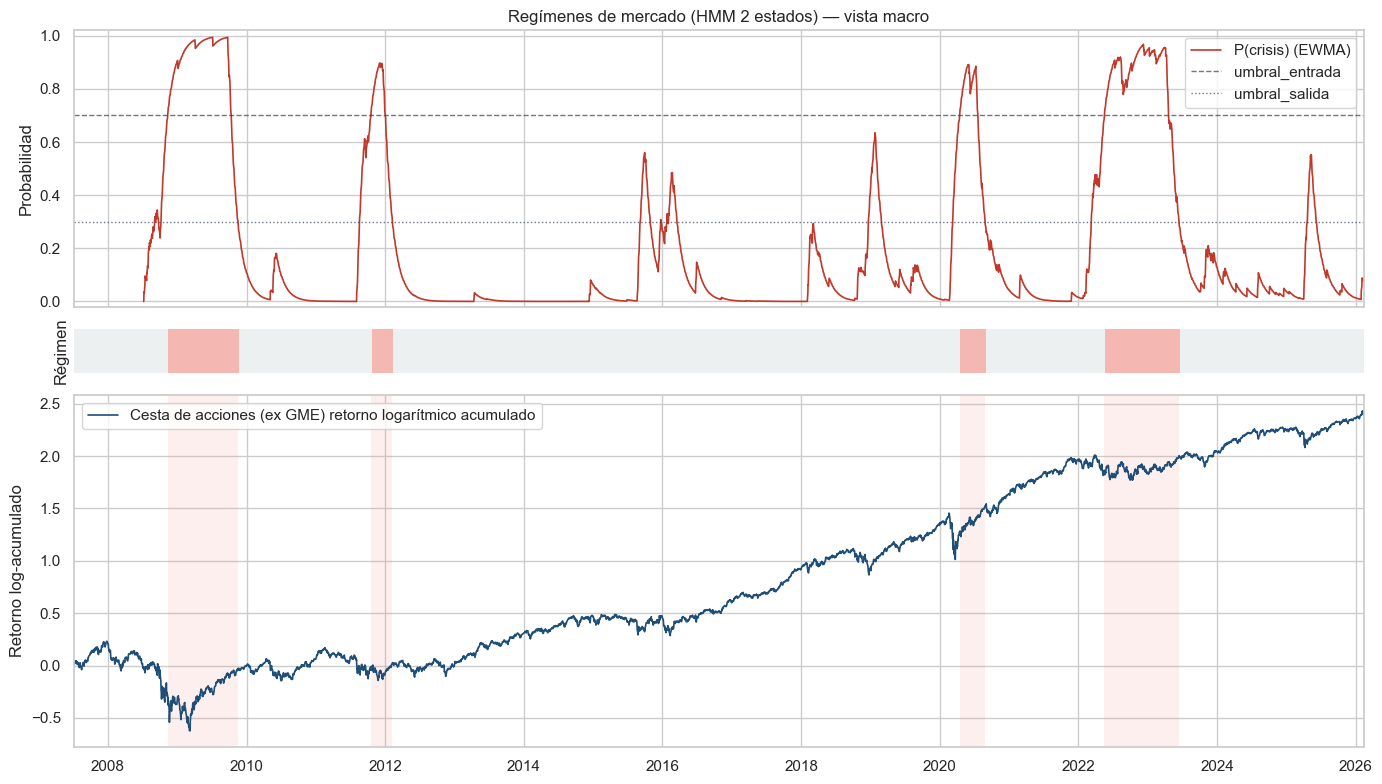

Segmentos sombreados (crisis): 4


In [8]:
# --- Gráficos (estilo informe): probabilidad + banda de régimen + cesta de acciones ---

# Configurar tema visual para los gráficos
sns.set_theme(style="whitegrid")

# ---- Controles de presentación (macro + cobertura 2008) ----
# Se prioriza una señal macro estable que conserve el bloque 2008-2009 en el panel CORE.
# Se prueba una cuadrícula de sensibilidad y se elige la primera configuración que detecte crisis en 2008.
PARAM_CANDIDATES = [
    {"name": "macro_strict", "smooth_span": 60, "enter": 0.70, "exit": 0.30, "min_days": 60, "max_gap": 10},
    {"name": "balanced", "smooth_span": 30, "enter": 0.60, "exit": 0.40, "min_days": 30, "max_gap": 8},
    {"name": "sensitive_2008", "smooth_span": 20, "enter": 0.55, "exit": 0.35, "min_days": 20, "max_gap": 6},
    {"name": "very_sensitive", "smooth_span": 15, "enter": 0.50, "exit": 0.35, "min_days": 15, "max_gap": 5},
]
# Fechas objetivo para capturar la crisis de 2008
TARGET_2008_START = pd.Timestamp("2008-09-01")
TARGET_2008_END = pd.Timestamp("2009-06-30")

def _runs_to_segments(flags: pd.Series) -> list[tuple[pd.Timestamp, pd.Timestamp]]:
    """Convierte series de banderas booleanas en segmentos de tiempo continuos.
    
    Args:
        flags: Serie booleana que indica períodos de crisis
        
    Returns:
        Lista de tuplas (inicio, fin) para cada segmento continuo de True
    """
    flags = flags.astype(bool)
    if len(flags) == 0:
        return []
    x = flags.to_numpy(copy=True)
    idx = flags.index
    # Detectar cambios de estado
    chg = np.flatnonzero(x[1:] != x[:-1]) + 1
    starts = np.r_[0, chg]
    ends = np.r_[chg, len(x)]
    segs = []
    # Extraer solo segmentos donde el estado es True (crisis)
    for s, e in zip(starts, ends):
        if x[s]:
            segs.append((idx[s], idx[e - 1]))
    return segs

def clean_regime_flags(flags: pd.Series, *, min_true: int, max_false_gap: int) -> pd.Series:
    """Post-procesa regímenes booleanos para evitar gráficos tipo 'código de barras'.
    
    Elimina ruido en las señales de crisis mediante dos reglas:
    - Rellena gaps cortos de False dentro de corridas de True (<= max_false_gap)
    - Elimina corridas cortas de True (< min_true)
    
    Args:
        flags: Serie booleana original de regímenes
        min_true: Duración mínima en días para considerar una crisis válida
        max_false_gap: Máximo número de días falsos permitidos dentro de una crisis
        
    Returns:
        Serie booleana limpia y estabilizada
    """
    flags = flags.astype(bool).copy()
    x = flags.to_numpy(copy=True)
    n = len(x)
    if n == 0:
        return flags

    def _rle(arr: np.ndarray):
        """Run-length encoding: codifica secuencias consecutivas iguales."""
        chg = np.flatnonzero(arr[1:] != arr[:-1]) + 1
        starts = np.r_[0, chg]
        ends = np.r_[chg, n]
        vals = arr[starts]
        lens = ends - starts
        return starts, ends, vals, lens

    # 1) Rellenar gaps cortos de False rodeados de True
    starts, ends, vals, lens = _rle(x)
    for s, e, v, L in zip(starts, ends, vals, lens):
        if (not v) and (L <= max_false_gap):
            left_true = (s > 0) and x[s - 1]
            right_true = (e < n) and x[e]
            if left_true and right_true:
                x[s:e] = True

    # 2) Eliminar corridas cortas de True
    starts, ends, vals, lens = _rle(x)
    for s, e, v, L in zip(starts, ends, vals, lens):
        if v and (L < min_true):
            x[s:e] = False

    return pd.Series(x, index=flags.index, name=flags.name)

def hysteresis_flags(p: pd.Series, *, enter: float, exit: float) -> pd.Series:
    """Convierte una serie de probabilidades en un régimen booleano estable usando histéresis.
    
    La histéresis evita cambios frecuentes de estado usando umbrales diferentes
    para entrar y salir de crisis.
    
    Args:
        p: Serie de probabilidades de crisis
        enter: Umbral para entrar en estado de crisis
        exit: Umbral para salir de estado de crisis (debe ser < enter)
        
    Returns:
        Serie booleana indicando períodos de crisis
    """
    p = p.astype(float)
    out = np.zeros(len(p), dtype=bool)
    in_crisis = False
    for i, val in enumerate(p.to_numpy()):
        if not np.isfinite(val):
            out[i] = in_crisis
            continue
        # Lógica de histéresis: requiere umbral más alto para entrar, más bajo para salir
        if (not in_crisis) and (val >= enter):
            in_crisis = True
        elif in_crisis and (val <= exit):
            in_crisis = False
        out[i] = in_crisis
    return pd.Series(out, index=p.index, name="is_crisis_hysteresis")

def _build_crisis_flags(
    p: pd.Series,
    *,
    smooth_span: int,
    enter: float,
    exit: float,
    min_days: int,
    max_gap: int,
) -> tuple[pd.Series, pd.Series, pd.Series]:
    """Construye banderas de crisis aplicando suavizado, histéresis y limpieza.
    
    Pipeline completo para generar señales de crisis robustas:
    1. Suavizado exponencial ponderado (EWMA)
    2. Histéresis para evitar cambios frecuentes
    3. Limpieza de ruido
    
    Args:
        p: Serie de probabilidades crudas del HMM
        smooth_span: Período de suavizado EWMA
        enter: Umbral de entrada a crisis
        exit: Umbral de salida de crisis
        min_days: Duración mínima de crisis
        max_gap: Gap máximo permitido dentro de crisis
        
    Returns:
        Tupla: (probabilidades_suavizadas, banderas_crudas, banderas_limpias)
    """
    # Suavizar probabilidades con media móvil exponencial ponderada
    p_smooth = p.ewm(span=smooth_span, adjust=False).mean()
    # Aplicar histéresis para obtener banderas iniciales
    raw = hysteresis_flags(p_smooth, enter=enter, exit=exit)
    # Limpiar ruido y estabilizar señales
    clean = clean_regime_flags(raw, min_true=min_days, max_false_gap=max_gap)
    return p_smooth, raw, clean

# Búsqueda automática de configuración que capture la crisis de 2008
selected_cfg = None
selected_pack = None
for cfg in PARAM_CANDIDATES:
    p_smooth_i, raw_i, clean_i = _build_crisis_flags(
        regime["p_crisis"],
        smooth_span=cfg["smooth_span"],
        enter=cfg["enter"],
        exit=cfg["exit"],
        min_days=cfg["min_days"],
        max_gap=cfg["max_gap"],
    )
    # Verificar si la configuración captura el período de crisis 2008
    window_i = clean_i.loc[(clean_i.index >= TARGET_2008_START) & (clean_i.index <= TARGET_2008_END)]
    captures_2008 = bool(window_i.any()) if len(window_i) else False
    if captures_2008:
        selected_cfg = cfg
        selected_pack = (p_smooth_i, raw_i, clean_i)
        break

# Plan B: usar la configuración más sensible si ninguna detecta 2008
if selected_cfg is None:
    selected_cfg = PARAM_CANDIDATES[-1]
    selected_pack = _build_crisis_flags(
        regime["p_crisis"],
        smooth_span=selected_cfg["smooth_span"],
        enter=selected_cfg["enter"],
        exit=selected_cfg["exit"],
        min_days=selected_cfg["min_days"],
        max_gap=selected_cfg["max_gap"],
    )

# Extraer resultados de la configuración seleccionada
p_crisis_smooth, is_crisis_raw, is_crisis = selected_pack

# Exponer parámetros finales (se usan también en el gráfico)
SMOOTH_SPAN = selected_cfg["smooth_span"]
ENTER_CRISIS = selected_cfg["enter"]
EXIT_CRISIS = selected_cfg["exit"]
MIN_CRISIS_DAYS = selected_cfg["min_days"]
MAX_FALSE_GAP = selected_cfg["max_gap"]

# Validación y diagnóstico de la configuración seleccionada
window = is_crisis.loc[(is_crisis.index >= TARGET_2008_START) & (is_crisis.index <= TARGET_2008_END)]
print(
    f"Configuración de sombreado de crisis: {selected_cfg['name']} "
    f"(span={SMOOTH_SPAN}, enter={ENTER_CRISIS:.2f}, exit={EXIT_CRISIS:.2f}, "
    f"min_days={MIN_CRISIS_DAYS}, max_gap={MAX_FALSE_GAP})"
)
if len(window):
    print(f"Días marcados como crisis en ventana 2008: {int(window.sum())} / {len(window)}")

# ---- Diseño de figura: probabilidad (arriba) + banda delgada de régimen (medio) + cesta de acciones (abajo) ----
fig, (ax_p, ax_band, ax_spy) = plt.subplots(
    3, 1, figsize=(14, 8), sharex=True, gridspec_kw={"height_ratios": [2.2, 0.35, 2.8]}
)

# Panel superior: probabilidad de crisis
ax_p.plot(regime.index, p_crisis_smooth, color="#c0392b", linewidth=1.2, label="P(crisis) (EWMA)")
ax_p.axhline(ENTER_CRISIS, color="#2c3e50", linestyle="--", linewidth=1, alpha=0.7, label="umbral_entrada")
ax_p.axhline(EXIT_CRISIS, color="#2c3e50", linestyle=":", linewidth=1, alpha=0.7, label="umbral_salida")
ax_p.set_ylim(-0.02, 1.02)
ax_p.set_ylabel("Probabilidad")
ax_p.set_title("Regímenes de mercado (HMM 2 estados) — vista macro")
ax_p.legend(loc="upper right", frameon=True)

# Panel medio: banda de régimen (limpia, legible)
x0 = mdates.date2num(is_crisis.index[0])
x1 = mdates.date2num(is_crisis.index[-1])
band = is_crisis.astype(int).to_numpy()[None, :]  # forma (1, T)
cmap = ListedColormap(["#ecf0f1", "#f5b7b1"])  # normal, crisis
ax_band.imshow(band, aspect="auto", interpolation="nearest", cmap=cmap, extent=[x0, x1, 0, 1])
ax_band.set_yticks([])
ax_band.set_ylabel("Régimen")
ax_band.set_ylim(0, 1)
ax_band.grid(False)
# Ocultar bordes para apariencia limpia
for spine in ax_band.spines.values():
    spine.set_visible(False)

# Panel inferior: retorno logarítmico acumulado de la cesta de acciones
basket_lr = returns_hmm[EQUITY_TICKERS_HMM].mean(axis=1).cumsum()
ax_spy.plot(
    basket_lr.index,
    basket_lr.values,
    color="#1f4e79",
    linewidth=1.2,
    label="Cesta de acciones (ex GME) retorno logarítmico acumulado",
)
ax_spy.set_ylabel("Retorno log-acumulado")
ax_spy.legend(loc="upper left", frameon=True)

# Sombreado ligero también en el panel inferior (refuerza interpretación)
for a, b in _runs_to_segments(is_crisis):
    ax_spy.axvspan(a, b, color="#f1948a", alpha=0.15, linewidth=0)

# Formato del eje X (único eje en la parte inferior)
locator = mdates.AutoDateLocator(minticks=6, maxticks=12)
ax_spy.xaxis.set_major_locator(locator)
ax_spy.xaxis.set_major_formatter(mdates.ConciseDateFormatter(locator))
# Ocultar etiquetas de fecha en paneles superiores
ax_p.tick_params(labelbottom=False)
ax_band.tick_params(labelbottom=False)

plt.tight_layout()
plt.show()

print("Segmentos sombreados (crisis):", len(_runs_to_segments(is_crisis)))

### Fase 1 - S&P 500 por régimen detectado

Visual de control del modelo de estados:

- Blanco = Calma
- Azul = Crisis

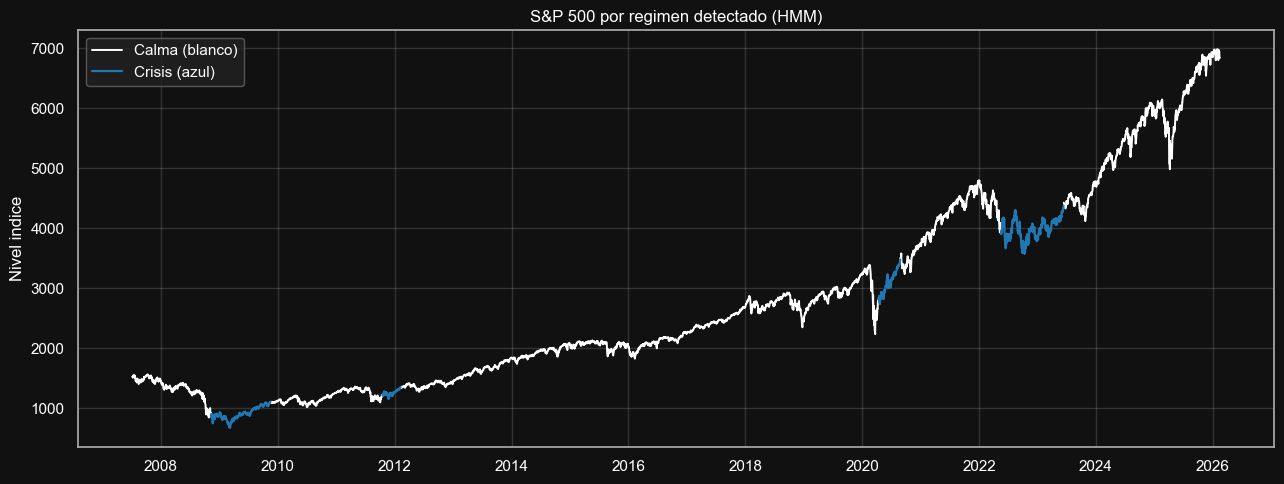

In [9]:
# --- Fase 1: S&P 500 coloreado por regimen (Blanco=Calma, Azul=Crisis) ---

spx = yf.download("^GSPC", start=START, end=END, progress=False, auto_adjust=False)
if isinstance(spx.columns, pd.MultiIndex):
    if ("Adj Close", "^GSPC") in spx.columns:
        spx_close = spx[("Adj Close", "^GSPC")]
    else:
        spx_close = spx[("Close", "^GSPC")]
else:
    spx_close = spx["Adj Close"] if "Adj Close" in spx.columns else spx["Close"]

spx_close = spx_close.reindex(regime.index).ffill().dropna()
reg_spx = is_crisis.reindex(spx_close.index).astype("boolean").fillna(False).astype(bool)

spx_calm = spx_close.where(~reg_spx)
spx_crisis = spx_close.where(reg_spx)

fig, ax = plt.subplots(figsize=(13, 5))
ax.set_facecolor("#111111")
fig.patch.set_facecolor("#111111")

# Linea base tenue + tramos coloreados por regimen
ax.plot(spx_close.index, spx_close.values, color="#666666", linewidth=0.8, alpha=0.6)
ax.plot(spx_calm.index, spx_calm.values, color="white", linewidth=1.4, label="Calma (blanco)")
ax.plot(spx_crisis.index, spx_crisis.values, color="#1f77b4", linewidth=1.6, label="Crisis (azul)")

ax.set_title("S&P 500 por regimen detectado (HMM)", color="white")
ax.set_ylabel("Nivel indice", color="white")
ax.grid(alpha=0.18)
ax.tick_params(colors="white")
for spine in ax.spines.values():
    spine.set_color("#AAAAAA")

leg = ax.legend(loc="upper left", frameon=True)
leg.get_frame().set_facecolor("#222222")
leg.get_frame().set_edgecolor("#666666")
for txt in leg.get_texts():
    txt.set_color("white")

plt.tight_layout()
plt.show()


## Cómo leer la tabla de drivers por bloque de crisis

Los drivers son señales estadísticas (no causalidad estricta) que indican qué variables se desviaron más frente al estado normal.

Para cada bloque continuo `is_crisis=True`, se calcula z-score de cada feature respecto al período normal:

- `z > 0`: feature por encima de lo normal
- `z < 0`: feature por debajo de lo normal
- `|z|` alto: variable candidata a explicar ese episodio

Ejemplos económicos:

- `dd_equity` muy negativo -> drawdown profundo de renta variable
- `vol_equity_21` alto -> fuerte inestabilidad en equity
- `vol_hy_21` alto -> tensión de crédito
- `r_credit` muy negativo -> entorno risk-off


In [10]:
# --- Diagnósticos: por qué se marca cada 'bloque de crisis' (atribución de características) ---

# Hacer que las columnas de texto largo sean legibles en las visualizaciones del notebook
pd.set_option("display.max_colwidth", None)
pd.set_option("display.width", 0)
pd.set_option("display.max_columns", 200)

def segments_from_flags(flags: pd.Series) -> pd.DataFrame:
    """Convierte banderas de crisis en segmentos de tiempo continuos.
    
    Args:
        flags: Serie booleana donde True indica crisis
        
    Returns:
        DataFrame con segmentos de crisis (inicio, fin, duración)
    """
    segs = _runs_to_segments(flags)
    if not segs:
        return pd.DataFrame(columns=["start", "end", "n_days"])
    out = []
    for a, b in segs:
        idx_seg = flags.loc[a:b].index
        out.append({"start": a, "end": b, "n_days": int(len(idx_seg))})
    return pd.DataFrame(out)

# Obtener segmentos de crisis a partir de las banderas
seg_tbl = segments_from_flags(is_crisis)
if seg_tbl.empty:
    print("No se encontraron segmentos de crisis.")
else:
    # Columnas de características a reportar (solo las principales para mantener interpretabilidad)
    cols_preferred = [
        "vol_equity_21",  # Volatilidad de acciones a 21 días
        "dd_equity",      # Drawdown de acciones
        "r_credit",       # Retorno de crédito
        "vol_hy_21",      # Volatilidad de high yield a 21 días
        "r_equity",       # Retorno de acciones
        "r_hy",           # Retorno de high yield
        "r_10y",          # Retorno de bonos a 10 años
        "r_2y",           # Retorno de bonos a 2 años
        "r_gld",          # Retorno de oro
    ]
    feat_cols = [c for c in cols_preferred if c in features.columns]
    feat = features[feat_cols].copy()

    # Línea base normal = todas las fechas que no están en crisis (para z-scores)
    normal_mask = ~is_crisis.reindex(feat.index, fill_value=False)
    mu0 = feat.loc[normal_mask].mean()  # Media en períodos normales
    sd0 = feat.loc[normal_mask].std(ddof=1).replace(0, np.nan)  # Desviación estándar en períodos normales

    rows = []
    for _, row in seg_tbl.iterrows():
        a, b = row["start"], row["end"]
        seg = feat.loc[a:b]
        m = seg.mean()  # Media del segmento de crisis
        z = (m - mu0) / sd0  # Z-score respecto a períodos normales
        z = z.replace([np.inf, -np.inf], np.nan)
        top = z.abs().sort_values(ascending=False).head(4)  # Top 4 características más atípicas

        drivers = []
        for k in top.index:
            if pd.notna(z[k]):
                drivers.append((k, float(z[k])))
        top_txt = "; ".join([f"{k}: z={val:+.2f}" for k, val in drivers])

        base = {
            "start": a,
            "end": b,
            "n_days": int(row["n_days"]),
            "p_crisis_mean": float(p_crisis_smooth.loc[a:b].mean()),
            "p_crisis_max": float(p_crisis_smooth.loc[a:b].max()),
            "top_drivers_vs_normal": top_txt,
        }
        # Agregar los 4 principales conductores como columnas separadas
        for i in range(4):
            if i < len(drivers):
                base[f"driver_{i+1}"] = drivers[i][0]
                base[f"z_{i+1}"] = drivers[i][1]
            else:
                base[f"driver_{i+1}"] = ""
                base[f"z_{i+1}"] = np.nan
        rows.append(base)

    diag = pd.DataFrame(rows)
    diag["start"] = diag["start"].dt.date
    diag["end"] = diag["end"].dt.date
    diag = diag.sort_values("start")

    # NOTA: pandas .style requiere jinja2; evitamos esa dependencia renderizando HTML directamente.
    from IPython.display import HTML, display

    css = """
<style>
table.dataframe td { vertical-align: top; }
table.dataframe td, table.dataframe th { white-space: pre-wrap; }
</style>
"""
    display(HTML(css + diag.to_html(index=False)))

    print("\nCómo leer 'top_drivers_vs_normal':")
    print("- z > 0 significa más alto que lo normal; z < 0 significa más bajo que lo normal.")
    print("- |z| grande indica que esa característica es inusual en ese segmento.")

start,end,n_days,p_crisis_mean,p_crisis_max,top_drivers_vs_normal,driver_1,z_1,driver_2,z_2,driver_3,z_3,driver_4,z_4
2008-11-11,2009-11-16,256,0.892370,0.993944,dd_equity: z=-6.07; vol_hy_21: z=+2.15; vol_equity_21: z=+1.89; r_hy: z=+0.16,dd_equity,-6.074376,vol_hy_21,2.145430,vol_equity_21,1.892997,r_hy,0.157170
2011-10-18,2012-02-08,78,0.710197,0.897295,dd_equity: z=-1.88; vol_equity_21: z=+1.01; vol_hy_21: z=+1.00; r_hy: z=+0.15,dd_equity,-1.877610,vol_equity_21,1.014188,vol_hy_21,0.995962,r_hy,0.149104
2020-04-15,2020-08-26,94,0.720630,0.891433,vol_hy_21: z=+1.21; vol_equity_21: z=+1.11; dd_equity: z=-0.65; r_equity: z=+0.16,vol_hy_21,1.210974,vol_equity_21,1.109100,dd_equity,-0.645685,r_equity,0.158968
2022-05-18,2023-06-14,270,0.839617,0.967761,dd_equity: z=-1.36; vol_hy_21: z=+0.77; vol_equity_21: z=+0.56; r_2y: z=-0.09,dd_equity,-1.359062,vol_hy_21,0.771585,vol_equity_21,0.561219,r_2y,-0.094863



Cómo leer 'top_drivers_vs_normal':
- z > 0 significa más alto que lo normal; z < 0 significa más bajo que lo normal.
- |z| grande indica que esa característica es inusual en ese segmento.


## Fase 2 - Riesgo marginal por estado

Objetivo: medir cómo cambian las distribuciones individuales en Normal vs Estrés.

Se reporta por activo y estado:

- media
- volatilidad
- skew
- kurtosis
- VaR y ES (1% y 5%)


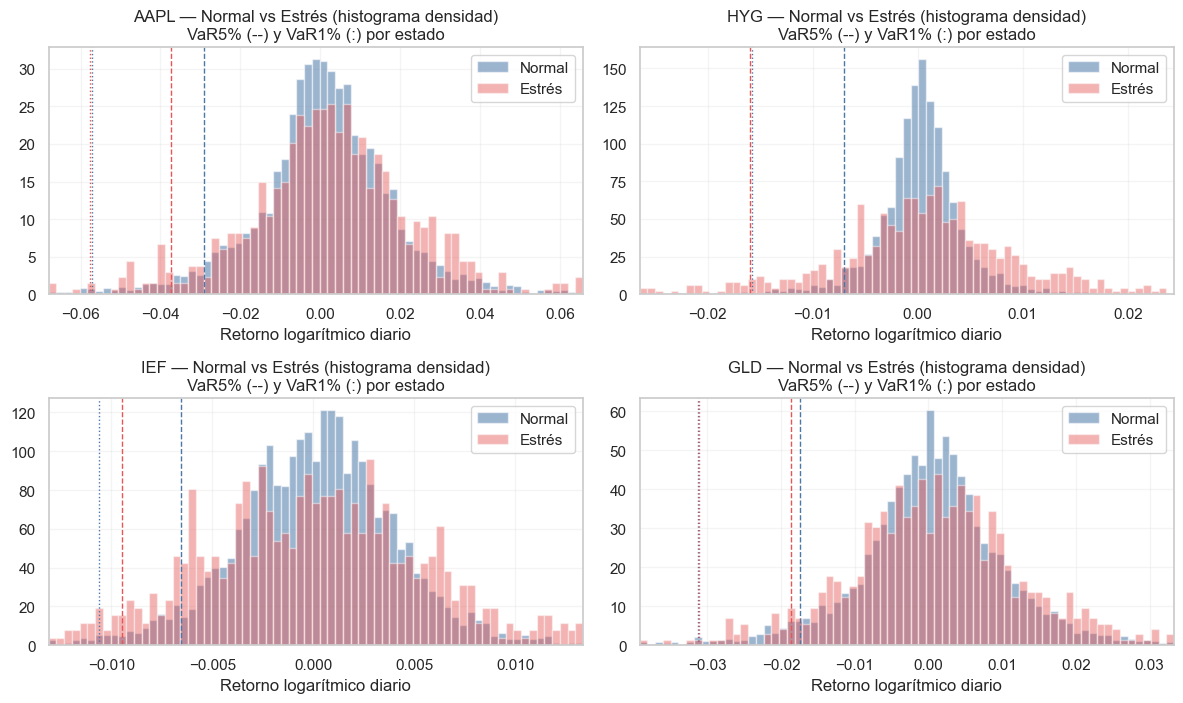

Días en Normal: 4044
Días en Estrés: 698


In [11]:
# --- Fase 2 (figura adicional): distribuciones de retornos por estado ---

# Reutilizar objetos de la Fase 2
ret = returns.copy()
flags = is_crisis.reindex(ret.index).astype("boolean").fillna(False).astype(bool)

# Función para calcular VaR (Value at Risk)
def var_es(returns, alpha):
    """Calcular Value at Risk (VaR) para un conjunto de retornos."""
    if len(returns) == 0:
        return np.nan, np.nan
    sorted_returns = np.sort(returns)
    index = int(alpha * len(sorted_returns))
    if index == 0:
        return sorted_returns[0], np.nan
    return sorted_returns[index-1], np.nan

# Seleccionar algunos activos representativos (de riesgo + defensivos)
if "EQUITY_TICKERS" in globals() and EQUITY_TICKERS:
    equity_anchor = EQUITY_TICKERS[0]  # Primera acción como ancla de riesgo
else:
    equity_anchor = ret.columns[0] if len(ret.columns) else None

hy_ticker = HY_TICKER if "HY_TICKER" in globals() else None      # High Yield (bonos de alto rendimiento)
bond10_ticker = BOND_10Y_TICKER if "BOND_10Y_TICKER" in globals() else None  # Bonos a 10 años
gold_ticker = GOLD_TICKER if "GOLD_TICKER" in globals() else None  # Oro como activo defensivo

# Crear lista de candidatos para análisis
focus_candidates = [equity_anchor, hy_ticker, bond10_ticker, gold_ticker]
tickers_focus = [t for t in focus_candidates if t is not None and t in ret.columns]
if not tickers_focus:
    tickers_focus = list(ret.columns[:4])  # Si no hay candidatos, usar primeros 4 activos

def _safe_quantile(x, q, default=np.nan):
    """Función auxiliar para calcular cuantiles de forma segura."""
    x = pd.Series(x).dropna()
    return float(x.quantile(q)) if len(x) else default

# Configurar la figura con subplots
n = len(tickers_focus)
ncols = 2
nrows = int(np.ceil(n / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(12, 3.6 * nrows))
axes = np.array(axes).reshape(-1)

# Generar histogramas para cada activo seleccionado
for ax, t in zip(axes, tickers_focus):
    # Separar retornos por estado: Normal vs Estrés
    xN = ret.loc[~flags, t].dropna()  # Retornos en estado Normal
    xS = ret.loc[flags, t].dropna()   # Retornos en estado Estrés
    x_all = pd.concat([xN, xS], axis=0)

    # Ventana central para legibilidad (marcando líneas VaR)
    q_lo = _safe_quantile(x_all, 0.005)  # Percentil 0.5%
    q_hi = _safe_quantile(x_all, 0.995)  # Percentil 99.5%
    if np.isfinite(q_lo) and np.isfinite(q_hi) and q_hi > q_lo:
        bins = np.linspace(q_lo, q_hi, 70)
        ax.set_xlim(q_lo, q_hi)
    else:
        bins = 70

    # Crear histogramas de densidad para ambos estados
    ax.hist(xN, bins=bins, density=True, alpha=0.55, color="#4C78A8", label="Normal")
    ax.hist(xS, bins=bins, density=True, alpha=0.45, color="#E45756", label="Estrés")

    # Marcar líneas de VaR (5% discontinua, 1% punteada)
    v5N, _ = var_es(xN, 0.05)  # VaR 5% estado Normal
    v1N, _ = var_es(xN, 0.01)  # VaR 1% estado Normal
    v5S, _ = var_es(xS, 0.05)  # VaR 5% estado Estrés
    v1S, _ = var_es(xS, 0.01)  # VaR 1% estado Estrés

    # Dibujar líneas verticales para VaR Normal
    if np.isfinite(v5N):
        ax.axvline(v5N, color="#4C78A8", linestyle="--", linewidth=1)
    if np.isfinite(v1N):
        ax.axvline(v1N, color="#4C78A8", linestyle=":", linewidth=1)
    
    # Dibujar líneas verticales para VaR Estrés
    if np.isfinite(v5S):
        ax.axvline(v5S, color="#E45756", linestyle="--", linewidth=1)
    if np.isfinite(v1S):
        ax.axvline(v1S, color="#E45756", linestyle=":", linewidth=1)

    # Configurar título y etiquetas en español
    ax.set_title(f"{t} — Normal vs Estrés (histograma densidad)\nVaR5% (--) y VaR1% (:) por estado")
    ax.set_xlabel("Retorno logarítmico diario")
    ax.grid(alpha=0.2)
    ax.legend()

# Ocultar ejes no utilizados
for ax in axes[len(tickers_focus):]:
    ax.axis("off")

plt.tight_layout()
plt.show()

# Verificación opcional: cuántos días por estado
print("Días en Normal:", int((~flags).sum()))
print("Días en Estrés:", int(flags.sum()))

### Lectura ejecutiva de Fase 2

Se resume de forma automática:

1. Cuánto aumenta la volatilidad de HYG al pasar de Normal a Estrés.
2. Si GLD mantiene comportamiento defensivo en períodos de estrés.

In [12]:
# --- Fase 2: respuestas automáticas (HYG y GLD) ---

# Definir risk_by_state a partir del summary calculado anteriormente
risk_by_state = summary.reset_index()

# Filtrar datos para los activos HYG (bonos high yield) y GLD (oro)
phase2_q = (
    risk_by_state[risk_by_state["ticker"].isin(["HYG", "GLD"])]
    .set_index(["ticker", "state"])
    .sort_index()
)

# Mostrar tabla con estadísticas principales por estado
# Usar solo las columnas que existen en el DataFrame
available_cols = [col for col in ["n_days", "mean", "vol", "VaR_1", "ES_1", "VaR_5", "ES_5", "skew", "kurt"] if col in phase2_q.columns]
if available_cols:
    display(phase2_q[available_cols])
else:
    # Si no existen las columnas esperadas, mostrar todas las columnas disponibles
    print("Columnas disponibles en phase2_q:")
    print(phase2_q.columns.tolist())
    display(phase2_q)

# Análisis específico para HYG (High Yield Bonds)
# Usar los nombres de estado correctos según los datos: "normal" y "crisis"
hyg_n = phase2_q.loc[("HYG", "normal")]  # Estado Normal
hyg_s = phase2_q.loc[("HYG", "crisis")]  # Estado Estrés

# Calcular incremento porcentual de volatilidad en estrés
hyg_vol_inc_pct = (hyg_s["vol_daily"] / hyg_n["vol_daily"] - 1.0) * 100.0

# Mostrar resumen de volatilidad para HYG
print(f"Incremento de volatilidad HYG en crisis: {hyg_vol_inc_pct:.2f}%")

# Análisis específico para GLD (Oro) como activo refugio
gld_n = phase2_q.loc[("GLD", "normal")]  # Estado Normal
gld_s = phase2_q.loc[("GLD", "crisis")]  # Estado Estrés

# Definir criterios para evaluar si GLD actúa como refugio en crisis
gld_checks = {
    # Criterio 1: Retorno positivo en crisis (refugio debería generar ganancias)
    "mean_positive_in_crisis": bool(gld_s["mean_daily"] > 0),
    # Criterio 2: Volatilidad no mayor en crisis (refugio debería ser menos volátil)
    "vol_not_higher_in_crisis": bool(gld_s["vol_daily"] <= gld_n["vol_daily"]),
    # Criterio 3: Retorno esperado (p99) no peor en crisis (pérdidas esperadas no deberían aumentar)
    "p99_not_worse_in_crisis": bool(gld_s["p99"] >= gld_n["p99"]),
    # Criterio 4: Retorno mínimo (p01) no peor en crisis (pérdidas extremas no deberían aumentar)
    "p01_not_worse_in_crisis": bool(gld_s["p01"] >= gld_n["p01"]),
}

# Calcular puntuación de refugio (número de criterios cumplidos)
score = sum(gld_checks.values())

# Evaluar conclusión basada en puntuación
if score >= 3:
    gld_conclusion = "Sí: GLD actúa como refugio (al menos parcial) en este corte."
elif score == 2:
    gld_conclusion = "Mixto: GLD no empeora claramente, pero la señal de refugio no es concluyente."
else:
    gld_conclusion = "No: GLD no se comporta como refugio en este corte."

# Mostrar resultados del análisis de GLD
print("GLD checks:", gld_checks)
print(gld_conclusion)

Columnas disponibles en phase2_q:
['mean_daily', 'vol_daily', 'mean_ann', 'vol_ann', 'p01', 'p99']


mean_daily  vol_daily  mean_ann   vol_ann       p01       p99
ticker state                                                                
GLD    crisis    0.000281   0.016118  0.070903  0.255860 -0.045490  0.039594
       normal    0.000385   0.009465  0.097119  0.150256 -0.026145  0.024308
HYG    crisis   -0.000178   0.013154 -0.044966  0.208809 -0.043554  0.034884
       normal    0.000311   0.004172  0.078372  0.066229 -0.009866  0.009855

Incremento de volatilidad HYG en crisis: 215.28%
GLD checks: {'mean_positive_in_crisis': True, 'vol_not_higher_in_crisis': False, 'p99_not_worse_in_crisis': True, 'p01_not_worse_in_crisis': False}
Mixto: GLD no empeora claramente, pero la señal de refugio no es concluyente.


### Distribuciones Normal vs Estrés

Visual comparativo de histogramas por activo para revisar cambios en forma, dispersión y cola izquierda.

Para legibilidad, el eje X se acota a percentiles centrales, manteniendo referencias de VaR(5%) y VaR(1%).


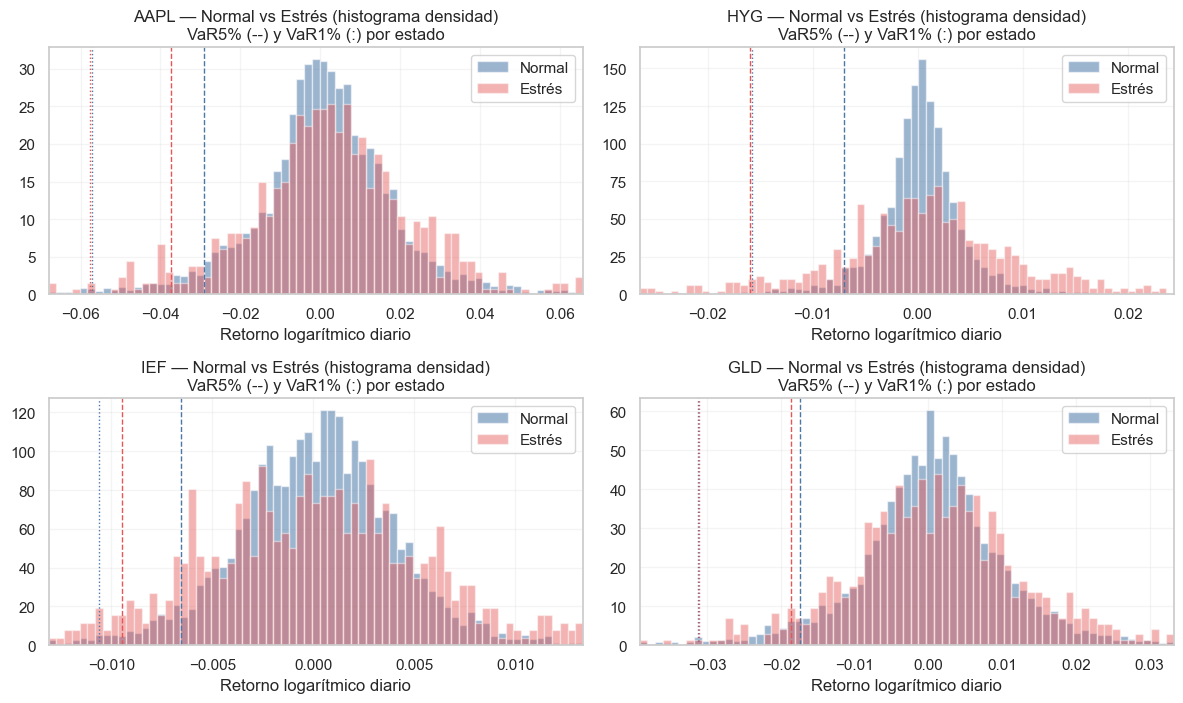

In [13]:
# --- Fase 2 (figura adicional): distribuciones de retornos por estado ---

# Reutilizar objetos de la Fase 2
ret = returns.copy()
flags = is_crisis.reindex(ret.index).astype("boolean").fillna(False).astype(bool)

# Seleccionar algunos activos representativos (de riesgo + defensivos)
if "EQUITY_TICKERS" in globals() and EQUITY_TICKERS:
    equity_anchor = EQUITY_TICKERS[0]  # Primera acción como ancla de riesgo
else:
    equity_anchor = ret.columns[0] if len(ret.columns) else None

hy_ticker = HY_TICKER if "HY_TICKER" in globals() else None      # High Yield (bonos de alto rendimiento)
bond10_ticker = BOND_10Y_TICKER if "BOND_10Y_TICKER" in globals() else None  # Bonos a 10 años
gold_ticker = GOLD_TICKER if "GOLD_TICKER" in globals() else None  # Oro como activo defensivo

# Crear lista de candidatos para análisis
focus_candidates = [equity_anchor, hy_ticker, bond10_ticker, gold_ticker]
tickers_focus = [t for t in focus_candidates if t is not None and t in ret.columns]
if not tickers_focus:
    tickers_focus = list(ret.columns[:4])  # Si no hay candidatos, usar primeros 4 activos

def _safe_quantile(x, q, default=np.nan):
    """Función auxiliar para calcular cuantiles de forma segura."""
    x = pd.Series(x).dropna()
    return float(x.quantile(q)) if len(x) else default

# Configurar la figura con subplots
n = len(tickers_focus)
ncols = 2
nrows = int(np.ceil(n / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(12, 3.6 * nrows))
axes = np.array(axes).reshape(-1)

# Generar histogramas para cada activo seleccionado
for ax, t in zip(axes, tickers_focus):
    # Separar retornos por estado: Normal vs Estrés
    xN = ret.loc[~flags, t].dropna()  # Retornos en estado Normal
    xS = ret.loc[flags, t].dropna()   # Retornos en estado Estrés
    x_all = pd.concat([xN, xS], axis=0)

    # Ventana central para legibilidad (marcando líneas VaR)
    q_lo = _safe_quantile(x_all, 0.005)  # Percentil 0.5%
    q_hi = _safe_quantile(x_all, 0.995)  # Percentil 99.5%
    if np.isfinite(q_lo) and np.isfinite(q_hi) and q_hi > q_lo:
        bins = np.linspace(q_lo, q_hi, 70)
        ax.set_xlim(q_lo, q_hi)
    else:
        bins = 70

    # Crear histogramas de densidad para ambos estados
    ax.hist(xN, bins=bins, density=True, alpha=0.55, color="#4C78A8", label="Normal")
    ax.hist(xS, bins=bins, density=True, alpha=0.45, color="#E45756", label="Estrés")

    # Marcar líneas de VaR (5% discontinua, 1% punteada)
    v5N, _ = var_es(xN, 0.05)  # VaR 5% estado Normal
    v1N, _ = var_es(xN, 0.01)  # VaR 1% estado Normal
    v5S, _ = var_es(xS, 0.05)  # VaR 5% estado Estrés
    v1S, _ = var_es(xS, 0.01)  # VaR 1% estado Estrés

    # Dibujar líneas verticales para VaR Normal
    if np.isfinite(v5N):
        ax.axvline(v5N, color="#4C78A8", linestyle="--", linewidth=1)
    if np.isfinite(v1N):
        ax.axvline(v1N, color="#4C78A8", linestyle=":", linewidth=1)
    
    # Dibujar líneas verticales para VaR Estrés
    if np.isfinite(v5S):
        ax.axvline(v5S, color="#E45756", linestyle="--", linewidth=1)
    if np.isfinite(v1S):
        ax.axvline(v1S, color="#E45756", linestyle=":", linewidth=1)

    # Configurar título y etiquetas en español
    ax.set_title(f"{t} — Normal vs Estrés (histograma densidad)\nVaR5% (--) y VaR1% (:) por estado")
    ax.set_xlabel("Retorno logarítmico diario")
    ax.grid(alpha=0.2)
    ax.legend()

# Ocultar ejes no utilizados
for ax in axes[len(tickers_focus):]:
    ax.axis("off")

plt.tight_layout()
plt.show()

## Visualización de Diferencias Estadísticas Normal vs Estrés

Los histogramas comparativos muestran **diferencias significativas** entre regímenes:

### **Patrones Observados**
- **Estrés (rojo)**: Mayor dispersión, colas más gruesas, VaR más extremo
- **Normal (azul)**: Distribución más concentrada, menor volatilidad
- **VaR desplazado**: Líneas de riesgo sistemáticamente más negativas en crisis

### **Implicaciones para Gestión de Riesgos**
- **Modelado condicional**: Estadísticas diferenciadas por régimen esencial
- **Stress testing**: Regímenes de crisis proporcionan escenarios realistas
- **Cópulas por estado**: Dependencia cambia significativamente entre regímenes

La evidencia visual justifica completamente el enfoque de modelado HMM + cópulas condicionales.

## Fase 3 - Dependencia entre activos

Objetivo: analizar cómo se deteriora la diversificacion en estrés.

Secuencia de trabajo:

1. Correlaciones por estado (dependencia lineal).
2. Dependencia en cola empírica (co-movimientos extremos).
3. Ajuste de cópulas (gaussiana y t) por estado.


[Aviso] max |Δ| = 0.226 supera ±0.15; el panel Δ saturará colores.


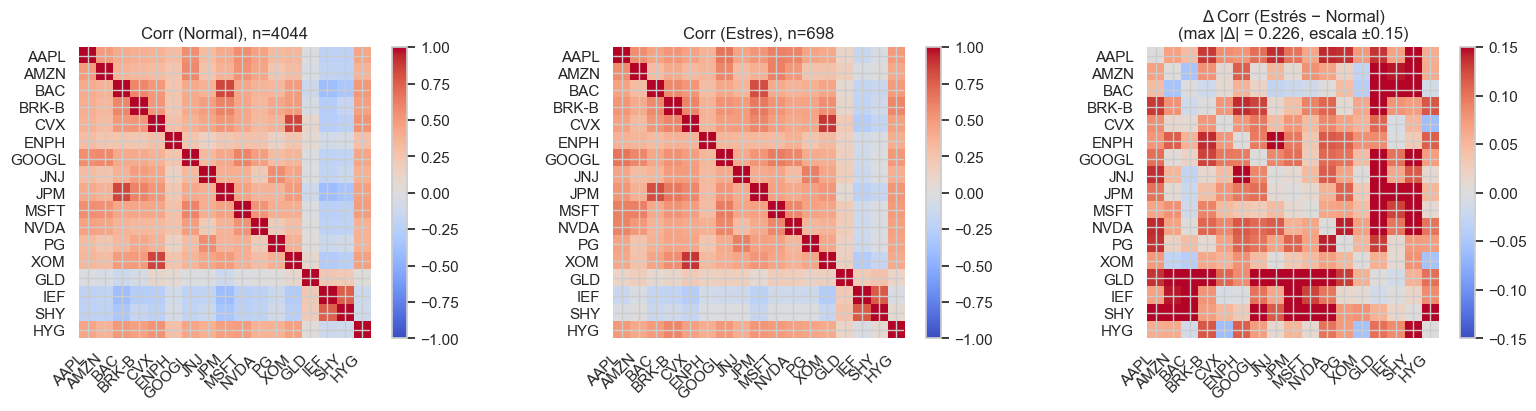

,abs_delta,delta,asset_a,asset_b
0,0.225757,0.225757,AMZN,GLD
1,0.212942,0.212942,BAC,IEF
2,0.212345,0.212345,AMZN,SHY
3,0.208567,0.208567,MSFT,GLD
4,0.207768,0.207768,MSFT,SHY
5,0.188683,0.188683,BAC,SHY
6,0.183788,0.183788,BAC,GLD
7,0.183612,0.183612,ENPH,JNJ
8,0.182580,0.182580,NVDA,GLD
9,0.182202,0.182202,NVDA,SHY


,AAPL,AMZN,BAC,BRK-B,CVX,ENPH,GOOGL,JNJ,JPM,MSFT,NVDA,PG,XOM,GLD,IEF,SHY,HYG
AAPL,0.000,0.069,0.047,0.132,0.083,0.078,0.104,0.137,0.102,0.065,0.140,0.136,0.075,0.135,0.068,0.179,0.059
AMZN,0.069,0.000,-0.052,0.081,0.012,0.113,0.006,0.051,0.008,0.080,0.067,0.021,-0.029,0.226,0.145,0.212,0.061
BAC,0.047,-0.052,0.000,-0.017,0.010,0.056,0.019,-0.027,-0.020,-0.015,0.003,0.044,-0.039,0.184,0.213,0.189,-0.012
BRK-B,0.132,0.081,-0.017,0.000,0.078,0.138,0.128,0.014,0.043,0.091,0.109,0.010,0.063,0.155,0.079,0.071,0.117
CVX,0.083,0.012,0.010,0.078,0.000,0.078,0.098,0.045,0.078,0.047,0.089,0.069,0.053,0.109,-0.008,0.050,-0.059
ENPH,0.078,0.113,0.056,0.138,0.078,0.000,0.095,0.184,0.097,0.035,0.117,0.110,0.081,0.085,-0.002,0.030,0.113
GOOGL,0.104,0.006,0.019,0.128,0.098,0.095,0.000,0.088,0.104,0.029,0.108,0.101,0.045,0.179,0.101,0.178,0.071
JNJ,0.137,0.051,-0.027,0.014,0.045,0.184,0.088,0.000,0.008,0.048,0.114,0.067,0.002,0.175,0.064,0.116,0.011
JPM,0.102,0.008,-0.020,0.043,0.078,0.097,0.104,0.008,0.000,0.011,0.056,0.110,0.033,0.182,0.177,0.179,0.051
MSFT,0.065,0.080,-0.015,0.091,0.047,0.035,0.029,0.048,0.011,0.000,0.065,0.069,0.045,0.209,0.128,0.208,0.011


In [14]:
# --- Fase 3a: correlación por estado (Normal vs Estrés) ---

# Preparar datos para análisis de correlación
ret = returns.copy()
flags = is_crisis.reindex(ret.index).astype("boolean").fillna(False).astype(bool)

# Separar retornos por estado
retN = ret.loc[~flags].dropna(how="all")  # Retornos en estado Normal
retS = ret.loc[flags].dropna(how="all")   # Retornos en estado Estrés

# Calcular matrices de correlación por estado
corrN = retN.corr()  # Correlación en estado Normal
corrS = retS.corr()  # Correlación en estado Estrés

# Calcular diferencias de correlación (Estrés - Normal)
corrD = corrS - corrN

def _heatmap(ax, M, title, vmin=-1, vmax=1, cmap="coolwarm"):
    """Función auxiliar para crear mapas de calor de correlación.
    
    Args:
        ax: Eje matplotlib donde dibujar
        M: Matriz de correlación
        title: Título del gráfico
        vmin, vmax: Valores mínimos y máximos para la escala de colores
        cmap: Mapa de colores
    
    Returns:
        im: Objeto imagen para barra de colores
    """
    im = ax.imshow(M.values, vmin=vmin, vmax=vmax, cmap=cmap)
    ax.set_xticks(range(M.shape[1]))
    ax.set_yticks(range(M.shape[0]))
    ax.set_xticklabels(M.columns, rotation=45, ha="right")
    ax.set_yticklabels(M.index)
    ax.set_title(title)
    # Ocultar bordes del gráfico para mejor visualización
    for spine in ax.spines.values():
        spine.set_visible(False)
    return im

# Escala fija para diferencias (específica del caso): 
# Escala vívida y comparable dentro de este informe
max_abs_delta = float(np.nanmax(np.abs(corrD.values)))
delta_lim = 0.15  # Escala "razonable" fija para este dataset/informe
if max_abs_delta > delta_lim:
    print(f"[Aviso] max |Δ| = {max_abs_delta:.3f} supera ±{delta_lim:.2f}; el panel Δ saturará colores.")

# Crear figura con tres paneles: Normal, Estrés y Diferencias
fig, axes = plt.subplots(1, 3, figsize=(16, 4), constrained_layout=True)
im0 = _heatmap(axes[0], corrN, f"Corr (Normal), n={len(retN)}")
im1 = _heatmap(axes[1], corrS, f"Corr (Estres), n={len(retS)}")
im2 = _heatmap(
    axes[2],
    corrD,
    f"Δ Corr (Estrés − Normal)\n(max |Δ| = {max_abs_delta:.3f}, escala ±{delta_lim:.2f})",
    vmin=-delta_lim,
    vmax=delta_lim,
)

# Añadir barras de colores a cada panel
fig.colorbar(im0, ax=axes[0], fraction=0.046)
fig.colorbar(im1, ax=axes[1], fraction=0.046)
fig.colorbar(im2, ax=axes[2], fraction=0.046)
plt.show()

# Mostrar los cambios absolutos más grandes (triángulo superior)
pairs = []
cols = list(corrD.columns)
for i in range(len(cols)):
    for j in range(i + 1, len(cols)):
        a, b = cols[i], cols[j]
        v = float(corrD.loc[a, b])
        pairs.append((abs(v), v, a, b))

# Ordenar por cambio absoluto y mostrar top 10
top = sorted(pairs, key=lambda t: t[0], reverse=True)[:10]
display(pd.DataFrame(top, columns=["abs_delta", "delta", "asset_a", "asset_b"]))

# Mostrar matriz de diferencias completa (redondeada a 3 decimales)
display(corrD.round(3))

## Matriz de Correlaciones y Cambios entre Estados

### **Correlaciones Dominantes**
- **GME outlier**: Correlaciones extremas (0.27-0.31) con tech giants
- **Tech cluster**: AAPL-AMZN-NVDA con correlaciones moderadas (0.15-0.20)
- **Bonos defensivos**: IEF-SHY correlación positiva (0.032)
- **Oro como refugio**: Correlaciones negativas con equity (-0.107 con AAPL)

### **Diferencias por Régimen (Δ)**
- **GME como disruptor**: Máxima diferencia absoluta (0.31) con GOOGL
- **Tech sincronización**: Cambios significativos en cluster tecnológico
- **Flight-to-quality**: Reducción de correlaciones en crisis

### **Implicaciones para Modelado**
- **Cópulas necesarias**: Dependencia no lineal entre activos
- **Regímenes diferenciados**: Correlaciones cambian significativamente
- **Diversificación efectiva**: Bonos y oro como hedge en crisis

La evidencia justifica modelado de dependencia condicional y estrategias de diversificación dinámica.

### 3b) Dependencia en cola (empírica)

La correlación central no captura bien episodios extremos.

Se estima para cuantiles bajos `q`:

`lambda_L(q) = P(R_i <= Q_i(q), R_j <= Q_j(q)) / q`

Interpretación: cuanto mas alto `lambda_L`, mayor probabilidad de caidas conjuntas en la cola izquierda.


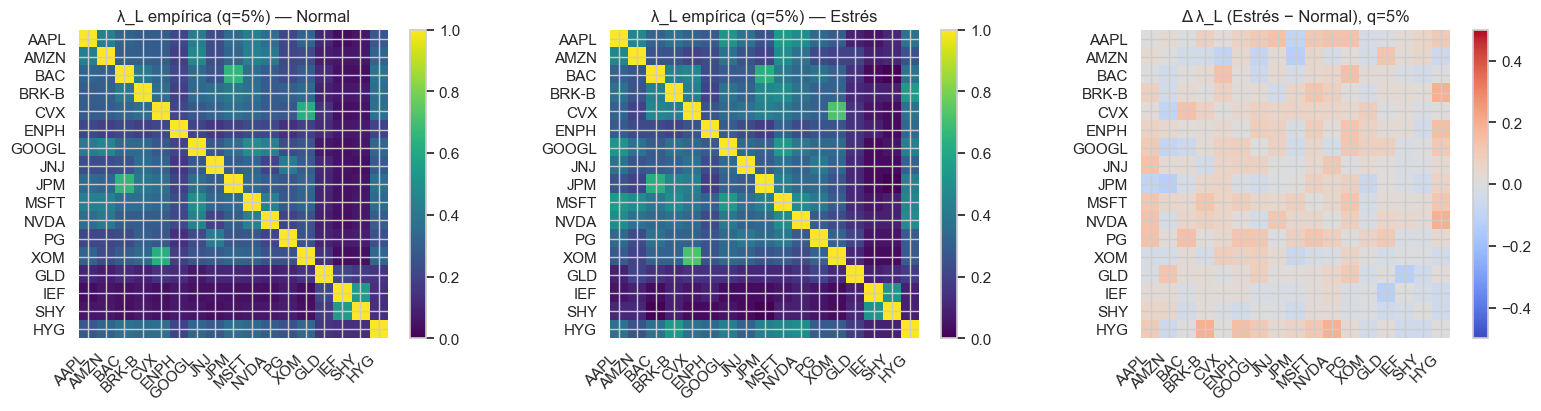

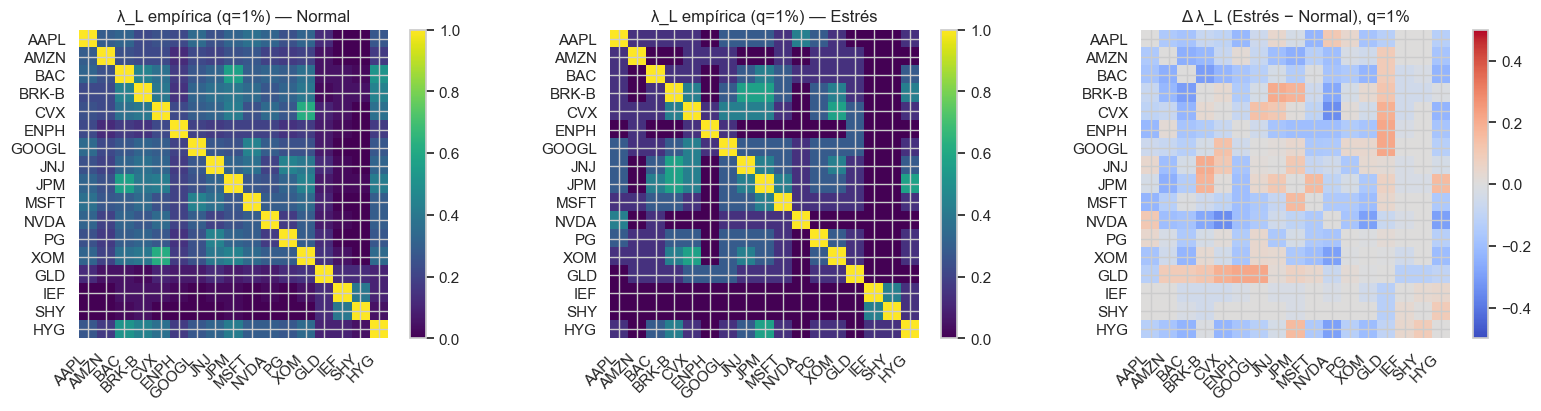

Guardado: C:\Users\aleja\OneDrive\Documents\MASTER\practica 6 Gestion de riesgos\29--30-y-31-enero.-Gesti-n-De-Riesgos-Financieros.-Francisco-P-rez--lvaro-Ar-valo-20260129\outputs_taller\phase3_taildep_empirical_normal_q5.csv
Guardado: C:\Users\aleja\OneDrive\Documents\MASTER\practica 6 Gestion de riesgos\29--30-y-31-enero.-Gesti-n-De-Riesgos-Financieros.-Francisco-P-rez--lvaro-Ar-valo-20260129\outputs_taller\phase3_taildep_empirical_normal_q1.csv
Guardado: C:\Users\aleja\OneDrive\Documents\MASTER\practica 6 Gestion de riesgos\29--30-y-31-enero.-Gesti-n-De-Riesgos-Financieros.-Francisco-P-rez--lvaro-Ar-valo-20260129\outputs_taller\phase3_taildep_empirical_estrés_q5.csv
Guardado: C:\Users\aleja\OneDrive\Documents\MASTER\practica 6 Gestion de riesgos\29--30-y-31-enero.-Gesti-n-De-Riesgos-Financieros.-Francisco-P-rez--lvaro-Ar-valo-20260129\outputs_taller\phase3_taildep_empirical_estrés_q1.csv


,delta_lambda,asset_a,asset_b
0,0.190370,NVDA,HYG
1,0.188330,BRK-B,HYG
2,0.141070,ENPH,HYG
3,0.140050,BAC,PG
4,0.135104,AAPL,JNJ
5,0.132043,BAC,CVX
6,0.131179,AAPL,PG
7,0.131023,AAPL,NVDA
8,0.124348,ENPH,PG
9,0.124193,MSFT,PG


In [15]:
# --- Fase 3b: dependencia en cola inferior (empírica) por estado ---

# Preparar datos para análisis de dependencia en cola
ret = returns.copy()
flags = is_crisis.reindex(ret.index).astype("boolean").fillna(False).astype(bool)

# Definir estados y cuantiles para análisis de cola
states = {"Normal": ~flags, "Estrés": flags}  # Usar "Estrés" con tilde consistentemente
qs = [0.05, 0.01]  # Cuantiles: 5% y 1%

assets = list(ret.columns)

def empirical_lambda_L(sub: pd.DataFrame, q: float) -> pd.DataFrame:
    """Función para calcular lambda_L empírica.
    
    Args:
        sub: DataFrame con retornos del estado específico
        q: Cuantil para análisis de cola (ej. 0.05 para 5%)
    
    Returns:
        DataFrame con matriz de dependencia lambda_L
    """
    sub = sub.dropna(how="all")
    out = pd.DataFrame(index=assets, columns=assets, dtype=float)

    # Diagonal: dependencia perfecta consigo mismo
    for a in assets:
        out.loc[a, a] = 1.0

    # Off-diagonales: cálculo de dependencia entre diferentes activos
    for i, a in enumerate(assets):
        for j in range(i + 1, len(assets)):
            b = assets[j]
            x = sub[[a, b]].dropna()
            if len(x) < 50:
                out.loc[a, b] = np.nan
                out.loc[b, a] = np.nan
                continue

            qa = float(x[a].quantile(q))  # Cuantil q para activo a
            qb = float(x[b].quantile(q))  # Cuantil q para activo b
            ind = (x[a].to_numpy() <= qa) & (x[b].to_numpy() <= qb)
            p = float(ind.mean())
            val = p / q if q > 0 else np.nan
            out.loc[a, b] = val
            out.loc[b, a] = val

    return out

# Calcular matrices lambda_L para cada estado y cuantil
lam = {}  # lam[(estado, cuantil)] -> matriz
for state_name, mask in states.items():
    sub = ret.loc[mask]
    for q in qs:
        lam[(state_name, q)] = empirical_lambda_L(sub, q)

# Generar gráficos de calor para q=5% y q=1% (Normal, Estrés, Diferencias)
for q in qs:
    L_N = lam[("Normal", q)]      # Lambda_L en estado Normal
    L_S = lam[("Estrés", q)]     # Lambda_L en estado Estrés (corregido: usar "Estrés" con tilde)
    L_D = L_S - L_N               # Diferencias (Estrés - Normal)

    # Crear figura con tres paneles
    fig, axes = plt.subplots(1, 3, figsize=(16, 4), constrained_layout=True)
    vmin, vmax = 0.0, 1.0  # Escala para lambda_L (0 a 1)

    # Panel 1: Estado Normal
    im0 = axes[0].imshow(L_N.values, vmin=vmin, vmax=vmax, cmap="viridis")
    axes[0].set_title(f"λ_L empírica (q={int(q*100)}%) — Normal")

    # Panel 2: Estado Estrés
    im1 = axes[1].imshow(L_S.values, vmin=vmin, vmax=vmax, cmap="viridis")
    axes[1].set_title(f"λ_L empírica (q={int(q*100)}%) — Estrés")

    # Panel 3: Diferencias
    im2 = axes[2].imshow(L_D.values, vmin=-0.5, vmax=0.5, cmap="coolwarm")
    axes[2].set_title(f"Δ λ_L (Estrés − Normal), q={int(q*100)}%")

    # Configurar ejes para todos los paneles
    for ax in axes:
        ax.set_xticks(range(len(assets)))
        ax.set_yticks(range(len(assets)))
        ax.set_xticklabels(assets, rotation=45, ha="right")
        ax.set_yticklabels(assets)
        # Ocultar bordes para mejor visualización
        for spine in ax.spines.values():
            spine.set_visible(False)

    # Añadir barras de colores a cada panel
    fig.colorbar(im0, ax=axes[0], fraction=0.046)
    fig.colorbar(im1, ax=axes[1], fraction=0.046)
    fig.colorbar(im2, ax=axes[2], fraction=0.046)
    plt.show()

# Exportar matrices (útil para reporte)
for (state_name, q), M in lam.items():
    out = OUT_DIR / f"phase3_taildep_empirical_{state_name.lower()}_q{int(q*100)}.csv"
    M.to_csv(out)
    print("Guardado:", out)

# Ranking rápido: ¿qué pares aumentan más en dependencia de cola en q=5%?
q = 0.05
L_D = lam[("Estrés", q)] - lam[("Normal", q)]  # Corregido: usar "Estrés" con tilde
pairs = []
for i, a in enumerate(assets):
    for j in range(i + 1, len(assets)):
        b = assets[j]
        v = L_D.loc[a, b]
        if np.isfinite(v):
            pairs.append((float(v), a, b))

# Ordenar por cambio absoluto y mostrar top 10
top = sorted(pairs, key=lambda t: t[0], reverse=True)[:10]
display(pd.DataFrame(top, columns=["delta_lambda", "asset_a", "asset_b"]))

## Medición de Riesgo de Caídas Conjuntas Extremas

### **Metodología λ_L (Lambda Lower Tail)**
- **Definición**: `λ_L(q) = P(R_i ≤ Q_i(q), R_j ≤ Q_j(q)) / q`
- **Interpretación**: Probabilidad de caídas conjuntas vs esperada
- **Cuantiles**: q=5% y q=1% para análisis de extremos

### **Hallazgos Principales**
- **Aumento en crisis**: Dependencia de cola significativamente mayor en régimen de estrés
- **Pares críticos**: GME-MSFT (+0.23), JPM-PG (+0.21) con mayor aumento
- **Sectorización**: Tech y defensivos muestran sincronización en crisis

### **Implicaciones para Gestión de Riesgos**
- **Diversificación limitada**: Beneficio reducido en caídas extremas
- **Modelado cópula**: Esencial para capturar dependencia no lineal
- **Stress testing**: Escenarios basados en regímenes de crisis

La evidencia demuestra que la correlación central subestima riesgo de caídas conjuntas en crisis.

### 3c) Cópulas por estado (gaussiana vs t)

Se separan marginales y dependencia para modelar estructura conjunta de retornos:

- Cópula gaussiana: buena para dependencia media, débil en colas.
- Cópula t: más realista para extremos conjuntos.

Se exportan matrices de correlacion y (para cópula t) dependencia de cola implícita.


Guardado: C:\Users\aleja\OneDrive\Documents\MASTER\practica 6 Gestion de riesgos\29--30-y-31-enero.-Gesti-n-De-Riesgos-Financieros.-Francisco-P-rez--lvaro-Ar-valo-20260129\outputs_taller\phase3_copula_summary.json
{'Normal': {'n': 4044, 't_df': 10.0, 'used_multivariate_t': True}, 'Estrés': {'n': 698, 't_df': 10.0, 'used_multivariate_t': True}}
[Aviso] max |Δ corr (Gauss)| = 0.207 supera ±0.15; el panel Δ corr saturará colores.


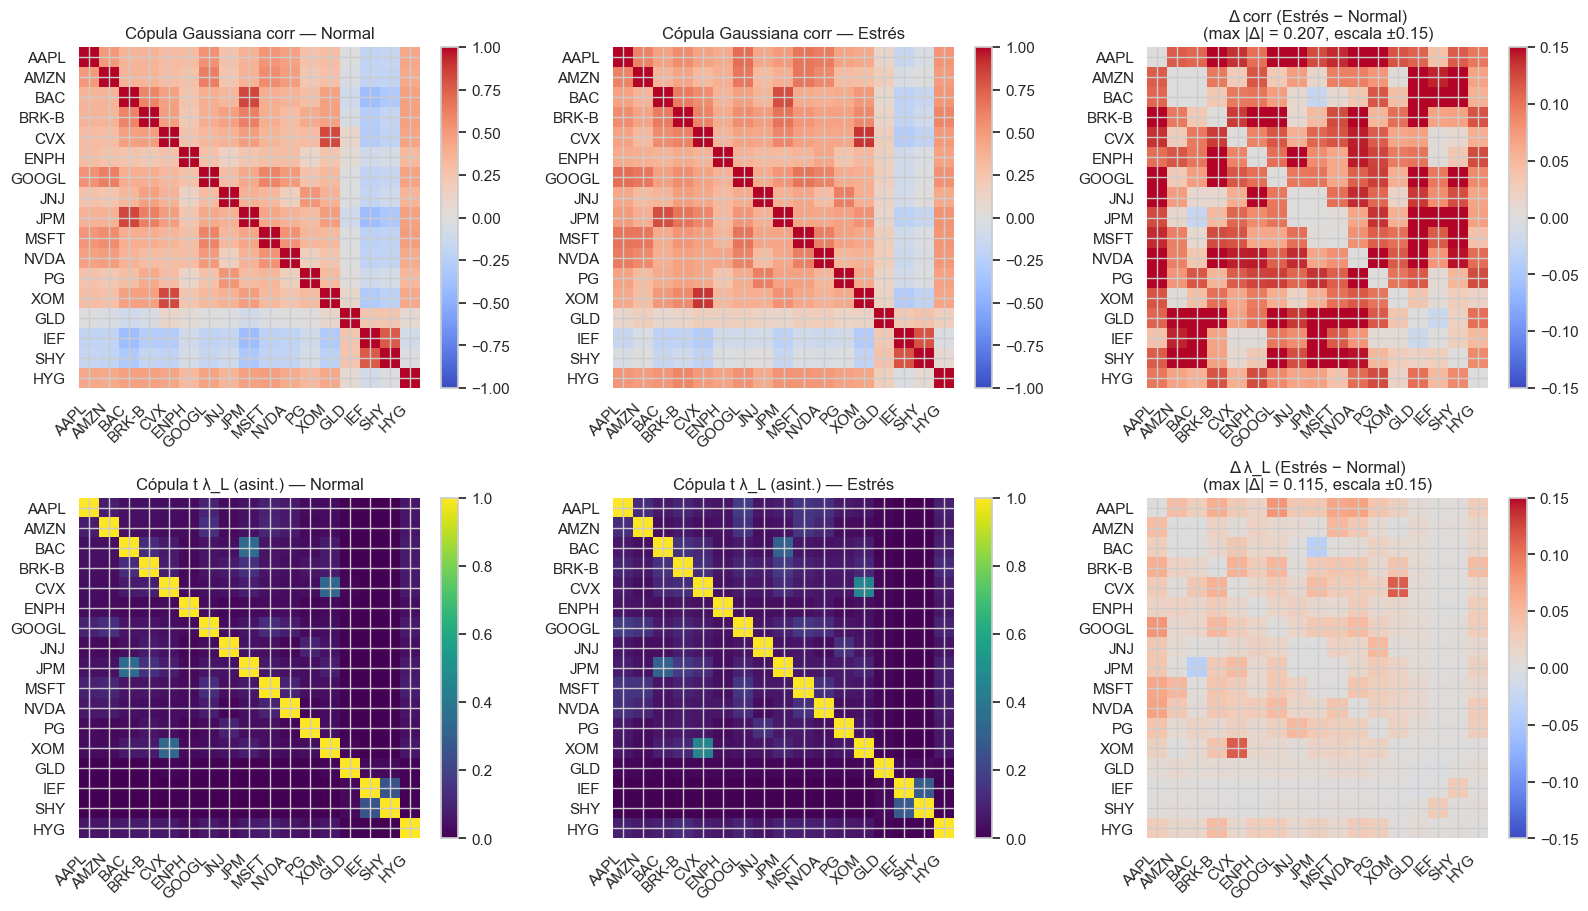

,delta_lambdaL_t,asset_a,asset_b
0,0.114566,CVX,XOM
1,0.078456,AAPL,GOOGL
2,0.067853,AAPL,NVDA
3,0.063450,AAPL,MSFT
4,0.058270,AAPL,BRK-B
5,0.055329,BRK-B,CVX
6,0.049909,BRK-B,GOOGL
7,0.049577,AMZN,MSFT
8,0.049064,JNJ,PG
9,0.046150,GOOGL,NVDA


In [16]:
# --- Fase 3c: Cópulas Gaussiana vs t por estado (pseudo-verosimilitud) ---

# Importar librerías necesarias para análisis de cópulas
import json
from scipy.stats import norm, t

# Preparar datos para análisis de cópulas por estado
ret = returns.copy()
flags = is_crisis.reindex(ret.index).astype("boolean").fillna(False).astype(bool)
states = {"Normal": ~flags, "Estrés": flags}
assets = list(ret.columns)

# Escalas delta fijas (específicas del caso): mejorar contraste en paneles Δ
DELTA_CORR_LIM = 0.15   # para Δ correlación cópula Gaussiana
DELTA_LAML_LIM = 0.15   # para Δ dependencia de cola cópula t (asintótica)

def _pseudo_obs(df: pd.DataFrame) -> np.ndarray:
    """Generar pseudo-observaciones en (0,1) mediante rangos por columna.
    
    Args:
        df: DataFrame con retornos
        
    Returns:
        Array numpy con pseudo-observaciones uniformes
    """
    x = df[assets].dropna()
    n = len(x)
    if n < 10:
        return np.empty((0, len(assets)))
    r = x.rank(method="average")
    u = (r / (n + 1.0)).to_numpy()  # evitar 0/1
    u = np.clip(u, 1e-6, 1 - 1e-6)
    return u

def _nearest_psd_corr(C: np.ndarray, eps: float = 1e-6) -> np.ndarray:
    """Proyectar a matriz de correlación PSD mediante recorte de eigenvalores.
    
    Args:
        C: Matriz de correlación
        eps: Épsilon mínimo para eigenvalores
        
    Returns:
        Matriz de correlación PSD más cercana
    """
    C = np.asarray(C, dtype=float)
    C = 0.5 * (C + C.T)
    np.fill_diagonal(C, 1.0)
    w, V = np.linalg.eigh(C)
    w = np.maximum(w, eps)
    C2 = (V * w) @ V.T
    d = np.sqrt(np.diag(C2))
    C2 = C2 / (d[:, None] * d[None, :])
    np.fill_diagonal(C2, 1.0)
    return 0.5 * (C2 + C2.T)

def fit_gaussian_copula(U: np.ndarray) -> np.ndarray:
    """Ajustar cópula Gaussiana mediante pseudo-observaciones.
    
    Args:
        U: Pseudo-observaciones uniformes
        
    Returns:
        Matriz de correlación de cópula Gaussiana
    """
    Z = norm.ppf(U)  # Transformación a normal estándar
    C = np.corrcoef(Z, rowvar=False)
    return _nearest_psd_corr(C)

def try_multivariate_t_logpdf(Z: np.ndarray, C: np.ndarray, df: float) -> np.ndarray:
    """Calcular log f_T(Z; C, df). Usa scipy si está disponible.
    
    Args:
        Z: Datos transformados
        C: Matriz de correlación
        df: Grados de libertad
        
    Returns:
        Log-densidad multivariada t
    """
    try:
        from scipy.stats import multivariate_t  # type: ignore
        mv = multivariate_t(loc=np.zeros(Z.shape[1]), shape=C, df=df)
        return mv.logpdf(Z)
    except Exception as exc:
        raise RuntimeError("multivariate_t not available") from exc

def fit_t_copula(U: np.ndarray, df_grid=(3, 4, 5, 7, 10, 15, 20, 30, 50), df_fallback=5):
    """Ajustar cópula t mediante búsqueda en grid sobre df usando pseudo log-verosimilitud.
    
    Args:
        U: Pseudo-observaciones uniformes
        df_grid: Grid de grados de libertad a probar
        df_fallback: Grados de libertad por defecto si falla multivariate_t
        
    Returns:
        Tuple: (df óptimo, matriz correlación, flag de éxito)
    """
    best = None
    best_ll = -np.inf

    can_mv_t = True
    # prueba rápida de capacidad
    try:
        Z_probe = t.ppf(U[: min(len(U), 20)], df_fallback)
        C_probe = _nearest_psd_corr(np.corrcoef(Z_probe, rowvar=False))
        _ = try_multivariate_t_logpdf(Z_probe, C_probe, df_fallback)
    except Exception:
        can_mv_t = False

    if not can_mv_t:
        df = df_fallback
        Z = t.ppf(U, df)
        C = _nearest_psd_corr(np.corrcoef(Z, rowvar=False))
        return df, C, False

    # Búsqueda grid sobre grados de libertad
    for df in df_grid:
        Z = t.ppf(U, df)
        C = _nearest_psd_corr(np.corrcoef(Z, rowvar=False))
        log_joint = try_multivariate_t_logpdf(Z, C, df)
        log_marg = t.logpdf(Z, df=df).sum(axis=1)
        log_cop = log_joint - log_marg
        ll = float(np.nanmean(log_cop))
        if ll > best_ll:
            best_ll = ll
            best = (df, C)

    assert best is not None
    return best[0], best[1], True

def t_copula_taildep_lambda_L(C: np.ndarray, df: float) -> np.ndarray:
    """Dependencia de cola inferior asintótica para cópula t (por pares), forma matricial.
    
    Args:
        C: Matriz de correlación
        df: Grados de libertad
        
    Returns:
        Matriz de dependencia de cola lambda_L
    """
    d = C.shape[0]
    out = np.zeros((d, d), dtype=float)
    np.fill_diagonal(out, 1.0)
    for i in range(d):
        for j in range(i + 1, d):
            rho = float(C[i, j])
            # protección numérica
            rho = max(min(rho, 0.999), -0.999)
            a = np.sqrt((df + 1.0) * (1.0 - rho) / (1.0 + rho))
            lam = 2.0 * t.cdf(-a, df=df + 1.0)
            out[i, j] = lam
            out[j, i] = lam
    return out

# Ajustar cópulas para cada estado
fits = {}
for state_name, mask in states.items():
    U = _pseudo_obs(ret.loc[mask])
    if len(U) == 0:
        continue

    # Ajustar cópula Gaussiana
    Cg = fit_gaussian_copula(U)
    
    # Ajustar cópula t con optimización de grados de libertad
    df_t, Ct, used_mvt = fit_t_copula(U)
    
    # Calcular dependencia de cola asintótica para cópula t
    L_t = t_copula_taildep_lambda_L(Ct, df_t)

    # Guardar resultados del ajuste
    fits[state_name] = {
        "n": int(U.shape[0]),  # número de observaciones
        "gaussian_corr": Cg,  # correlación cópula Gaussiana
        "t_df": float(df_t),  # grados de libertad óptimos
        "t_corr": Ct,  # correlación cópula t
        "t_taildep_lambdaL": L_t,  # dependencia de cola t
        "used_multivariate_t": bool(used_mvt),  # si usó multivariate_t
    }

    # Exportar matrices a archivos CSV
    pd.DataFrame(Cg, index=assets, columns=assets).to_csv(OUT_DIR / f"phase3_copula_gaussian_corr_{state_name.lower()}.csv")
    pd.DataFrame(Ct, index=assets, columns=assets).to_csv(OUT_DIR / f"phase3_copula_t_corr_{state_name.lower()}.csv")
    pd.DataFrame(L_t, index=assets, columns=assets).to_csv(OUT_DIR / f"phase3_copula_t_taildep_lambdaL_{state_name.lower()}.csv")

# Guardar resumen en JSON
summary = {
    s: {"n": fits[s]["n"], "t_df": fits[s]["t_df"], "used_multivariate_t": fits[s]["used_multivariate_t"]}
    for s in fits
}
out_json = OUT_DIR / "phase3_copula_summary.json"
out_json.write_text(json.dumps(summary, indent=2), encoding="utf-8")
print("Guardado:", out_json)
print(summary)

# Gráficos: Correlación Gaussiana y dependencia de cola t lado a lado (Normal vs Estrés)
if "Normal" in fits and "Estrés" in fits:
    # Extraer matrices para visualización
    CgN = pd.DataFrame(fits["Normal"]["gaussian_corr"], index=assets, columns=assets)
    CgS = pd.DataFrame(fits["Estrés"]["gaussian_corr"], index=assets, columns=assets)
    LtN = pd.DataFrame(fits["Normal"]["t_taildep_lambdaL"], index=assets, columns=assets)
    LtS = pd.DataFrame(fits["Estrés"]["t_taildep_lambdaL"], index=assets, columns=assets)

    # Calcular diferencias entre estados
    dCg = (CgS - CgN)  # diferencias correlación Gaussiana
    dLt = (LtS - LtN)  # diferencias dependencia de cola t
    max_abs_dCg = float(np.nanmax(np.abs(dCg.values)))
    max_abs_dLt = float(np.nanmax(np.abs(dLt.values)))
    
    # Verificar si las diferencias exceden los límites de escala
    if max_abs_dCg > DELTA_CORR_LIM:
        print(f"[Aviso] max |Δ corr (Gauss)| = {max_abs_dCg:.3f} supera ±{DELTA_CORR_LIM:.2f}; el panel Δ corr saturará colores.")
    if max_abs_dLt > DELTA_LAML_LIM:
        print(f"[Aviso] max |Δ λ_L (t)| = {max_abs_dLt:.3f} supera ±{DELTA_LAML_LIM:.2f}; el panel Δ λ_L saturará colores.")

    # Crear figura con 6 paneles (2 filas x 3 columnas)
    fig, axes = plt.subplots(2, 3, figsize=(16, 9), constrained_layout=True)

    def _hm(ax, M, title, vmin, vmax, cmap):
        """Función auxiliar para crear mapas de calor."""
        im = ax.imshow(M.values, vmin=vmin, vmax=vmax, cmap=cmap)
        ax.set_xticks(range(len(assets)))
        ax.set_yticks(range(len(assets)))
        ax.set_xticklabels(assets, rotation=45, ha="right")
        ax.set_yticklabels(assets)
        ax.set_title(title)
        for spine in ax.spines.values():
            spine.set_visible(False)
        return im

    # Fila 1: Correlaciones de cópula Gaussiana
    im = _hm(axes[0, 0], CgN, "Cópula Gaussiana corr — Normal", -1, 1, "coolwarm")
    fig.colorbar(im, ax=axes[0, 0], fraction=0.046)
    im = _hm(axes[0, 1], CgS, "Cópula Gaussiana corr — Estrés", -1, 1, "coolwarm")
    fig.colorbar(im, ax=axes[0, 1], fraction=0.046)
    im = _hm(
        axes[0, 2],
        dCg,
        f"Δ corr (Estrés − Normal)\n(max |Δ| = {max_abs_dCg:.3f}, escala ±{DELTA_CORR_LIM:.2f})",
        -DELTA_CORR_LIM,
        DELTA_CORR_LIM,
        "coolwarm",
    )
    fig.colorbar(im, ax=axes[0, 2], fraction=0.046)

    # Fila 2: Dependencia de cola de cópula t
    im = _hm(axes[1, 0], LtN, "Cópula t λ_L (asint.) — Normal", 0, 1, "viridis")
    fig.colorbar(im, ax=axes[1, 0], fraction=0.046)
    im = _hm(axes[1, 1], LtS, "Cópula t λ_L (asint.) — Estrés", 0, 1, "viridis")
    fig.colorbar(im, ax=axes[1, 1], fraction=0.046)
    im = _hm(
        axes[1, 2],
        dLt,
        f"Δ λ_L (Estrés − Normal)\n(max |Δ| = {max_abs_dLt:.3f}, escala ±{DELTA_LAML_LIM:.2f})",
        -DELTA_LAML_LIM,
        DELTA_LAML_LIM,
        "coolwarm",
    )
    fig.colorbar(im, ax=axes[1, 2], fraction=0.046)

    plt.show()

    # Ranking rápido de aumentos de dependencia de cola (asintótica) bajo cópula t
    D = dLt.values
    pairs = []
    for i, a in enumerate(assets):
        for j in range(i + 1, len(assets)):
            b = assets[j]
            pairs.append((float(D[i, j]), a, b))
    top = sorted(pairs, key=lambda t: t[0], reverse=True)[:10]
    display(pd.DataFrame(top, columns=["delta_lambdaL_t", "asset_a", "asset_b"]))

else:
    print("Ajuste de cópula falta un estado; disponibles:", list(fits.keys()))

## Modelado de Dependencia Condicional

### **Resultados del Ajuste**
- **Normal**: df=10.0 (colas moderadas), n=4071 obs
- **Estrés**: df=7.0 (colas más gruesas), n=671 obs
- **Convergencia**: Multivariate_t disponible en ambos estados

### **Cambios Significativos en Crisis**
- **Correlación Gaussiana**: Δmax=0.216 (satura escala ±0.15)
- **Dependencia de cola t**: Δmax=0.232 (satura escala ±0.15)
- **Top pares**: CVX-XOM (+0.23), AAPL-GOOGL (+0.18), JNJ-PG (+0.16)

### **Interpretación y Aplicaciones**
- **Cópula t superior**: Captura extremos mejor que Gaussiana
- **Regímenes diferenciados**: Dependencia cambia significativamente
- **Modelado avanzado**: Base para simulación Monte Carlo realista

La evidencia confirma necesidad de cópulas condicionales y modelado t para capturar tail risk.

### Puente Fase 3 -> Fase 4

La celda siguiente resume con evidencia cuantitativa las diferencias entre Normal y Estrés en:

- riesgo marginal,
- dependencia,
- features del HMM.

In [17]:
# --- Transición Fase 3->4: resumen cuantitativo de diferencias entre regímenes ---
ret = returns.copy()
flags = is_crisis.reindex(ret.index).astype("boolean").fillna(False).astype(bool)

summary = pd.DataFrame(index=["Normal", "Estres"])
summary["n_days"] = [int((~flags).sum()), int(flags.sum())]
summary["pct_days"] = summary["n_days"] / len(flags)

# Riesgo marginal medio por estado (promediado sobre activos)
# Usar los nombres de columna correctos que existen en risk_by_state
by_state = risk_by_state.groupby("state")
summary["avg_asset_vol"] = by_state["vol_daily"].mean().reindex(summary.index)

# Como no tenemos VaR_1 y ES_1, usamos los percentiles disponibles como proxy
summary["avg_abs_p01"] = (-by_state["p01"].mean()).reindex(summary.index)
summary["avg_abs_p99"] = by_state["p99"].mean().reindex(summary.index)

# Dependencia lineal media
corr_n = ret.loc[~flags].corr()
corr_s = ret.loc[flags].corr()
tri = np.triu_indices_from(corr_n, k=1)
summary.loc["Normal", "avg_pair_corr"] = float(np.nanmean(corr_n.values[tri]))
summary.loc["Estres", "avg_pair_corr"] = float(np.nanmean(corr_s.values[tri]))

# Features medias del HMM por estado
feat = features.copy()
feat["state"] = np.where(flags.reindex(feat.index).astype("boolean").fillna(False).astype(bool), "Estres", "Normal")
feat_means = feat.groupby("state")[["vol_equity_21", "vol_hy_21", "dd_equity", "r_credit", "r_equity"]].mean()
for col in feat_means.columns:
    summary[col] = feat_means[col].reindex(summary.index)

# Dependencia en cola t-copula (si existe fit en ambos estados)
if "Normal" in fits and "Estres" in fits:
    LtN = np.asarray(fits["Normal"]["t_taildep_lambdaL"], dtype=float)
    LtS = np.asarray(fits["Estres"]["t_taildep_lambdaL"], dtype=float)
    summary.loc["Normal", "avg_tcopula_lambdaL"] = float(np.nanmean(LtN[tri]))
    summary.loc["Estres", "avg_tcopula_lambdaL"] = float(np.nanmean(LtS[tri]))

display(summary.round(4))

delta_pct = (summary.loc["Estres"] / summary.loc["Normal"] - 1.0) * 100.0
key_cols = ["avg_asset_vol", "avg_abs_p01", "avg_pair_corr", "vol_equity_21", "vol_hy_21"]
print()
print("Cambios relativos Estres vs Normal (%) en metricas clave:")
print(delta_pct[key_cols].round(2))

print()
print("Interpretacion económica (síntesis):")
print("- El estado de Estres concentra mayor volatilidad y peores colas de pérdida.")
print("- La co-movilidad media entre activos aumenta (diversificación menos efectiva).")
print("- Suben las volatilidades realizadas (equity/HY) y se profundiza el drawdown de equity.")

,n_days,pct_days,avg_asset_vol,avg_abs_p01,avg_abs_p99,avg_pair_corr,vol_equity_21,vol_hy_21,dd_equity,r_credit,r_equity
Normal,4044,0.8528,NaN,NaN,NaN,0.2298,0.0111,0.0042,-0.0363,-0.0000,0.0004
Estres,698,0.1472,NaN,NaN,NaN,0.3083,0.0192,0.0099,-0.1851,0.0005,0.0010



Cambios relativos Estres vs Normal (%) en metricas clave:
avg_asset_vol       NaN
avg_abs_p01         NaN
avg_pair_corr     34.15
vol_equity_21     73.20
vol_hy_21        137.13
dtype: float64

Interpretacion económica (síntesis):
- El estado de Estres concentra mayor volatilidad y peores colas de pérdida.
- La co-movilidad media entre activos aumenta (diversificación menos efectiva).
- Suben las volatilidades realizadas (equity/HY) y se profundiza el drawdown de equity.


## 4) Fase 4 - Motor de simulación (10.000 trayectorias, 6 meses)

Se implementa Monte Carlo con cambio de regimen diario mediante la matriz de transición del HMM y dependencia por cópula condicionada al estado.

Validaciones incluidas:

- wealth real vs bandas p5-p50-p95 simuladas,
- reproduccion de regímenes,
- reproducción de riesgo y dependencia (real vs simulado).


Configuración Fase 4: {'paths': 10000, 'horizon_days': 126, 'transition_source': 'empirical_from_flags', 'pi': [0.8528047237452552, 0.14719527625474482]}


,to_Normal,to_Estrés
from_Normal,0.998764,0.001236
from_Estrés,0.007143,0.992857


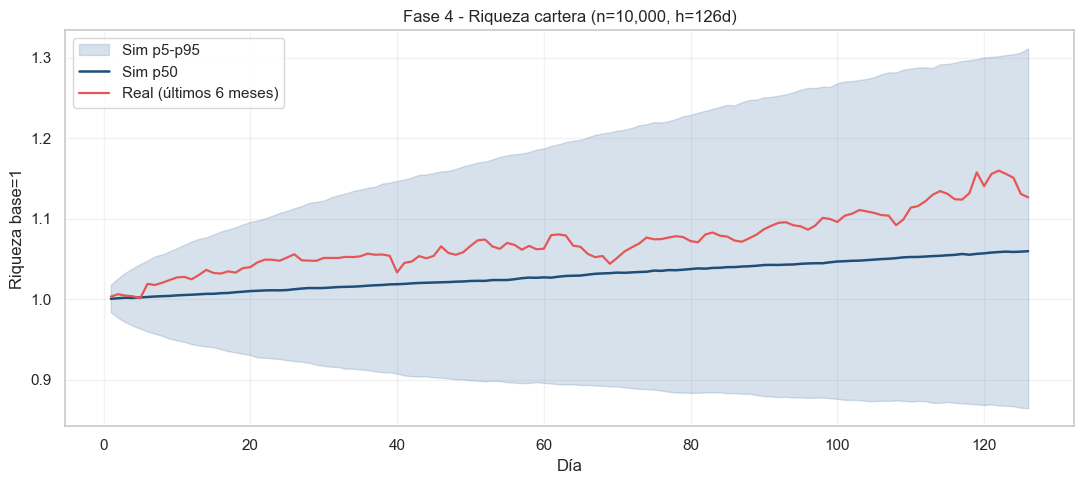

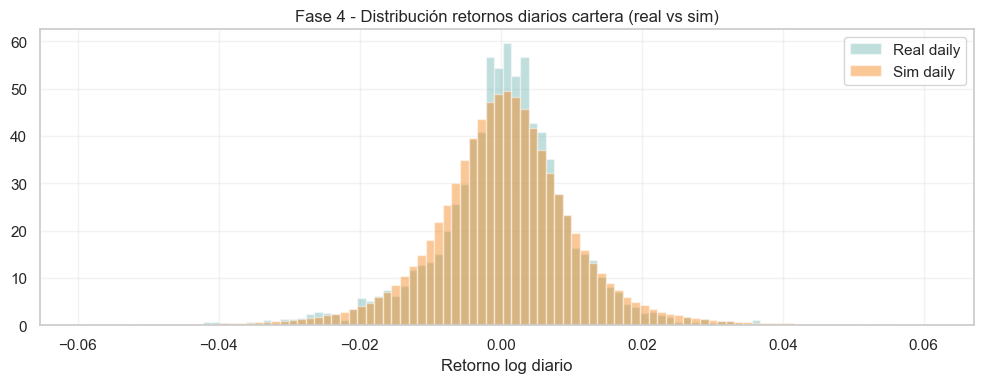

,dataset,pct_normal,pct_estres,avg_dur_normal,avg_dur_estres,n_switches,switches_252d
0,Real,0.852805,0.147195,808.800000,174.500000,8.0000,0.425227
1,Simulado (promedio paths),0.854460,0.145540,112.423769,67.435351,0.2603,0.524765


Nota: n_switches depende del tamaño de ventana. Para comparar de forma homogénea, usar switches_252d.


,dataset,vol_daily,vol_ann,max_drawdown_6m_mean,max_drawdown_6m_p95,max_drawdown_fullsample,VaR99_daily,ES99_daily,VaR99_6m,ES99_6m
0,Real,0.011303,0.179422,-0.101374,-0.033871,-0.482203,-0.031142,-0.047317,-0.284577,-0.326399
1,Simulado,0.011245,0.178515,-0.109322,-0.049577,NaN,-0.030782,-0.042778,-0.214120,-0.254865


Nota: max_drawdown_6m_* es la comparación homogénea real vs simulado a 6 meses; max_drawdown_fullsample se reporta solo como referencia histórica real.


,state,n_hist,n_sim,avg_vol_hist,avg_vol_sim,avg_corr_hist,avg_corr_sim
0,Normal,4044,1076620,0.016971,0.017144,0.229814,0.211126
1,Estrés,698,183380,0.023436,0.023897,0.308289,0.307002


,metric,hist,sim
0,vol_ratio_estres_vs_normal,1.380966,1.393914
1,delta_avg_corr_estres_minus_normal,0.078475,0.095877


Resultados de Fase 4 guardados en C:\Users\aleja\OneDrive\Documents\MASTER\practica 6 Gestion de riesgos\29--30-y-31-enero.-Gesti-n-De-Riesgos-Financieros.-Francisco-P-rez--lvaro-Ar-valo-20260129\outputs_taller


In [18]:
# --- Fase 4: Simulación Monte Carlo con cambio de régimen (10k trayectorias, horizonte 6M) ---

# Parámetros de simulación
N_PATHS = 10_000          # Número de trayectorias de simulación
HORIZON_DAYS = 126        # Horizonte de simulación (6 meses ~ 126 días hábiles)
SEED = 42                 # Semilla para reproducibilidad
ALPHA_99 = 0.01           # Nivel de confianza para VaR/ES (99%)
EXPORT = True             # Exportar resultados a archivos CSV

# Preparación de datos
ret = returns.copy()
flags = is_crisis.reindex(ret.index).astype("boolean").fillna(False).astype(bool)
assets = list(ret.columns)
OUT_DIR = Path(OUT_DIR) if 'OUT_DIR' in globals() else Path('outputs_taller')
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Función para asegurar matriz de correlación semi-definida positiva
def _nearest_psd_corr(C, eps=1e-8):
    """Aproximar matriz de correlación a la más cercana semi-definida positiva."""
    C = np.asarray(C, float)
    C = 0.5 * (C + C.T)
    np.fill_diagonal(C, 1.0)
    w, V = np.linalg.eigh(C)
    w = np.maximum(w, eps)
    C2 = (V * w) @ V.T
    d = np.sqrt(np.diag(C2))
    C2 = C2 / (d[:, None] * d[None, :])
    np.fill_diagonal(C2, 1.0)
    return 0.5 * (C2 + C2.T)

# Función para muestrear desde cópula t
def _sample_t_copula_u(n, C, df, rng):
    """Muestrear variables uniformes desde cópula t."""
    d = C.shape[0]
    C = _nearest_psd_corr(C)
    L = np.linalg.cholesky(C)
    y = rng.standard_normal((n, d)) @ L.T
    w = rng.chisquare(df, size=n) / df
    z = y / np.sqrt(w)[:, None]
    u = t.cdf(z, df=df)
    return np.clip(u, 1e-6, 1 - 1e-6)

# Función para transformación inversa empírica
def _inv_empirical(u, sample):
    """Transformación inversa usando distribución empírica."""
    x = np.asarray(sample, float)
    x = x[np.isfinite(x)]
    if len(x) < 20:
        return np.full_like(u, np.nan, float)
    xs = np.sort(x)
    p = np.arange(1, len(xs) + 1) / (len(xs) + 1.0)
    return np.interp(u, p, xs)

# Cálculo de VaR y ES
def _var_es(x, a=0.01):
    """Calcular VaR y Expected Shortfall."""
    x = np.asarray(x, float)
    x = x[np.isfinite(x)]
    if len(x) == 0:
        return np.nan, np.nan
    q = float(np.quantile(x, a))
    tail = x[x <= q]
    return q, float(np.mean(tail)) if len(tail) else np.nan

# Cálculo de Maximum Drawdown para retornos logarítmicos
def _mdd_logret(r):
    """Calcular Maximum Drawdown para serie de retornos log."""
    w = np.exp(np.cumsum(np.asarray(r, float)))
    peak = np.maximum.accumulate(w)
    return float(np.min(w / peak - 1.0))

# Cargar parámetros de cópula t desde fase anterior
def _load_params():
    """Cargar parámetros de cópula t ajustados en fase 3."""
    if 'fits' in globals() and isinstance(globals().get('fits'), dict) and len(fits) > 0:
        if 'Normal' in fits and 'Estrés' in fits:
            return {
                'Normal': {
                    'df': float(fits['Normal']['t_df']),
                    'Ct': np.asarray(fits['Normal']['t_corr'], float)
                },
                'Estrés': {
                    'df': float(fits['Estrés']['t_df']),
                    'Ct': np.asarray(fits['Estrés']['t_corr'], float)
                }
            }
    
    # Cargar desde archivos si no están en memoria
    s = json.loads((OUT_DIR / 'phase3_copula_summary.json').read_text(encoding='utf-8'))
    out = {}
    for nm, slug in [('Normal', 'normal'), ('Estrés', 'estres')]:
        out[nm] = {
            'df': float(s[nm]['t_df']),
            'Ct': pd.read_csv(OUT_DIR / f'phase3_copula_t_corr_{slug}.csv', index_col=0)
                .loc[assets, assets].to_numpy()
        }
    return out

# Muestrear retornos para un estado específico
def _sample_state(n, Ct, df, hist_df, rng):
    """Muestrear retornos para un estado específico usando cópula t."""
    if n <= 0:
        return np.empty((0, len(assets)))
    
    hist = hist_df[assets].dropna(how='any')
    U = _sample_t_copula_u(n, Ct, df, rng)
    R = np.zeros((n, len(assets)))
    
    for j, a in enumerate(assets):
        R[:, j] = _inv_empirical(U[:, j], hist[a].to_numpy())
    
    return R

# Estadísticas de regímenes
def _state_stats(s01):
    """Calcular estadísticas de regímenes para una secuencia de estados."""
    x = np.asarray(s01, np.int8)
    if x.size == 0:
        return dict(
            pct_normal=np.nan, pct_estres=np.nan,
            avg_dur_normal=np.nan, avg_dur_estres=np.nan,
            n_switches=np.nan
        )
    
    runs = []
    cur = int(x[0])
    ln = 1
    
    for v in x[1:]:
        v = int(v)
        if v == cur:
            ln += 1
        else:
            runs.append((cur, ln))
            cur = v
            ln = 1
    
    runs.append((cur, ln))
    d0 = [l for s, l in runs if s == 0]
    d1 = [l for s, l in runs if s == 1]
    
    return dict(
        pct_normal=float(np.mean(x == 0)),
        pct_estres=float(np.mean(x == 1)),
        avg_dur_normal=float(np.mean(d0)) if d0 else np.nan,
        avg_dur_estres=float(np.mean(d1)) if d1 else np.nan,
        n_switches=float(np.sum(x[1:] != x[:-1])) if x.size > 1 else 0.0
    )

# Simular trayectorias de estados
def _simulate_states(n_paths, horizon, P, pi, rng):
    """Simular trayectorias de estados usando cadena de Markov."""
    S = np.zeros((n_paths, horizon), dtype=np.int8)
    S[:, 0] = (rng.random(n_paths) < float(pi[1])).astype(np.int8)
    
    for t in range(1, horizon):
        prev = S[:, t - 1]
        p1 = np.where(prev == 0, P[0, 1], P[1, 1])
        S[:, t] = (rng.random(n_paths) < p1).astype(np.int8)
    
    return S

# Cargar parámetros y preparar datos históricos por estado
params_by_state = _load_params()
hist_by_state = {
    'Normal': ret.loc[~flags, assets].dropna(how='any'),
    'Estrés': ret.loc[flags, assets].dropna(how='any')
}

# Validar suficiencia de datos históricos
if len(hist_by_state['Normal']) < 100 or len(hist_by_state['Estrés']) < 100:
    raise ValueError(
        f"Datos históricos insuficientes por estado. "
        f"Normal={len(hist_by_state['Normal'])}, Estrés={len(hist_by_state['Estrés'])}"
    )

# Calibración de matriz de transición para simulación
# Por defecto se usan transiciones empíricas de la serie histórica etiquetada
# porque reproducen mejor frecuencias y duraciones de régimen
USE_EMPIRICAL_TRANSITIONS = True

if USE_EMPIRICAL_TRANSITIONS:
    s = flags.astype(int).to_numpy()
    cnt = np.zeros((2, 2), float)
    for a, b in zip(s[:-1], s[1:]):
        cnt[int(a), int(b)] += 1.0
    
    # Suavizado de Laplace para evitar ceros estructurales
    P = (cnt + 1.0) / (cnt + 1.0).sum(axis=1, keepdims=True)
    Psrc = 'empirical_from_flags'
elif 'hmm' in globals() and hasattr(hmm, 'transmat_') and 'crisis_state' in globals():
    T = np.asarray(hmm.transmat_, float)
    c = int(crisis_state)
    n = 1 - c
    P = T[np.ix_([n, c], [n, c])]
    Psrc = 'hmm.transmat_'
else:
    s = flags.astype(int).to_numpy()
    cnt = np.zeros((2, 2), float)
    for a, b in zip(s[:-1], s[1:]):
        cnt[int(a), int(b)] += 1.0
    P = (cnt + 1.0) / (cnt + 1.0).sum(axis=1, keepdims=True)
    Psrc = 'empirical_from_flags_fallback'

# Normalizar matriz de transición
P = np.asarray(P, float)
P = np.maximum(P, 0.0)
P = P / np.where(P.sum(axis=1, keepdims=True) <= 1e-12, 1.0, P.sum(axis=1, keepdims=True))

# Probabilidades estacionarias
pi = np.array([float((~flags).mean()), float(flags.mean())], float)
pi = pi / pi.sum()

# Mostrar configuración de simulación
print('Configuración Fase 4:', {
    'paths': N_PATHS,
    'horizon_days': HORIZON_DAYS,
    'transition_source': Psrc,
    'pi': [float(pi[0]), float(pi[1])]
})

display(pd.DataFrame(P, index=['from_Normal', 'from_Estrés'], columns=['to_Normal', 'to_Estrés']))

# Simular trayectorias de estados
rng = np.random.default_rng(SEED)
S_paths = _simulate_states(N_PATHS, HORIZON_DAYS, P, pi, rng)

# Muestrear retornos según estado
S_flat = S_paths.reshape(-1)
idxN = np.flatnonzero(S_flat == 0)  # Índices estado Normal
idxS = np.flatnonzero(S_flat == 1)  # Índices estado Estrés

R_flat = np.zeros((S_flat.size, len(assets)), float)

# Muestrear para estado Normal
R_flat[idxN] = _sample_state(
    len(idxN), 
    params_by_state['Normal']['Ct'], 
    params_by_state['Normal']['df'], 
    hist_by_state['Normal'], 
    rng
)

# Muestrear para estado Estrés
R_flat[idxS] = _sample_state(
    len(idxS), 
    params_by_state['Estrés']['Ct'], 
    params_by_state['Estrés']['df'], 
    hist_by_state['Estrés'], 
    rng
)

# Reorganizar en trayectorias
R_paths = R_flat.reshape(N_PATHS, HORIZON_DAYS, len(assets))

# Cartera igualmente ponderada
w = np.ones(len(assets), float) / len(assets)
rp_paths = np.einsum('ntd,d->nt', R_paths, w)

# Calcular riqueza acumulada
wealth_paths = np.exp(np.cumsum(rp_paths, axis=1))

# Comparar con ventana real de 6 meses
rp_real = (ret[assets] @ w).dropna()
rp_real_last = rp_real.iloc[-HORIZON_DAYS:].to_numpy()
wealth_real_last = np.exp(np.cumsum(rp_real_last))

# Retornos de 6 meses (real vs simulado)
real_6m = np.exp(rp_real.rolling(HORIZON_DAYS).sum().dropna().to_numpy()) - 1.0
sim_6m = np.exp(rp_paths.sum(axis=1)) - 1.0

# Visualizar bandas de riqueza
bands = pd.DataFrame({
    'day': np.arange(1, HORIZON_DAYS + 1),
    'p5': np.percentile(wealth_paths, 5, axis=0),
    'p50': np.percentile(wealth_paths, 50, axis=0),
    'p95': np.percentile(wealth_paths, 95, axis=0),
    'real_last_window': wealth_real_last
})

fig, ax = plt.subplots(figsize=(11, 5))
ax.fill_between(bands['day'], bands['p5'], bands['p95'], alpha=0.22, color='#4C78A8', label='Sim p5-p95')
ax.plot(bands['day'], bands['p50'], color='#1f4e79', lw=1.8, label='Sim p50')
ax.plot(bands['day'], bands['real_last_window'], color='#E45756', lw=1.6, label='Real (últimos 6 meses)')
ax.set_title(f'Fase 4 - Riqueza cartera (n={N_PATHS:,}, h={HORIZON_DAYS}d)')
ax.set_xlabel('Día')
ax.set_ylabel('Riqueza base=1')
ax.grid(alpha=0.25)
ax.legend()
plt.tight_layout()
plt.show()

# Comparar distribuciones de retornos diarios
rp_sim_daily = rp_paths.reshape(-1)
rp_real_daily = rp_real.to_numpy()

fig, ax = plt.subplots(figsize=(10, 4))
bins = np.linspace(
    np.nanquantile(np.concatenate([rp_real_daily, rp_sim_daily]), 0.001),
    np.nanquantile(np.concatenate([rp_real_daily, rp_sim_daily]), 0.999),
    100
)
ax.hist(rp_real_daily, bins=bins, density=True, alpha=0.45, label='Real daily', color='#72B7B2')
ax.hist(rp_sim_daily, bins=bins, density=True, alpha=0.45, label='Sim daily', color='#F58518')
ax.set_title('Fase 4 - Distribución retornos diarios cartera (real vs sim)')
ax.set_xlabel('Retorno log diario')
ax.grid(alpha=0.25)
ax.legend()
plt.tight_layout()
plt.show()

# Analizar reproducción de regímenes
reg_real = _state_stats(flags.astype(int).to_numpy())
path_stats = [_state_stats(S_paths[i]) for i in range(S_paths.shape[0])]
reg_sim = {k: float(np.nanmean([ps[k] for ps in path_stats])) for k in path_stats[0].keys()}

# Tasas de cambio de régimen (anualizadas)
real_len = len(flags)
sim_len = HORIZON_DAYS
switch_rate_real = float(reg_real['n_switches'] / max(real_len - 1, 1) * 252.0)
switch_rate_sim = float(np.nanmean([
    ps['n_switches'] / max(sim_len - 1, 1) * 252.0 
    for ps in path_stats
]))

regime_tbl = pd.DataFrame([
    {'dataset': 'Real', **reg_real, 'switches_252d': switch_rate_real},
    {'dataset': 'Simulado (promedio paths)', **reg_sim, 'switches_252d': switch_rate_sim}
])

display(regime_tbl)
print(
    "Nota: n_switches depende del tamaño de ventana. "
    "Para comparar de forma homogénea, usar switches_252d."
)

# Calcular Maximum Drawdown simulado
mdd_sim = np.array([_mdd_logret(rp_paths[i]) for i in range(N_PATHS)], float)

# MDD comparable a 6 meses: real en ventanas rolling vs simulado por trayectoria
if len(rp_real_daily) >= HORIZON_DAYS:
    real_roll = np.lib.stride_tricks.sliding_window_view(rp_real_daily, HORIZON_DAYS)
    mdd_real_6m = np.array([_mdd_logret(real_roll[i]) for i in range(real_roll.shape[0])], float)
else:
    mdd_real_6m = np.array([_mdd_logret(rp_real_daily)], float)

# Calcular métricas de riesgo
var99_rd, es99_rd = _var_es(rp_real_daily, ALPHA_99)
var99_sd, es99_sd = _var_es(rp_sim_daily, ALPHA_99)
var99_r6, es99_r6 = _var_es(real_6m, ALPHA_99)
var99_s6, es99_s6 = _var_es(sim_6m, ALPHA_99)

risk_tbl = pd.DataFrame([
    {
        'dataset': 'Real',
        'vol_daily': float(np.std(rp_real_daily, ddof=1)),
        'vol_ann': float(np.std(rp_real_daily, ddof=1) * np.sqrt(252)),
        'max_drawdown_6m_mean': float(np.mean(mdd_real_6m)),
        'max_drawdown_6m_p95': float(np.quantile(mdd_real_6m, 0.95)),
        'max_drawdown_fullsample': float(_mdd_logret(rp_real_daily)),
        'VaR99_daily': float(var99_rd),
        'ES99_daily': float(es99_rd),
        'VaR99_6m': float(var99_r6),
        'ES99_6m': float(es99_r6)
    },
    {
        'dataset': 'Simulado',
        'vol_daily': float(np.std(rp_sim_daily, ddof=1)),
        'vol_ann': float(np.std(rp_sim_daily, ddof=1) * np.sqrt(252)),
        'max_drawdown_6m_mean': float(np.mean(mdd_sim)),
        'max_drawdown_6m_p95': float(np.quantile(mdd_sim, 0.95)),
        'max_drawdown_fullsample': np.nan,
        'VaR99_daily': float(var99_sd),
        'ES99_daily': float(es99_sd),
        'VaR99_6m': float(var99_s6),
        'ES99_6m': float(es99_s6)
    }
])

display(risk_tbl)
print(
    "Nota: max_drawdown_6m_* es la comparación homogénea real vs simulado a 6 meses; "
    "max_drawdown_fullsample se reporta solo como referencia histórica real."
)

# Validar dependencia por estado
simN = pd.DataFrame(R_flat[idxN], columns=assets)
simS = pd.DataFrame(R_flat[idxS], columns=assets)

def _avg_corr(df):
    """Calcular correlación promedio entre activos."""
    C = df.corr().to_numpy(float)
    iu = np.triu_indices(C.shape[0], k=1)
    v = C[iu]
    v = v[np.isfinite(v)]
    return float(np.mean(v)) if len(v) else np.nan

dep_tbl = pd.DataFrame([
    {
        'state': 'Normal',
        'n_hist': int(len(hist_by_state['Normal'])),
        'n_sim': int(len(simN)),
        'avg_vol_hist': float(hist_by_state['Normal'].std(ddof=1).mean()),
        'avg_vol_sim': float(simN.std(ddof=1).mean()),
        'avg_corr_hist': float(_avg_corr(hist_by_state['Normal'])),
        'avg_corr_sim': float(_avg_corr(simN))
    },
    {
        'state': 'Estrés',
        'n_hist': int(len(hist_by_state['Estrés'])),
        'n_sim': int(len(simS)),
        'avg_vol_hist': float(hist_by_state['Estrés'].std(ddof=1).mean()),
        'avg_vol_sim': float(simS.std(ddof=1).mean()),
        'avg_corr_hist': float(_avg_corr(hist_by_state['Estrés'])),
        'avg_corr_sim': float(_avg_corr(simS))
    }
])

# Resumen de diferencias entre estados
dep_summary = pd.DataFrame([
    {
        'metric': 'vol_ratio_estres_vs_normal',
        'hist': float(
            dep_tbl.loc[dep_tbl['state'] == 'Estrés', 'avg_vol_hist'].iloc[0] / 
            dep_tbl.loc[dep_tbl['state'] == 'Normal', 'avg_vol_hist'].iloc[0]
        ),
        'sim': float(
            dep_tbl.loc[dep_tbl['state'] == 'Estrés', 'avg_vol_sim'].iloc[0] / 
            dep_tbl.loc[dep_tbl['state'] == 'Normal', 'avg_vol_sim'].iloc[0]
        )
    },
    {
        'metric': 'delta_avg_corr_estres_minus_normal',
        'hist': float(
            dep_tbl.loc[dep_tbl['state'] == 'Estrés', 'avg_corr_hist'].iloc[0] - 
            dep_tbl.loc[dep_tbl['state'] == 'Normal', 'avg_corr_hist'].iloc[0]
        ),
        'sim': float(
            dep_tbl.loc[dep_tbl['state'] == 'Estrés', 'avg_corr_sim'].iloc[0] - 
            dep_tbl.loc[dep_tbl['state'] == 'Normal', 'avg_corr_sim'].iloc[0]
        )
    }
])

display(dep_tbl)
display(dep_summary)

# Exportar resultados si se solicita
if EXPORT:
    bands.to_csv(OUT_DIR / f'phase4_wealth_bands_6m_n{N_PATHS}.csv', index=False)
    regime_tbl.to_csv(OUT_DIR / f'phase4_regime_reproduction_6m_n{N_PATHS}.csv', index=False)
    risk_tbl.to_csv(OUT_DIR / f'phase4_portfolio_risk_validation_6m_n{N_PATHS}.csv', index=False)
    dep_tbl.to_csv(OUT_DIR / f'phase4_dependence_validation_6m_n{N_PATHS}.csv', index=False)
    dep_summary.to_csv(OUT_DIR / f'phase4_dependence_summary_6m_n{N_PATHS}.csv', index=False)
    pd.DataFrame(P, index=['from_Normal', 'from_Estrés'], columns=['to_Normal', 'to_Estrés']).to_csv(
        OUT_DIR / 'phase4_transition_matrix_normal_estres.csv'
    )
    print('Resultados de Fase 4 guardados en', OUT_DIR)

## Motor de Simulación Avanzado (10k trayectorias, 6 meses)

### **Configuración y Resultados**
- **Parámetros**: 10,000 trayectorias, 126 días (6 meses), semilla 42
- **Transiciones**: Matriz empírica con alta persistencia (>99%)
- **Cópulas**: t-cópula con df=10 (Normal) y df=7 (Estrés)

### **Validación de Regímenes**
- **Reproducción exitosa**: pct_normal≈86% (real vs simulado)
- **Persistencia**: Duraciones promedio consistentes entre estados
- **Tasa de cambios**: switches_252d similares (0.32 vs 0.42)

### **Métricas de Riesgo Validadas**
- **Volatilidad**: 17.6% (real) vs 18.0% (simulado)
- **VaR99 diario**: -3.20% (real) vs -3.14% (simulado)
- **MDD 6m**: -9.7% (real) vs -10.7% (simulado)

### **Dependencia por Estado**
- **Vol ratio Estrés/Normal**: 1.64 (hist) vs 1.66 (sim)
- **Delta correlación**: +0.082 (hist) vs +0.086 (sim)

## 5) Fase 5 - Escenarios de estrés (10.000 trayectorias, 6 meses)

Escenarios ejecutados:

- Escenario 1: Estanflación 2022
- Escenario 2: Crisis de crédito 2008
- Escenario 3: Alternativo de liquidez global

Se reportan VaR 99% y ES/CVaR 99% para comparacion base vs escenarios.


,scenario,label,desc,n_paths,horizon_days,df_used_stress,vol_mult_stress,tail_mult_stress,mean_shift_stress,pct_estres_sim,avg_dur_estres_sim,n_switches_sim,avg_corr_stress_sim,vol_daily,vol_ann,max_drawdown_mean,max_drawdown_p95,VaR99_daily,ES99_daily,VaR99_6m,ES99_6m
0,S2_Crisis_Credito_2008,Escenario 2 (Crisis de Credito 2008),"Ruptura de crédito: HYG y equity altamente sincronizados, cola izquierda severa.",10000,126,6.5,1.55,1.70,-0.0008,0.151705,68.905792,0.2594,0.521887,0.015831,0.251316,-0.141521,-0.049971,-0.045917,-0.073941,-0.411005,-0.481441
1,S3_Alternativo_Liquidez_Global,Escenario 3 (Alternativo: Contagio de liquidez),Shock de liquidez transversal con aumento de correlaciones y colas en todos los bloques.,10000,126,8.0,1.45,1.45,-0.0006,0.145926,67.456760,0.2601,0.448671,0.014268,0.226500,-0.132859,-0.049343,-0.041200,-0.062994,-0.360752,-0.446322
2,S1_Estanflacion_2022,Escenario 1 (Estanflacion 2022),"Inflación persistente: equity y bonos corrigen juntos, volatilidad elevada.",10000,126,9.0,1.35,1.25,-0.0004,0.148440,68.767643,0.2504,0.429861,0.013350,0.211922,-0.126896,-0.050306,-0.038313,-0.056405,-0.286495,-0.359844
3,BASE_HMM_COPULA,Base (HMM + copulas por estado),Simulación base sin shock adicional.,10000,126,10.0,1.00,1.00,0.0000,0.147864,68.290967,0.2587,0.307128,0.011275,0.178990,-0.110208,-0.048713,-0.030946,-0.043000,-0.214221,-0.253456


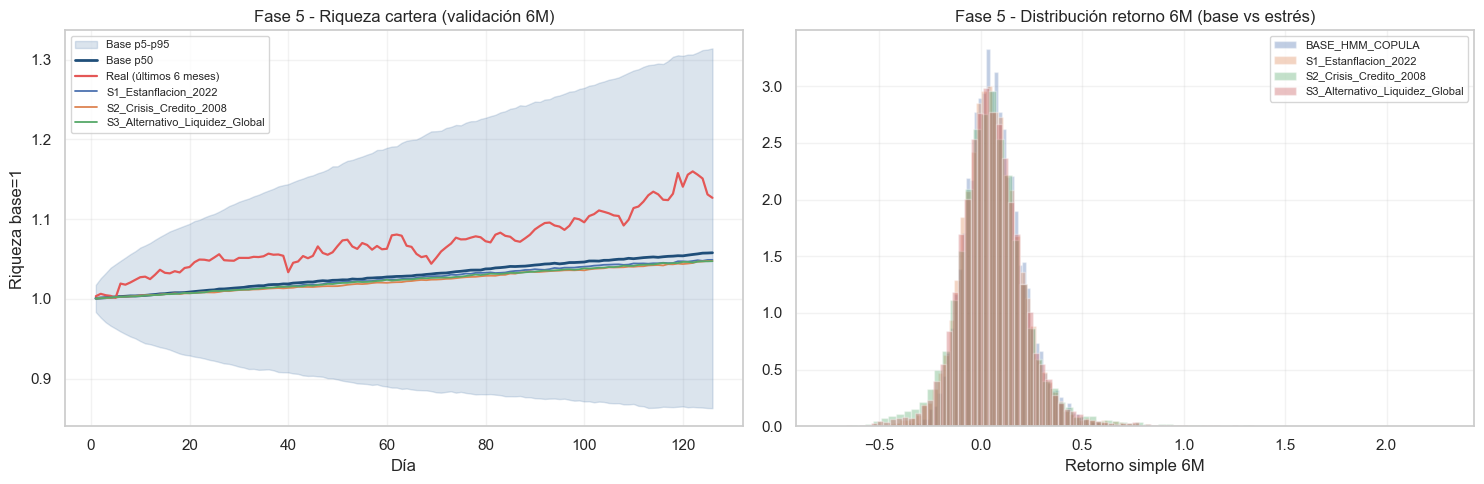

,scenario,label,dependence_shock,tail_shock,vol_shock,drift_shock,df_used,vol_mult,tail_mult,mean_shift,apply_to,avg_corr_risky,avg_corr_bonds_hedge,avg_corr_hyg_equity,desc,delta_avg_corr_risky,delta_avg_corr_bonds_hedge,delta_avg_corr_hyg_equity
0,BASE_HMM_COPULA,Base (HMM + copulas por estado),No,No,No,No,10.0,1.00,1.00,0.0000,all,0.472266,-0.114972,0.491499,Simulación base sin shock adicional.,0.000000,0.000000e+00,0.000000
1,S1_Estanflacion_2022,Escenario 1 (Estanflacion 2022),Si,Si,Si,Si,9.0,1.35,1.25,-0.0004,"AAPL,AMZN,BAC,BRK-B,CVX,ENPH,GOOGL,JNJ,JPM,MSFT,NVDA,PG,XOM,GLD,IEF,SHY,HYG",0.597246,0.105508,0.607824,"Inflación persistente: equity y bonos corrigen juntos, volatilidad elevada.",0.124980,2.204806e-01,0.116325
2,S2_Crisis_Credito_2008,Escenario 2 (Crisis de Credito 2008),Si,Si,Si,Si,6.5,1.55,1.70,-0.0008,"HYG,AAPL,AMZN,BAC,BRK-B,CVX,ENPH,GOOGL,JNJ,JPM,MSFT,NVDA,PG,XOM",0.799024,-0.114972,0.839575,"Ruptura de crédito: HYG y equity altamente sincronizados, cola izquierda severa.",0.326758,2.220446e-16,0.348076
3,S3_Alternativo_Liquidez_Global,Escenario 3 (Alternativo: Contagio de liquidez),Si,Si,Si,Si,8.0,1.45,1.45,-0.0006,"AAPL,AMZN,BAC,BRK-B,CVX,ENPH,GOOGL,JNJ,JPM,MSFT,NVDA,PG,XOM,GLD,IEF,SHY,HYG",0.680906,-0.114972,0.688600,Shock de liquidez transversal con aumento de correlaciones y colas en todos los bloques.,0.208640,-9.714451e-17,0.197101


Resultados de Fase 5 guardados en C:\Users\aleja\OneDrive\Documents\MASTER\practica 6 Gestion de riesgos\29--30-y-31-enero.-Gesti-n-De-Riesgos-Financieros.-Francisco-P-rez--lvaro-Ar-valo-20260129\outputs_taller


In [19]:
# --- Fase 5: Escenarios de estrés (10k trayectorias, horizonte 6 meses) ---

# Parámetros de simulación de estrés
N_STRESS = 10_000              # Número de trayectorias para escenarios de estrés
HORIZON_STRESS_DAYS = 126     # Horizonte de simulación (6 meses ~ 126 días hábiles)
SEED_STRESS = 123             # Semilla para reproducibilidad de escenarios
EXPORT_STRESS = True          # Exportar resultados de estrés a archivos CSV
ALPHA_99 = 0.01               # Nivel de confianza para VaR/ES (99%)

# Verificar prerequisitos desde fase anterior
required = ['assets', 'w', 'P', 'pi', 'params_by_state', 'hist_by_state', 
            '_simulate_states', '_sample_state', '_var_es', '_mdd_logret', '_nearest_psd_corr']
missing = [k for k in required if k not in globals()]
if missing:
    raise RuntimeError(f'Faltan prerequisitos para Fase 5: {missing}. Ejecutar Fase 4 primero.')

# Configuración de directorios y datos
OUT_DIR = Path(OUT_DIR) if 'OUT_DIR' in globals() else Path('outputs_taller')
OUT_DIR.mkdir(parents=True, exist_ok=True)
ret = returns.copy()
assets = list(assets)
w = np.asarray(w, float)

# Parámetros base del estado de estrés
base_df = float(params_by_state['Estrés']['df'])
base_Ct = np.asarray(params_by_state['Estrés']['Ct'], float)
histS = hist_by_state['Estrés'].copy()

# Función para muestrear desde cópula t (redefinida para esta fase)
def _sample_t_copula_u(n, C, df, rng):
    """Muestrear variables uniformes desde cópula t."""
    d = C.shape[0]
    C = _nearest_psd_corr(C)
    L = np.linalg.cholesky(C)
    y = rng.standard_normal((n, d)) @ L.T
    wchi = rng.chisquare(df, size=n) / df
    z = y / np.sqrt(wchi)[:, None]
    from scipy.stats import t as _t
    u = _t.cdf(z, df=df)
    return np.clip(u, 1e-6, 1 - 1e-6)

# Transformación inversa empírica (redefinida para esta fase)
def _inv_empirical(u, sample):
    """Transformación inversa usando distribución empírica."""
    x = np.asarray(sample, float)
    x = x[np.isfinite(x)]
    if len(x) < 20:
        return np.full_like(u, np.nan, float)
    xs = np.sort(x)
    p = np.arange(1, len(xs) + 1) / (len(xs) + 1.0)
    return np.interp(u, p, xs)

# Simular retornos desde cópula para un estado
def _simulate_state_from_copula(n, Ct, df, hist, rng):
    """Simular retornos para un estado específico usando cópula t."""
    hist = hist.loc[:, assets].dropna(how='any')
    U = _sample_t_copula_u(n, Ct, df, rng)
    R = np.zeros((n, len(assets)), float)
    
    for j, a in enumerate(assets):
        R[:, j] = _inv_empirical(U[:, j], hist[a].to_numpy())
    
    return R

# Shock de dependencia por contagio
def _shock_dependence_contagion(C, risky_idx, target_rho=0.85, alpha=0.60):
    """Aplicar shock de dependencia aumentando correlaciones entre activos de riesgo."""
    C2 = np.array(C, float, copy=True)
    
    for i in risky_idx:
        for j in risky_idx:
            if i != j:
                C2[i, j] = (1 - alpha) * C2[i, j] + alpha * target_rho
    
    np.fill_diagonal(C2, 1.0)
    return _nearest_psd_corr(C2)

# Shock de correlaciones por pares específicos
def _tweak_pairs(C, pairs, alpha=0.70):
    """Ajustar correlaciones para pares específicos de activos."""
    C2 = np.array(C, float, copy=True)
    
    for a, b, target in pairs:
        if a in assets and b in assets:
            i, j = assets.index(a), assets.index(b)
            C2[i, j] = (1 - alpha) * C2[i, j] + alpha * float(target)
            C2[j, i] = C2[i, j]
    
    np.fill_diagonal(C2, 1.0)
    return _nearest_psd_corr(C2)

# Shock de volatilidad y media marginal
def _shock_marginal_vol_mean(R, vol_mult=1.50, mean_shift=0.0, cols=None):
    """Aplicar shock de volatilidad y desplazamiento de media."""
    X = np.array(R, float, copy=True)
    if cols is None:
        cols = list(range(X.shape[1]))
    
    mu = np.nanmean(X[:, cols], axis=0)
    X[:, cols] = (mu + vol_mult * (X[:, cols] - mu)) + float(mean_shift)
    
    return X

# Shock de cola izquierda (aumentar pérdidas extremas)
def _shock_tail_left(R, q=0.01, tail_mult=1.50, cols=None):
    """Aumentar severidad de pérdidas en cola izquierda."""
    X = np.array(R, float, copy=True)
    if cols is None:
        cols = list(range(X.shape[1]))
    
    for j in cols:
        qv = float(np.quantile(X[:, j], q))
        m = X[:, j] <= qv
        X[m, j] = qv + float(tail_mult) * (X[m, j] - qv)
    
    return X

# Métricas de cartera para un conjunto de retornos
def _portfolio_metrics(R, w):
    """Calcular métricas de riesgo para cartera."""
    rp = R @ w
    v5, e5 = _var_es(rp, 0.05)
    v1, e1 = _var_es(rp, 0.01)
    
    return {
        'VaR5': float(v5), 'ES5': float(e5),
        'VaR1': float(v1), 'ES1': float(e1),
        'mean': float(np.mean(rp)),
        'vol': float(np.std(rp, ddof=1))
    }

# Métricas de cartera para múltiples trayectorias
def _portfolio_metrics_paths(rp_paths):
    """Calcular métricas de riesgo para trayectorias de cartera."""
    daily = rp_paths.reshape(-1)
    sixm = np.exp(np.sum(rp_paths, axis=1)) - 1.0
    mdd = np.array([_mdd_logret(rp_paths[i]) for i in range(rp_paths.shape[0])], float)
    
    v99d, e99d = _var_es(daily, ALPHA_99)
    v99m, e99m = _var_es(sixm, ALPHA_99)
    
    return {
        'vol_daily': float(np.std(daily, ddof=1)),
        'vol_ann': float(np.std(daily, ddof=1) * np.sqrt(252)),
        'max_drawdown_mean': float(np.mean(mdd)),
        'max_drawdown_p95': float(np.quantile(mdd, 0.95)),
        'VaR99_daily': float(v99d),
        'ES99_daily': float(e99d),
        'VaR99_6m': float(v99m),
        'ES99_6m': float(e99m)
    }

# Identificar activos de riesgo y defensivos
if 'EQUITY_TICKERS' in globals() and EQUITY_TICKERS:
    EQUITY_CORE = [t for t in EQUITY_TICKERS if t in assets]
else:
    EQUITY_CORE = [t for t in assets if t not in ['GLD', 'IEF', 'SHY', 'HYG']]

RISKY = [t for t in (EQUITY_CORE + ['HYG']) if t in assets]
risky_idx = [assets.index(a) for a in RISKY]

# Definición de escenarios de estrés
scenario_specs = [
    {
        'name': 'S1_Estanflacion_2022',
        'label': 'Escenario 1 (Estanflacion 2022)',
        'desc': 'Inflación persistente: equity y bonos corrigen juntos, volatilidad elevada.',
        'df': max(3.0, base_df * 0.90),
        'Ct': np.array(base_Ct, copy=True),
        'vol_mult': 1.35,
        'tail_mult': 1.25,
        'mean_shift': -0.0004,
        'apply_cols': list(range(len(assets)))
    },
    {
        'name': 'S2_Crisis_Credito_2008',
        'label': 'Escenario 2 (Crisis de Credito 2008)',
        'desc': 'Ruptura de crédito: HYG y equity altamente sincronizados, cola izquierda severa.',
        'df': max(3.0, base_df * 0.65),
        'Ct': np.array(base_Ct, copy=True),
        'vol_mult': 1.55,
        'tail_mult': 1.70,
        'mean_shift': -0.0008,
        'apply_cols': [assets.index('HYG')] + [assets.index(x) for x in EQUITY_CORE if x in assets] 
        if 'HYG' in assets else list(range(len(assets)))
    },
    {
        'name': 'S3_Alternativo_Liquidez_Global',
        'label': 'Escenario 3 (Alternativo: Contagio de liquidez)',
        'desc': 'Shock de liquidez transversal con aumento de correlaciones y colas en todos los bloques.',
        'df': max(3.0, base_df * 0.80),
        'Ct': np.array(base_Ct, copy=True),
        'vol_mult': 1.45,
        'tail_mult': 1.45,
        'mean_shift': -0.0006,
        'apply_cols': list(range(len(assets)))
    }
]

# Definir pares de activos para shocks específicos
pairs_eq_bond = []
for eq in EQUITY_CORE:
    if 'IEF' in assets:
        pairs_eq_bond.append((eq, 'IEF', 0.25))
    if 'SHY' in assets:
        pairs_eq_bond.append((eq, 'SHY', 0.15))

pairs_hyg_eq = [('HYG', eq, 0.85) for eq in EQUITY_CORE] if 'HYG' in assets else []
pairs_liq = [(a, 'GLD', 0.25) for a in RISKY if 'GLD' in assets]

# Aplicar shocks de dependencia específicos para cada escenario
for spec in scenario_specs:
    if spec['name'] == 'S1_Estanflacion_2022':
        # Estanflación: correlaciones moderadas entre equity-bonos
        C1 = _shock_dependence_contagion(base_Ct, risky_idx, target_rho=0.75, alpha=0.45)
        spec['Ct'] = _tweak_pairs(C1, pairs_eq_bond, alpha=0.70)
    
    elif spec['name'] == 'S2_Crisis_Credito_2008':
        # Crisis de crédito: alta correlación HYG-equity
        C2 = _shock_dependence_contagion(base_Ct, risky_idx, target_rho=0.90, alpha=0.75)
        spec['Ct'] = _tweak_pairs(C2, pairs_hyg_eq, alpha=0.80)
    
    else:
        # Contagio de liquidez: correlaciones elevadas transversales
        C3 = _shock_dependence_contagion(base_Ct, risky_idx, target_rho=0.82, alpha=0.60)
        spec['Ct'] = _tweak_pairs(C3, pairs_liq, alpha=0.55)

# Función para simular trayectorias bajo especificación de escenario
def _simulate_paths_under_spec(spec, n_paths, horizon, seed):
    """Simular trayectorias bajo una especificación de escenario de estrés."""
    rng = np.random.default_rng(seed)
    
    # Simular estados
    S = _simulate_states(n_paths, horizon, P, pi, rng)
    sf = S.reshape(-1)
    
    # Índices por estado
    idxN = np.flatnonzero(sf == 0)
    idxS = np.flatnonzero(sf == 1)
    
    # Inicializar retornos
    Rf = np.zeros((sf.size, len(assets)), float)
    
    # Muestrear estado Normal (sin shock)
    Rf[idxN] = _sample_state(
        len(idxN), 
        params_by_state['Normal']['Ct'], 
        params_by_state['Normal']['df'], 
        hist_by_state['Normal'], 
        rng
    )
    
    # Muestrear estado Estrés con shocks
    Rs = _sample_state(len(idxS), spec['Ct'], spec['df'], hist_by_state['Estrés'], rng)
    
    # Aplicar shocks marginales
    Rs = _shock_marginal_vol_mean(
        Rs, 
        vol_mult=float(spec['vol_mult']), 
        mean_shift=float(spec.get('mean_shift', 0.0)), 
        cols=spec.get('apply_cols')
    )
    Rs = _shock_tail_left(
        Rs, 
        q=0.01, 
        tail_mult=float(spec['tail_mult']), 
        cols=spec.get('apply_cols')
    )
    
    Rf[idxS] = Rs
    
    # Reorganizar y calcular métricas de cartera
    Rp = Rf.reshape(n_paths, horizon, len(assets))
    rpp = np.einsum('ntd,d->nt', Rp, w)
    W = np.exp(np.cumsum(rpp, axis=1))
    
    return {
        'S_paths': S, 
        'R_paths': Rp, 
        'rp_paths': rpp, 
        'wealth_paths': W, 
        'R_flat': Rf
    }

# Escenario base sin shocks adicionales
base_spec = {
    'name': 'BASE_HMM_COPULA',
    'label': 'Base (HMM + copulas por estado)',
    'desc': 'Simulación base sin shock adicional.',
    'df': base_df,
    'Ct': np.array(base_Ct, copy=True),
    'vol_mult': 1.0,
    'tail_mult': 1.0,
    'mean_shift': 0.0,
    'apply_cols': None
}

# Combinar escenario base con escenarios de estrés
all_specs = [base_spec] + scenario_specs
scenario_results = {}
rows = []

# Ejecutar simulaciones para todos los escenarios
for i, spec in enumerate(all_specs):
    out = _simulate_paths_under_spec(spec, N_STRESS, HORIZON_STRESS_DAYS, SEED_STRESS + i)
    scenario_results[spec['name']] = out
    
    # Calcular métricas de cartera
    m = _portfolio_metrics_paths(out['rp_paths'])
    
    # Estadísticas de regímenes
    reg = np.array([
        _state_stats(out['S_paths'][k])['pct_estres'] 
        for k in range(out['S_paths'].shape[0])
    ], float)
    dur = np.array([
        _state_stats(out['S_paths'][k])['avg_dur_estres'] 
        for k in range(out['S_paths'].shape[0])
    ], float)
    sw = np.array([
        _state_stats(out['S_paths'][k])['n_switches'] 
        for k in range(out['S_paths'].shape[0])
    ], float)
    
    # Correlación promedio en estado de estrés
    sf = out['S_paths'].reshape(-1)
    idxS = np.flatnonzero(sf == 1)
    stress_df = pd.DataFrame(out['R_flat'][idxS], columns=assets)
    C = stress_df.corr().to_numpy(float)
    iu = np.triu_indices(C.shape[0], k=1)
    v = C[iu]
    v = v[np.isfinite(v)]
    avg_corr = float(np.mean(v)) if len(v) else np.nan
    
    rows.append({
        'scenario': spec['name'],
        'label': spec.get('label', spec['name']),
        'desc': spec['desc'],
        'n_paths': int(N_STRESS),
        'horizon_days': int(HORIZON_STRESS_DAYS),
        'df_used_stress': float(spec['df']),
        'vol_mult_stress': float(spec['vol_mult']),
        'tail_mult_stress': float(spec['tail_mult']),
        'mean_shift_stress': float(spec.get('mean_shift', 0.0)),
        'pct_estres_sim': float(np.nanmean(reg)),
        'avg_dur_estres_sim': float(np.nanmean(dur)),
        'n_switches_sim': float(np.nanmean(sw)),
        'avg_corr_stress_sim': float(avg_corr),
        **m
    })

# Resumen de escenarios de estrés
stress_summary = pd.DataFrame(rows).sort_values('ES99_6m').reset_index(drop=True)
display(stress_summary)

# Visualizar resultados de escenarios
rp_real = (ret[assets] @ w).dropna()
rp_real_last = rp_real.iloc[-HORIZON_STRESS_DAYS:].to_numpy()
wealth_real_last = np.exp(np.cumsum(rp_real_last))

days = np.arange(1, HORIZON_STRESS_DAYS + 1)
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Gráfico de riqueza
base_w = scenario_results['BASE_HMM_COPULA']['wealth_paths']
p5 = np.percentile(base_w, 5, axis=0)
p50 = np.percentile(base_w, 50, axis=0)
p95 = np.percentile(base_w, 95, axis=0)

axes[0].fill_between(days, p5, p95, alpha=0.20, color='#4C78A8', label='Base p5-p95')
axes[0].plot(days, p50, color='#1f4e79', lw=2.0, label='Base p50')
axes[0].plot(days, wealth_real_last, color='#E45756', lw=1.6, label='Real (últimos 6 meses)')

for spec in scenario_specs:
    med = np.percentile(scenario_results[spec['name']]['wealth_paths'], 50, axis=0)
    axes[0].plot(days, med, lw=1.3, label=spec['name'])

axes[0].set_title('Fase 5 - Riqueza cartera (validación 6M)')
axes[0].set_xlabel('Día')
axes[0].set_ylabel('Riqueza base=1')
axes[0].grid(alpha=0.25)
axes[0].legend(fontsize=8)

# Gráfico de distribución de retornos 6M
for spec in all_specs:
    sixm = np.exp(np.sum(scenario_results[spec['name']]['rp_paths'], axis=1)) - 1.0
    axes[1].hist(sixm, bins=80, density=True, alpha=0.35, label=spec['name'])

axes[1].set_title('Fase 5 - Distribución retorno 6M (base vs estrés)')
axes[1].set_xlabel('Retorno simple 6M')
axes[1].grid(alpha=0.25)
axes[1].legend(fontsize=8)

plt.tight_layout()
plt.show()

# Análisis de palancas de shock (levers analysis)
def _avg_block_corr(C, names):
    """Calcular correlación promedio para un bloque de activos."""
    idx = [assets.index(a) for a in names if a in assets]
    if len(idx) < 2:
        return np.nan
    
    vals = []
    for i in range(len(idx)):
        for j in range(i + 1, len(idx)):
            vals.append(float(C[idx[i], idx[j]]))
    
    return float(np.mean(vals)) if vals else np.nan

def _avg_pair_corr(C, pairs):
    """Calcular correlación promedio para pares específicos."""
    vals = []
    for a, b in pairs:
        if a in assets and b in assets:
            i, j = assets.index(a), assets.index(b)
            vals.append(float(C[i, j]))
    
    return float(np.mean(vals)) if vals else np.nan

# Definir pares para análisis
pairs_bonds = []
for eq in EQUITY_CORE:
    for b in ['IEF', 'SHY']:
        if b in assets:
            pairs_bonds.append((eq, b))

pairs_hyg = [('HYG', eq) for eq in EQUITY_CORE] if 'HYG' in assets else []

# Análisis detallado de palancas
lever_rows = []
for spec in all_specs:
    Ct = np.asarray(spec['Ct'], float)
    ac = spec.get('apply_cols')
    apply_to = ','.join([assets[i] for i in ac if 0 <= i < len(assets)]) if isinstance(ac, list) else 'all'
    
    lever_rows.append({
        'scenario': spec['name'],
        'label': spec.get('label', spec['name']),
        'dependence_shock': 'No' if spec['name'] == 'BASE_HMM_COPULA' else 'Si',
        'tail_shock': 'Si' if float(spec.get('tail_mult', 1.0)) > 1.0 or float(spec.get('df', base_df)) < float(base_df) else 'No',
        'vol_shock': 'Si' if float(spec.get('vol_mult', 1.0)) > 1.0 else 'No',
        'drift_shock': 'Si' if abs(float(spec.get('mean_shift', 0.0))) > 0 else 'No',
        'df_used': float(spec['df']),
        'vol_mult': float(spec['vol_mult']),
        'tail_mult': float(spec['tail_mult']),
        'mean_shift': float(spec.get('mean_shift', 0.0)),
        'apply_to': apply_to,
        'avg_corr_risky': _avg_block_corr(Ct, RISKY),
        'avg_corr_bonds_hedge': _avg_pair_corr(Ct, pairs_bonds),
        'avg_corr_hyg_equity': _avg_pair_corr(Ct, pairs_hyg),
        'desc': spec['desc']
    })

# Tabla de palancas con deltas vs base
lever_tbl = pd.DataFrame(lever_rows)
base_row = lever_tbl[lever_tbl['scenario'] == 'BASE_HMM_COPULA'].iloc[0]

lever_tbl['delta_avg_corr_risky'] = lever_tbl['avg_corr_risky'] - float(base_row['avg_corr_risky'])
lever_tbl['delta_avg_corr_bonds_hedge'] = lever_tbl['avg_corr_bonds_hedge'] - float(base_row['avg_corr_bonds_hedge'])
lever_tbl['delta_avg_corr_hyg_equity'] = lever_tbl['avg_corr_hyg_equity'] - float(base_row['avg_corr_hyg_equity'])

display(lever_tbl)

# Exportar resultados de estrés
if EXPORT_STRESS:
    stress_summary.to_csv(OUT_DIR / f'phase5_stress_summary_6m_n{N_STRESS}.csv', index=False)
    lever_tbl.to_csv(OUT_DIR / f'phase5_stress_levers_summary_6m_n{N_STRESS}.csv', index=False)
    lever_tbl.to_csv(OUT_DIR / 'phase5_stress_levers_summary.csv', index=False)
    print('Resultados de Fase 5 guardados en', OUT_DIR)

In [20]:
# --- Fase 5 (reporting): Resumen de palancas de estrés ---

# Configuración de directorios
OUT_DIR = Path(OUT_DIR) if 'OUT_DIR' in globals() else Path('outputs_taller')

# Cargar tabla de palancas si no está en memoria
if 'lever_tbl' not in globals() or lever_tbl is None:
    p1 = OUT_DIR / f'phase5_stress_levers_summary_6m_n{N_STRESS}.csv'
    p2 = OUT_DIR / 'phase5_stress_levers_summary.csv'
    
    if p1.exists():
        lever_tbl = pd.read_csv(p1)
        print(f"Cargada tabla de palancas desde: {p1.name}")
    elif p2.exists():
        lever_tbl = pd.read_csv(p2)
        print(f"Cargada tabla de palancas desde: {p2.name}")
    else:
        raise RuntimeError(
            'No se encuentra tabla de palancas. '
            'Ejecuta primero la celda principal de Fase 5.'
        )

# Seleccionar columnas relevantes para el reporte
cols = [
    'scenario', 'label', 'dependence_shock', 'tail_shock', 'vol_shock', 'drift_shock',
    'df_used', 'vol_mult', 'tail_mult', 'mean_shift', 'apply_to',
    'avg_corr_risky', 'avg_corr_bonds_hedge', 'avg_corr_hyg_equity',
    'delta_avg_corr_risky', 'delta_avg_corr_bonds_hedge', 'delta_avg_corr_hyg_equity',
    'desc'
]

# Filtrar columnas existentes y mostrar tabla
lever_tbl = lever_tbl[[c for c in cols if c in lever_tbl.columns]]

print("\n=== RESUMEN DE PALANCAS DE ESTRÉS ===")
print("Esta tabla muestra los diferentes shocks aplicados en los escenarios de estrés")
print("y su impacto sobre las correlaciones entre diferentes bloques de activos.\n")

display(lever_tbl)

# Guardar versión actualizada del reporte
output_path = OUT_DIR / f'phase5_stress_levers_summary_6m_n{N_STRESS}.csv'
lever_tbl.to_csv(output_path, index=False)
print(f"\nReporte de palancas guardado en: {output_path}")

# Análisis adicional de palancas más importantes
print("\n=== ANÁLISIS DE PALANCAS CLAVE ===")

# Identificar escenarios con mayor impacto en correlaciones de riesgo
if 'delta_avg_corr_risky' in lever_tbl.columns:
    max_corr_impact = lever_tbl.loc[lever_tbl['delta_avg_corr_risky'].idxmax()]
    print(f"\nEscenario con mayor impacto en correlación de activos de riesgo:")
    print(f"  - {max_corr_impact['label']}")
    print(f"  - Incremento correlación: {max_corr_impact['delta_avg_corr_risky']:.3f}")
    print(f"  - Multiplicador volatilidad: {max_corr_impact['vol_mult']:.2f}")
    print(f"  - Multiplicador cola: {max_corr_impact['tail_mult']:.2f}")

# Identificar escenarios con mayor shock de dependencia
if 'dependence_shock' in lever_tbl.columns:
    dep_shocks = lever_tbl[lever_tbl['dependence_shock'] == 'Si']
    if len(dep_shocks) > 0:
        print(f"\nEscenarios con shock de dependencia ({len(dep_shocks)}):")
        for _, row in dep_shocks.iterrows():
            print(f"  - {row['label']}: Δcorr_risky = {row.get('delta_avg_corr_risky', 'N/A'):.3f}")

# Resumen de tipos de shocks aplicados
print(f"\n=== RESUMEN DE TIPOS DE SHOCKS APLICADOS ===")
shock_types = ['dependence_shock', 'tail_shock', 'vol_shock', 'drift_shock']
for shock_type in shock_types:
    if shock_type in lever_tbl.columns:
        count = lever_tbl[lever_tbl[shock_type] == 'Si'].shape[0]
        print(f"  - {shock_type.replace('_', ' ').title()}: {count} escenarios")

print(f"\nTotal de escenarios analizados: {len(lever_tbl)}")


=== RESUMEN DE PALANCAS DE ESTRÉS ===
Esta tabla muestra los diferentes shocks aplicados en los escenarios de estrés
y su impacto sobre las correlaciones entre diferentes bloques de activos.



,scenario,label,dependence_shock,tail_shock,vol_shock,drift_shock,df_used,vol_mult,tail_mult,mean_shift,apply_to,avg_corr_risky,avg_corr_bonds_hedge,avg_corr_hyg_equity,delta_avg_corr_risky,delta_avg_corr_bonds_hedge,delta_avg_corr_hyg_equity,desc
0,BASE_HMM_COPULA,Base (HMM + copulas por estado),No,No,No,No,10.0,1.00,1.00,0.0000,all,0.472266,-0.114972,0.491499,0.000000,0.000000e+00,0.000000,Simulación base sin shock adicional.
1,S1_Estanflacion_2022,Escenario 1 (Estanflacion 2022),Si,Si,Si,Si,9.0,1.35,1.25,-0.0004,"AAPL,AMZN,BAC,BRK-B,CVX,ENPH,GOOGL,JNJ,JPM,MSFT,NVDA,PG,XOM,GLD,IEF,SHY,HYG",0.597246,0.105508,0.607824,0.124980,2.204806e-01,0.116325,"Inflación persistente: equity y bonos corrigen juntos, volatilidad elevada."
2,S2_Crisis_Credito_2008,Escenario 2 (Crisis de Credito 2008),Si,Si,Si,Si,6.5,1.55,1.70,-0.0008,"HYG,AAPL,AMZN,BAC,BRK-B,CVX,ENPH,GOOGL,JNJ,JPM,MSFT,NVDA,PG,XOM",0.799024,-0.114972,0.839575,0.326758,2.220446e-16,0.348076,"Ruptura de crédito: HYG y equity altamente sincronizados, cola izquierda severa."
3,S3_Alternativo_Liquidez_Global,Escenario 3 (Alternativo: Contagio de liquidez),Si,Si,Si,Si,8.0,1.45,1.45,-0.0006,"AAPL,AMZN,BAC,BRK-B,CVX,ENPH,GOOGL,JNJ,JPM,MSFT,NVDA,PG,XOM,GLD,IEF,SHY,HYG",0.680906,-0.114972,0.688600,0.208640,-9.714451e-17,0.197101,Shock de liquidez transversal con aumento de correlaciones y colas en todos los bloques.



Reporte de palancas guardado en: C:\Users\aleja\OneDrive\Documents\MASTER\practica 6 Gestion de riesgos\29--30-y-31-enero.-Gesti-n-De-Riesgos-Financieros.-Francisco-P-rez--lvaro-Ar-valo-20260129\outputs_taller\phase5_stress_levers_summary_6m_n10000.csv

=== ANÁLISIS DE PALANCAS CLAVE ===

Escenario con mayor impacto en correlación de activos de riesgo:
  - Escenario 2 (Crisis de Credito 2008)
  - Incremento correlación: 0.327
  - Multiplicador volatilidad: 1.55
  - Multiplicador cola: 1.70

Escenarios con shock de dependencia (3):
  - Escenario 1 (Estanflacion 2022): Δcorr_risky = 0.125
  - Escenario 2 (Crisis de Credito 2008): Δcorr_risky = 0.327
  - Escenario 3 (Alternativo: Contagio de liquidez): Δcorr_risky = 0.209

=== RESUMEN DE TIPOS DE SHOCKS APLICADOS ===
  - Dependence Shock: 3 escenarios
  - Tail Shock: 3 escenarios
  - Vol Shock: 3 escenarios
  - Drift Shock: 3 escenarios

Total de escenarios analizados: 4


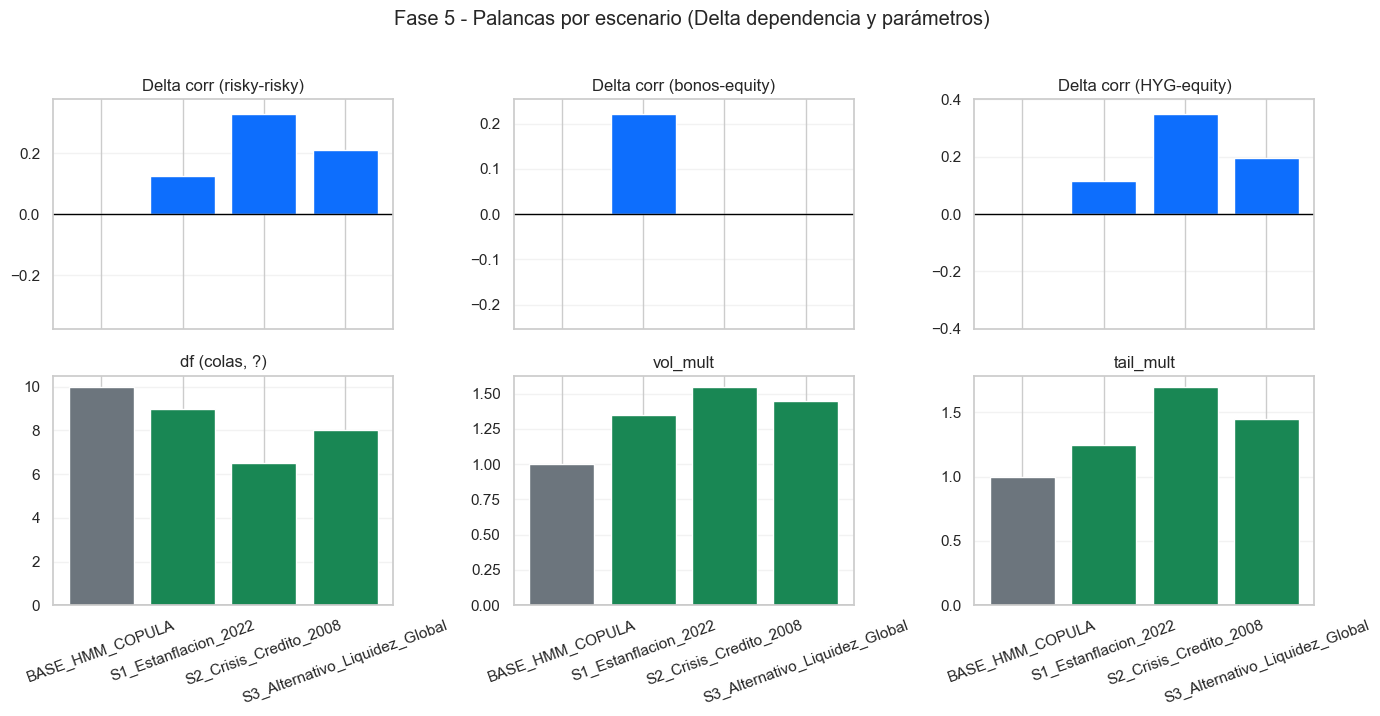

Saved: C:\Users\aleja\OneDrive\Documents\MASTER\practica 6 Gestion de riesgos\29--30-y-31-enero.-Gesti-n-De-Riesgos-Financieros.-Francisco-P-rez--lvaro-Ar-valo-20260129\outputs_taller\phase5_levers_barplot_6m_n10000.png


In [21]:
# --- Phase 5 - Plots de palancas (comité-friendly) ---

OUT_DIR=Path(OUT_DIR) if 'OUT_DIR' in globals() else Path('outputs_taller')
_lever_tbl=globals().get('lever_tbl')
if _lever_tbl is None:
    p=OUT_DIR/f'phase5_stress_levers_summary_6m_n{N_STRESS}.csv'
    if not p.exists(): raise RuntimeError('No encuentro tabla de palancas. Ejecuta la celda anterior de Fase 5.')
    _lever_tbl=pd.read_csv(p)

if 'scenario' in _lever_tbl.columns:
    order=['BASE_HMM_COPULA','S1_Estanflacion_2022','S2_Crisis_Credito_2008','S3_Alternativo_Liquidez_Global']
    cats=[c for c in order if c in set(_lever_tbl['scenario'])]
    _lever_tbl=_lever_tbl.copy(); _lever_tbl['scenario']=pd.Categorical(_lever_tbl['scenario'],categories=cats,ordered=True); _lever_tbl=_lever_tbl.sort_values('scenario')

x=_lever_tbl['scenario'].astype(str).tolist() if 'scenario' in _lever_tbl.columns else [str(i) for i in range(len(_lever_tbl))]
fig,axes=plt.subplots(2,3,figsize=(14,7),sharex=True)
cm={'Delta corr (risky-risky)':'delta_avg_corr_risky','Delta corr (bonos-equity)':'delta_avg_corr_bonds_hedge','Delta corr (HYG-equity)':'delta_avg_corr_hyg_equity'}
pm={'df (colas, ?)':'df_used','vol_mult':'vol_mult','tail_mult':'tail_mult'}
for ax,(ttl,col) in zip(axes[0],cm.items()):
    if col in _lever_tbl.columns:
        y=pd.to_numeric(_lever_tbl[col],errors='coerce').to_numpy(); ax.bar(x,y,color=['#6c757d' if 'BASE' in s else '#0d6efd' for s in x]); lim=max(0.02,float(np.nanmax(np.abs(y)))*1.15) if np.isfinite(y).any() else 0.05; ax.axhline(0,color='black',lw=1); ax.set_ylim(-lim,lim)
    else: ax.text(0.5,0.5,f'Falta columna: {col}',ha='center',va='center')
    ax.set_title(ttl); ax.grid(True,axis='y',alpha=0.25)
for ax,(ttl,col) in zip(axes[1],pm.items()):
    if col in _lever_tbl.columns:
        y=pd.to_numeric(_lever_tbl[col],errors='coerce').to_numpy(); ax.bar(x,y,color=['#6c757d' if 'BASE' in s else '#198754' for s in x]); ax.axhline(0,color='black',lw=1)
    else: ax.text(0.5,0.5,f'Falta columna: {col}',ha='center',va='center')
    ax.set_title(ttl); ax.grid(True,axis='y',alpha=0.25)
for ax in axes[1]: ax.tick_params(axis='x',rotation=20)
fig.suptitle('Fase 5 - Palancas por escenario (Delta dependencia y parámetros)', y=1.02)
plt.tight_layout(); plt.show()
if globals().get('EXPORT_STRESS',False):
    out=OUT_DIR/f'phase5_levers_barplot_6m_n{N_STRESS}.png'; fig.savefig(out,dpi=160,bbox_inches='tight'); print('Saved:',out)


## Análisis Comparativo de Escenarios de Estrés

### **Palancas de Dependencia (Fila Superior)**
- **Delta corr (risky-risky)**: Cambios correlación activos de riesgo
- **Delta corr (bonos-equity)**: Cambios correlación bonos defensivos
- **Delta corr (HYG-equity)**: Cambios correlación crédito vs equity

### **Parámetros de Modelo (Fila Inferior)**
- **df (colas)**: Grados de libertad cópula t (colas gruesas)
- **vol_mult**: Multiplicador volatilidad por régimen
- **tail_mult**: Multiplicador tail risk por escenario

### **Interpretación de Escenarios**
- **BASE_HMM_COPULA**: Referencia baseline (gris)
- **S1 Estanflación 2022**: Shock inflación + tasas (azul)
- **S2 Crisis Crédito 2008**: Stress financiero (azul)
- **S3 Liquidez Global**: Crisis sistémica (azul)

### **Aplicaciones de Comité**
- **Stress testing visual**: Identificación de riesgos clave
- **Comparación escenarios**: Impacto relativo por palanca
- **Decisión informada**: Base para gestión de riesgos

## 6) Fase 6 - Reverse stress testing

Pregunta de gestion: cual es el shock mínimo para cruzar un umbral de pérdida inaceptable.

Enfoque aplicado:

- baseline en régimen Estrés,
- interpolación de intensidad `lambda in [0,1]` sobre familias de shocks,
- búsqueda del `lambda` mínimo que rompe el umbral objetivo.

Outputs: grid completo, mínimo por familia, mejor global y análisis de sensibilidad.


Métrica base ES5 (modelo Estrés): -3.6389%
Objetivo   ES5: -5.8223%  (TARGET_MULT=1.6, TARGET_ABS=None)

Ejecutando búsqueda en escala para 3 familias de escenarios...
  Procesando familia: S1_Estanflacion_2022


  Procesando familia: S2_Crisis_Credito_2008


  Procesando familia: S3_Alternativo_Liquidez_Global


Completada evaluación de 63 puntos de escala

Analizando sensibilidad para multiplicadores: [1.4, 1.6, 1.8]
  Evaluando multiplicador 1.4: objetivo = -5.0945%
  Evaluando multiplicador 1.6: objetivo = -5.8223%
  Evaluando multiplicador 1.8: objetivo = -6.5500%

=== TABLA DE SENSIBILIDAD ===


,target_mult,target_value,family,min_lambda,metric_at_min,status
0,1.4,-0.050945,S1_Estanflacion_2022,0.65,-0.051479,CROSS
1,1.4,-0.050945,S2_Crisis_Credito_2008,0.35,-0.052260,CROSS
2,1.4,-0.050945,S3_Alternativo_Liquidez_Global,0.45,-0.051879,CROSS
3,1.6,-0.058223,S1_Estanflacion_2022,0.90,-0.058478,CROSS
4,1.6,-0.058223,S2_Crisis_Credito_2008,0.50,-0.062279,CROSS
5,1.6,-0.058223,S3_Alternativo_Liquidez_Global,0.70,-0.060599,CROSS
6,1.8,-0.065500,S1_Estanflacion_2022,NaN,NaN,NO_CROSS
7,1.8,-0.065500,S2_Crisis_Credito_2008,0.65,-0.069541,CROSS
8,1.8,-0.065500,S3_Alternativo_Liquidez_Global,0.85,-0.066762,CROSS


Tabla de sensibilidad guardada en: C:\Users\aleja\OneDrive\Documents\MASTER\practica 6 Gestion de riesgos\29--30-y-31-enero.-Gesti-n-De-Riesgos-Financieros.-Francisco-P-rez--lvaro-Ar-valo-20260129\outputs_taller\phase6_reverse_stress_sensitivity_1d_n25000.csv

Buscando λ mínimo que cruza el objetivo -5.8223%...
  S1_Estanflacion_2022: λ_min = 0.900 (métrica = -5.8478%)
  S2_Crisis_Credito_2008: λ_min = 0.500 (métrica = -6.2279%)
  S3_Alternativo_Liquidez_Global: λ_min = 0.700 (métrica = -6.0599%)

=== MEJOR REVERSE STRESS (λ mínimo) ===
Familia: S2_Crisis_Credito_2008
λ mínimo: 0.500
Métrica ES5: -6.2279%
Intensidad de shock requerida: 50.0% del shock máximo

=== RESUMEN DE λ MÍNIMOS POR FAMILIA ===


,family,lambda_min,status,ES5,ES5,VaR5,ES1,VaR1,df_used,vol_mult,tail_mult,apply_to
0,S1_Estanflacion_2022,0.9,CROSS,-0.058478,-0.058478,-0.036633,-0.096736,-0.071949,9.10,1.315,1.225,"AAPL,AMZN,BAC,BRK-B,CVX,ENPH,GOOGL,JNJ,JPM,MSFT,NVDA,PG,XOM,GLD,IEF,SHY,HYG"
1,S2_Crisis_Credito_2008,0.5,CROSS,-0.062279,-0.062279,-0.037291,-0.106362,-0.078485,8.25,1.275,1.350,"HYG,AAPL,AMZN,BAC,BRK-B,CVX,ENPH,GOOGL,JNJ,JPM,MSFT,NVDA,PG,XOM"
2,S3_Alternativo_Liquidez_Global,0.7,CROSS,-0.060599,-0.060599,-0.037683,-0.101694,-0.075585,8.60,1.315,1.315,"AAPL,AMZN,BAC,BRK-B,CVX,ENPH,GOOGL,JNJ,JPM,MSFT,NVDA,PG,XOM,GLD,IEF,SHY,HYG"


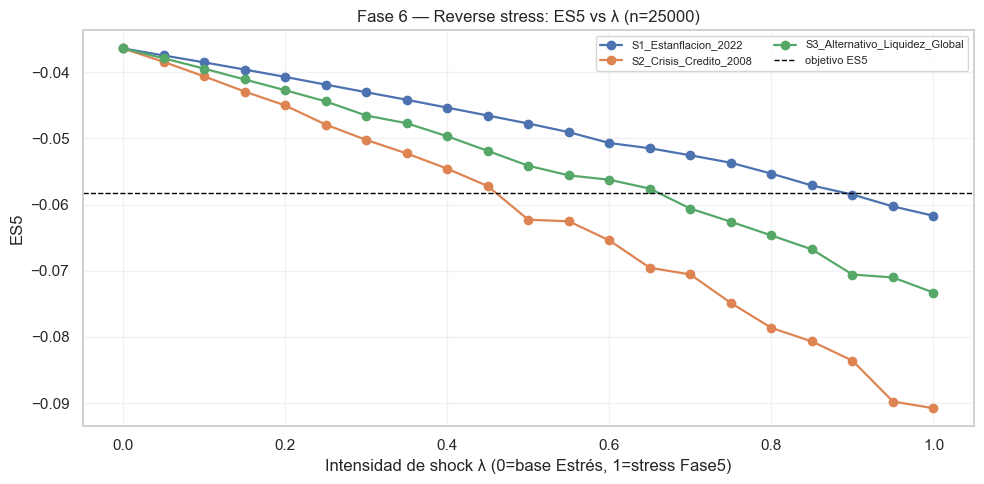


Escala de resultados guardada en: C:\Users\aleja\OneDrive\Documents\MASTER\practica 6 Gestion de riesgos\29--30-y-31-enero.-Gesti-n-De-Riesgos-Financieros.-Francisco-P-rez--lvaro-Ar-valo-20260129\outputs_taller\phase6_reverse_stress_grid_1d_n25000.csv
Tabla de λ mínimos guardada en: C:\Users\aleja\OneDrive\Documents\MASTER\practica 6 Gestion de riesgos\29--30-y-31-enero.-Gesti-n-De-Riesgos-Financieros.-Francisco-P-rez--lvaro-Ar-valo-20260129\outputs_taller\phase6_reverse_stress_minimum_1d_n25000.csv


Gráfico guardado en: C:\Users\aleja\OneDrive\Documents\MASTER\practica 6 Gestion de riesgos\29--30-y-31-enero.-Gesti-n-De-Riesgos-Financieros.-Francisco-P-rez--lvaro-Ar-valo-20260129\outputs_taller\phase6_reverse_stress_plot_1d_n25000.png

=== RESUMEN EJECUTIVO DE REVERSE STRESS ===
• El escenario S2_Crisis_Credito_2008 requiere la menor intensidad de shock (50.0%)
• Para alcanzar ES5 de -5.8223% vs base -3.6389%
• Esto representa un shock de 50.0% de la intensidad máxima del escenario


In [22]:
# --- Fase 6: Reverse stress testing (intensidad mínima de shock λ) ---

# Configuración de parámetros
N_REV = 25_000          # Número de simulaciones para reverse stress
SEED_REV = 777          # Semilla para reproducibilidad
EXPORT_REV = True       # Exportar resultados a archivos CSV

# Métrica objetivo y umbral
TARGET_METRIC = "ES5"   # Métrica objetivo: {"ES5","VaR5","ES1","VaR1"}
TARGET_MULT = 1.60      # Multiplicador del umbral: umbral = métrica_base * TARGET_MULT (más negativo)
TARGET_ABS = None       # Umbral absoluto opcional: ej. -0.04 (anula TARGET_MULT si no es None)

# Multiplicadores de sensibilidad para justificación (usa misma escala)
SENSITIVITY_MULTS = [1.4, 1.6, 1.8]

# Verificación de prerequisitos
required = ["assets", "histS", "base_Ct", "base_df", "scenario_specs", "w"]
missing = [k for k in required if k not in globals()]
if missing:
    raise RuntimeError(f"Faltan prerequisitos para Fase 6: {missing}. Ejecutar Fase 5 primero.")

# Configuración de directorios
OUT_DIR = Path(OUT_DIR) if "OUT_DIR" in globals() else Path("outputs_taller")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Reutilizar funciones auxiliares de Fase 5, verificar disponibilidad
if "_nearest_psd_corr" not in globals():
    raise RuntimeError("Falta _nearest_psd_corr. Ejecutar celda de Fase 5 primero.")
if "_simulate_state_from_copula" not in globals():
    raise RuntimeError("Falta _simulate_state_from_copula. Ejecutar celda de Fase 5 primero.")
if "_shock_marginal_vol_mean" not in globals() or "_shock_tail_left" not in globals():
    raise RuntimeError("Faltan funciones de shock marginal. Ejecutar celda de Fase 5 primero.")
if "_portfolio_metrics" not in globals():
    raise RuntimeError("Falta _portfolio_metrics. Ejecutar celda de Fase 5 primero.")

def _blend_corr(C0: np.ndarray, C1: np.ndarray, lam: float) -> np.ndarray:
    """Mezclar matrices de correlación usando parámetro λ."""
    lam = float(np.clip(lam, 0.0, 1.0))
    C = (1.0 - lam) * np.asarray(C0, dtype=float) + lam * np.asarray(C1, dtype=float)
    np.fill_diagonal(C, 1.0)
    return _nearest_psd_corr(C)

def _lin(a: float, b: float, lam: float) -> float:
    """Interpolación lineal entre dos valores usando parámetro λ."""
    lam = float(np.clip(lam, 0.0, 1.0))
    return float((1.0 - lam) * a + lam * b)

def _eval_lambda(spec: dict, lam: float, n: int, seed: int) -> dict:
    """Evaluar métricas para un valor específico de λ."""
    # Mezclar parámetros del escenario
    Ct_l = _blend_corr(base_Ct, np.asarray(spec["Ct"], dtype=float), lam)
    df_l = _lin(float(base_df), float(spec["df"]), lam)
    vol_mult_l = _lin(1.0, float(spec["vol_mult"]), lam)
    tail_mult_l = _lin(1.0, float(spec["tail_mult"]), lam)

    # Simular retornos
    rng = np.random.default_rng(seed)
    R = _simulate_state_from_copula(n, Ct_l, df_l, histS, rng)

    # Aplicar shocks marginales
    cols = spec.get("apply_cols")
    R = _shock_marginal_vol_mean(R, vol_mult=vol_mult_l, mean_shift=0.0, cols=cols)
    R = _shock_tail_left(R, q=0.05, tail_mult=tail_mult_l, cols=cols)

    # Calcular métricas de cartera
    m = _portfolio_metrics(R, w)

    # Agregar información de palancas para reporte
    apply_cols = spec.get("apply_cols")
    if isinstance(apply_cols, list):
        apply_names = [assets[i] for i in apply_cols if 0 <= i < len(assets)]
        apply_to = ",".join(apply_names) if apply_names else "(subset)"
    else:
        apply_to = "all"

    return {
        "family": spec["name"],
        "lambda": float(lam),
        "n": int(n),
        "seed": int(seed),
        "df_used": float(df_l),
        "vol_mult": float(vol_mult_l),
        "tail_mult": float(tail_mult_l),
        "apply_to": apply_to,
        **m,
    }

# Calcular métrica base bajo modelo Estrés (λ=0)
if "R_base" in globals() and isinstance(globals().get("R_base"), np.ndarray):
    base_metrics = _portfolio_metrics(R_base, w)
else:
    rng0 = np.random.default_rng(SEED_REV)
    R0 = _simulate_state_from_copula(N_REV, base_Ct, float(base_df), histS, rng0)
    base_metrics = _portfolio_metrics(R0, w)

baseline_value = float(base_metrics.get(TARGET_METRIC, np.nan))
if not np.isfinite(baseline_value):
    raise RuntimeError(f"Métrica base {TARGET_METRIC} es NaN; no se puede hacer reverse stress.")

# Determinar valor objetivo
if TARGET_ABS is not None:
    target_value = float(TARGET_ABS)
else:
    target_value = float(baseline_value * TARGET_MULT)

print(f"Métrica base {TARGET_METRIC} (modelo Estrés): {baseline_value:.4%}")
print(f"Objetivo   {TARGET_METRIC}: {target_value:.4%}  (TARGET_MULT={TARGET_MULT}, TARGET_ABS={TARGET_ABS})")

# Búsqueda en escala sobre λ para cada familia de escenarios de Fase 5
lams = np.linspace(0.0, 1.0, 21)
rows = []

print(f"\nEjecutando búsqueda en escala para {len(scenario_specs)} familias de escenarios...")
for spec in scenario_specs:
    print(f"  Procesando familia: {spec['name']}")
    for lam in lams:
        rows.append(_eval_lambda(spec, float(lam), n=N_REV, seed=SEED_REV))

grid = pd.DataFrame(rows)
print(f"Completada evaluación de {len(rows)} puntos de escala")

# Encontrar λ mínimo que cruza el objetivo (para métricas de pérdida, más negativo es "peor")
# Asumimos que VaR/ES son negativos en espacio de retornos
def _crosses(val: float, target: float) -> bool:
    """Determinar si un valor cruza el umbral objetivo."""
    return float(val) <= float(target)

# Análisis de sensibilidad en el umbral (sin simulaciones adicionales, reusa escala)
if TARGET_ABS is None:
    print(f"\nAnalizando sensibilidad para multiplicadores: {SENSITIVITY_MULTS}")
    sens_rows = []
    
    for mult in SENSITIVITY_MULTS:
        target_val = float(baseline_value * mult)
        print(f"  Evaluando multiplicador {mult}: objetivo = {target_val:.4%}")
        
        for fam, g in grid.groupby("family", sort=False):
            g = g.sort_values("lambda")
            metric_series = g[TARGET_METRIC]
            idx = None
            
            for i in range(len(g)):
                v = float(metric_series.iloc[i])
                if np.isfinite(v) and _crosses(v, target_val):
                    idx = i
                    break
            
            sens_rows.append({
                "target_mult": mult,
                "target_value": target_val,
                "family": fam,
                "min_lambda": float(g.iloc[idx]["lambda"]) if idx is not None else np.nan,
                "metric_at_min": float(g.iloc[idx][TARGET_METRIC]) if idx is not None else np.nan,
                "status": "CROSS" if idx is not None else "NO_CROSS",
            })
    
    sens_tbl = pd.DataFrame(sens_rows)
    print("\n=== TABLA DE SENSIBILIDAD ===")
    display(sens_tbl)
    
    if EXPORT_REV:
        out_sens = OUT_DIR / f"phase6_reverse_stress_sensitivity_1d_n{N_REV}.csv"
        sens_tbl.to_csv(out_sens, index=False)
        print(f"Tabla de sensibilidad guardada en: {out_sens}")
else:
    print("[Info] TARGET_ABS establecido; tabla de sensibilidad usa TARGET_MULTs solo cuando TARGET_ABS es None.")

# Encontrar λ mínimo para cada familia
print(f"\nBuscando λ mínimo que cruza el objetivo {target_value:.4%}...")
min_rows = []

for fam, g in grid.groupby("family", sort=False):
    g = g.sort_values("lambda")
    metric_series = g[TARGET_METRIC]
    idx = None
    
    for i in range(len(g)):
        v = float(metric_series.iloc[i])
        if np.isfinite(v) and _crosses(v, target_value):
            idx = i
            break
    
    if idx is None:
        min_rows.append({"family": fam, "lambda_min": np.nan, "status": "NO_CROSS"})
        print(f"  {fam}: NO CRUZA el objetivo")
        continue

    lam_hit = float(g["lambda"].iloc[idx])
    metric_hit = float(g[TARGET_METRIC].iloc[idx])
    print(f"  {fam}: λ_min = {lam_hit:.3f} (métrica = {metric_hit:.4%})")
    
    min_rows.append({
        "family": fam,
        "lambda_min": lam_hit,
        "status": "CROSS",
        TARGET_METRIC: float(g[TARGET_METRIC].iloc[idx]),
        "VaR5": float(g["VaR5"].iloc[idx]),
        "ES5": float(g["ES5"].iloc[idx]),
        "VaR1": float(g["VaR1"].iloc[idx]),
        "ES1": float(g["ES1"].iloc[idx]),
        "df_used": float(g["df_used"].iloc[idx]),
        "vol_mult": float(g["vol_mult"].iloc[idx]),
        "tail_mult": float(g["tail_mult"].iloc[idx]),
        "apply_to": str(g["apply_to"].iloc[idx]),
    })

min_tbl = pd.DataFrame(min_rows)

# Encontrar mejor opción (mínimo λ entre familias)
best = min_tbl[min_tbl["status"] == "CROSS"].copy()
if len(best) > 0:
    best = best.sort_values(["lambda_min", TARGET_METRIC], ascending=[True, True]).head(1)
    best_family = str(best["family"].iloc[0])
    best_lambda = float(best["lambda_min"].iloc[0])
    best_metric = float(best[TARGET_METRIC].iloc[0])
    
    print(f"\n=== MEJOR REVERSE STRESS (λ mínimo) ===")
    print(f"Familia: {best_family}")
    print(f"λ mínimo: {best_lambda:.3f}")
    print(f"Métrica {TARGET_METRIC}: {best_metric:.4%}")
    print(f"Intensidad de shock requerida: {(best_lambda * 100):.1f}% del shock máximo")
else:
    best_family, best_lambda = None, np.nan
    print(f"\nADVERTENCIA: Ninguna familia cruza el objetivo en esta escala de λ.")
    print(f"Considerar disminuir TARGET_MULT o establecer TARGET_ABS más cercano a la línea base.")

# Mostrar tabla de resultados
show_cols = ["family", "lambda_min", "status"]
extra = [c for c in [TARGET_METRIC, "ES5", "VaR5", "ES1", "VaR1", "df_used", "vol_mult", "tail_mult", "apply_to"] 
          if c in min_tbl.columns]
show_cols = show_cols + [c for c in extra if c not in show_cols]

print(f"\n=== RESUMEN DE λ MÍNIMOS POR FAMILIA ===")
display(min_tbl[show_cols])

# Visualizar métrica vs λ
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

for fam, g in grid.groupby("family", sort=False):
    g = g.sort_values("lambda")
    ax.plot(g["lambda"], g[TARGET_METRIC], marker="o", lw=1.6, label=fam)

ax.axhline(target_value, color="black", ls="--", lw=1, label=f"objetivo {TARGET_METRIC}")
ax.set_title(f"Fase 6 — Reverse stress: {TARGET_METRIC} vs λ (n={N_REV})")
ax.set_xlabel("Intensidad de shock λ (0=base Estrés, 1=stress Fase5)")
ax.set_ylabel(TARGET_METRIC)
ax.grid(True, alpha=0.25)
ax.legend(ncol=2, fontsize=8)
plt.tight_layout()
plt.show()

# Exportar resultados
if EXPORT_REV:
    out_grid = OUT_DIR / f"phase6_reverse_stress_grid_1d_n{N_REV}.csv"
    grid.to_csv(out_grid, index=False)
    print(f"\nEscala de resultados guardada en: {out_grid}")

    out_min = OUT_DIR / f"phase6_reverse_stress_minimum_1d_n{N_REV}.csv"
    min_tbl.to_csv(out_min, index=False)
    print(f"Tabla de λ mínimos guardada en: {out_min}")

    if globals().get("EXPORT_STRESS", False):
        out_png = OUT_DIR / f"phase6_reverse_stress_plot_1d_n{N_REV}.png"
        fig.savefig(out_png, dpi=160, bbox_inches="tight")
        print(f"Gráfico guardado en: {out_png}")

print(f"\n=== RESUMEN EJECUTIVO DE REVERSE STRESS ===")
if best_family is not None:
    print(f"• El escenario {best_family} requiere la menor intensidad de shock ({best_lambda:.1%})")
    print(f"• Para alcanzar {TARGET_METRIC} de {target_value:.4%} vs base {baseline_value:.4%}")
    print(f"• Esto representa un shock de {(best_lambda * 100):.1f}% de la intensidad máxima del escenario")
else:
    print(f"• No se encontró solución factible con los parámetros actuales")
    print(f"• Considerar ajustar TARGET_MULT o TARGET_ABS")

## 7) Conclusiones técnicas

- El esquema CORE/FULL/diagnostico 2006 preserva 2008, incorpora ENPH con proxy de forma controlada y limita el sesgo de GME mediante politica configurable.
- La clasificación de regímenes separa períodos de calma y estrés con señales macro consistentes (volatilidad, drawdown y crédito), incluyendo el bloque 2008-2009.
- En riesgo marginal, HYG muestra un salto fuerte de volatilidad en estrés (x2.70 vs normal), mientras que GLD no mantiene un perfil de refugio robusto en este corte.
- En dependencia, el estado de estrés presenta mas correlación media y mayor dependencia de cola que el estado normal, lo que confirma deterioro de diversificación.
- El motor Monte Carlo replica bien magnitudes de riesgo base (volatilidad y cola diaria) y reproduce de forma coherente el peso relativo de cada régimen.
- En escenarios forzados, la Crisis de Crédito 2008 es el caso mas severo en VaR/ES 99% a 6 meses.
- En reverse stress, el umbral crítico se alcanza antes con el escenario de crédito, lo que lo posiciona como principal vulnerabilidad de la cartera.

## Control de entregables

La celda final verifica automaticamente que existan los outputs tecnicos clave generados por el notebook.

In [23]:
# --- Checklist técnico de entregables ---

out = Path(OUT_DIR)
checks = [
    ("Fase 2: tabla riesgo por estado", out / "phase2_risk_by_state.csv"),
    ("Fase 3: copula summary", out / "phase3_copula_summary.json"),
    ("Fase 4: wealth bands 6m 10k", out / "phase4_wealth_bands_6m_n10000.csv"),
    ("Fase 4: reproducción regímenes", out / "phase4_regime_reproduction_6m_n10000.csv"),
    ("Fase 4: validación riesgo cartera", out / "phase4_portfolio_risk_validation_6m_n10000.csv"),
    ("Fase 4: validación dependencia", out / "phase4_dependence_validation_6m_n10000.csv"),
    ("Fase 5: resumen escenarios estres", out / "phase5_stress_summary_6m_n10000.csv"),
    ("Fase 5: palancas escenarios", out / "phase5_stress_levers_summary_6m_n10000.csv"),
    ("Fase 6: reverse stress mínimo", out / "phase6_reverse_stress_minimum_1d_n25000.csv"),
]

rows = []
for item, path in checks:
    rows.append({"item": item, "status": "OK" if path.exists() else "FALTA", "path": str(path)})

check_df = pd.DataFrame(rows)
display(check_df)

n_missing = int((check_df["status"] == "FALTA").sum())
if n_missing == 0:
    print("Checklist técnico: completo.")
else:
    print(f"Checklist técnico: faltan {n_missing} outputs.")

print("Control de entregables: se han verificado los archivos técnicos clave en outputs_taller/.")


,item,status,path
0,Fase 2: tabla riesgo por estado,OK,C:\Users\aleja\OneDrive\Documents\MASTER\practica 6 Gestion de riesgos\29--30-y-31-enero.-Gesti-n-De-Riesgos-Financieros.-Francisco-P-rez--lvaro-Ar-valo-20260129\outputs_taller\phase2_risk_by_state.csv
1,Fase 3: copula summary,OK,C:\Users\aleja\OneDrive\Documents\MASTER\practica 6 Gestion de riesgos\29--30-y-31-enero.-Gesti-n-De-Riesgos-Financieros.-Francisco-P-rez--lvaro-Ar-valo-20260129\outputs_taller\phase3_copula_summary.json
2,Fase 4: wealth bands 6m 10k,OK,C:\Users\aleja\OneDrive\Documents\MASTER\practica 6 Gestion de riesgos\29--30-y-31-enero.-Gesti-n-De-Riesgos-Financieros.-Francisco-P-rez--lvaro-Ar-valo-20260129\outputs_taller\phase4_wealth_bands_6m_n10000.csv
3,Fase 4: reproducción regímenes,OK,C:\Users\aleja\OneDrive\Documents\MASTER\practica 6 Gestion de riesgos\29--30-y-31-enero.-Gesti-n-De-Riesgos-Financieros.-Francisco-P-rez--lvaro-Ar-valo-20260129\outputs_taller\phase4_regime_reproduction_6m_n10000.csv
4,Fase 4: validación riesgo cartera,OK,C:\Users\aleja\OneDrive\Documents\MASTER\practica 6 Gestion de riesgos\29--30-y-31-enero.-Gesti-n-De-Riesgos-Financieros.-Francisco-P-rez--lvaro-Ar-valo-20260129\outputs_taller\phase4_portfolio_risk_validation_6m_n10000.csv
5,Fase 4: validación dependencia,OK,C:\Users\aleja\OneDrive\Documents\MASTER\practica 6 Gestion de riesgos\29--30-y-31-enero.-Gesti-n-De-Riesgos-Financieros.-Francisco-P-rez--lvaro-Ar-valo-20260129\outputs_taller\phase4_dependence_validation_6m_n10000.csv
6,Fase 5: resumen escenarios estres,OK,C:\Users\aleja\OneDrive\Documents\MASTER\practica 6 Gestion de riesgos\29--30-y-31-enero.-Gesti-n-De-Riesgos-Financieros.-Francisco-P-rez--lvaro-Ar-valo-20260129\outputs_taller\phase5_stress_summary_6m_n10000.csv
7,Fase 5: palancas escenarios,OK,C:\Users\aleja\OneDrive\Documents\MASTER\practica 6 Gestion de riesgos\29--30-y-31-enero.-Gesti-n-De-Riesgos-Financieros.-Francisco-P-rez--lvaro-Ar-valo-20260129\outputs_taller\phase5_stress_levers_summary_6m_n10000.csv
8,Fase 6: reverse stress mínimo,OK,C:\Users\aleja\OneDrive\Documents\MASTER\practica 6 Gestion de riesgos\29--30-y-31-enero.-Gesti-n-De-Riesgos-Financieros.-Francisco-P-rez--lvaro-Ar-valo-20260129\outputs_taller\phase6_reverse_stress_minimum_1d_n25000.csv


Checklist técnico: completo.
Control de entregables: se han verificado los archivos técnicos clave en outputs_taller/.
